<a href="https://colab.research.google.com/github/szymonkulpinski/colab_notebooks/blob/main/teams_clustering_siglip2_image_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Check if GPU is in use
If this command fails: click in the upper-right corner of this window 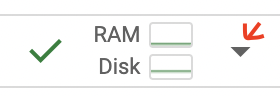
 and select `Change runtime type` and then select `T4 GPU`







In [1]:
!nvidia-smi

Tue Apr 15 14:59:38 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   65C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Install all dependencies

In [2]:
!curl -LsSf https://astral.sh/uv/install.sh | sh

downloading uv 0.6.14 x86_64-unknown-linux-gnu
no checksums to verify
installing to /usr/local/bin
  uv
  uvx
everything's installed!


In [3]:
!pip install -q roboflow supervision umap-learn tqdm adjustText

In [4]:
!pip install git+https://github.com/huggingface/transformers

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-i6n3vy3e
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-i6n3vy3e
  Resolved https://github.com/huggingface/transformers to commit 356b3cd71d7bfb51c88fea3e8a0c054f3a457ab9
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


### Make all the relevant imports

In [5]:
import os
import time
import pickle
import umap
import torch
import cv2
import warnings

import numpy as np
import seaborn as sns
import supervision as sv
import matplotlib.pyplot as plt

from tqdm import tqdm
from roboflow import Roboflow
from adjustText import adjust_text
from google.colab import userdata
from pathlib import Path
from sklearn.cluster import KMeans
from more_itertools import chunked
from typing import Tuple
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from transformers import AutoFeatureExtractor, ResNetModel, AutoProcessor, SiglipVisionModel, CLIPProcessor, CLIPVisionModel, Siglip2VisionModel, AutoModel

### Define constants and settings


In [6]:
if 'google.colab' in str(get_ipython()):
  HOME = "/content"
else:
  HOME = os.getcwd()

# In the used dataset all of the images have the resolution of 1920x1080px
IMAGE_WIDTH = 1920
IMAGE_HEIGHT = 1080

# Settings
NUM_ITERATIONS = 5 # set to 1 if you only want to evaluate once, for evalutation used 32
BATCH_SIZE_ARRAY = [32]
# FOLDER_DIR = "/content/drive/MyDrive/0_teams-clustering_visualization" # where in google colab the experiments results should be saved
# FOLDER_DIR = "/content/drive/MyDrive/0_teams-clustering_preprocess_fix" # where in google colab the experiments results should be saved
# FOLDER_DIR = "/content/drive/MyDrive/0_teams-clustering_preprocess_fix_fast" # where in google colab the experiments results should be saved
FOLDER_DIR = "/content/drive/MyDrive/0_teams-clustering_preprocess_fix_fast_PCA" # where in google colab the experiments results should be saved
RUN_EXPERIMENTS = True # if set to true experiments will be run, if to false it will only read saved results
VISUALIZE_CROPS = False

VERSIONS_TO_TEST = [
  "google/siglip2-base-patch32-256",
  "google/siglip2-base-patch16-224",
  "google/siglip2-base-patch16-256",
  "google/siglip2-base-patch16-384",
  "google/siglip2-base-patch16-512",
  "google/siglip2-base-patch16-naflex",
  "google/siglip2-large-patch16-256",
  "google/siglip2-large-patch16-384",
  "google/siglip2-large-patch16-512",
  "google/siglip2-so400m-patch14-224",
  "google/siglip2-so400m-patch14-384",
  "google/siglip2-so400m-patch16-256",
  "google/siglip2-so400m-patch16-384",
  "google/siglip2-so400m-patch16-512",
  "google/siglip2-so400m-patch16-naflex",
  "google/siglip2-giant-opt-patch16-256",
  "google/siglip2-giant-opt-patch16-384", #17 modele
  "google/siglip-base-patch16-512",
  "google/siglip-base-patch16-384",
  "google/siglip-base-patch16-256",
  "google/siglip-base-patch16-224",
  "google/siglip-large-patch16-256",
  "google/siglip-large-patch16-384",
  "google/siglip-so400m-patch14-384",
  "google/siglip-so400m-patch14-224",
  "google/siglip-so400m-patch16-256-i18n",
  "microsoft/resnet-18",
  "microsoft/resnet-26",
  "microsoft/resnet-34",
  "microsoft/resnet-50",
  "microsoft/resnet-101",
  "microsoft/resnet-152",
  'openai/clip-vit-base-patch16',
  'openai/clip-vit-base-patch32',
  'openai/clip-vit-large-patch14',
  'openai/clip-vit-large-patch14-336',
]

# Ablation study settings
DO_ABLATION_STUDY = False
# BATCH_SIZE_ARRAY = [1,2,8,32] # values used in the ablation study


### Mount your google drive to google colab be able to save the results

In [7]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)
Path(FOLDER_DIR).mkdir(parents=True, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Get the dataset and adjust the folder structure
If you haven't added your `ROBOFLOW_API_KEY` to your secrets in Google Colab, this code snippet will fail. Follow the instructions in this [Roboflow Notebook](https://colab.research.google.com/github/roboflow/sports/blob/main/examples/soccer/notebooks/train_player_detector.ipynb#scrollTo=BSd93ZJzZZKt) to add it.


In [8]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

rf = Roboflow(api_key=userdata.get('ROBOFLOW_API_KEY'))
project = rf.workspace("szymon-kulpinski").project("football-players-clustering")
version = project.version(6)
dataset = version.download("yolov8") # use the format as the easier to work with then e.g. COCO
print(dataset.location)

!mv {dataset.location}/train/images/* {dataset.location}/train/
!mv {dataset.location}/train/labels/* {dataset.location}/train/
!rm -rdf {dataset.location}/train/images
!rm -rdf {dataset.location}/train/labels

mkdir: cannot create directory ‘/content/datasets’: File exists
/content/datasets
loading Roboflow workspace...
loading Roboflow project...
/content/datasets/football-players-clustering-6
mv: cannot stat '/content/datasets/football-players-clustering-6/train/images/*': No such file or directory
mv: cannot stat '/content/datasets/football-players-clustering-6/train/labels/*': No such file or directory


### Load the dataset as Supervision Detections

In [9]:
def convert_yolov8bbox_2_xyxy(xcycwh: np.ndarray) -> np.ndarray:
  # center_x center_y width height from https://roboflow.com/formats/yolov8-pytorch-txt.
  xcycwh[:,0] = xcycwh[:,0] * IMAGE_WIDTH
  xcycwh[:,1] = xcycwh[:,1] * IMAGE_HEIGHT
  xcycwh[:,2] = xcycwh[:,2] * IMAGE_WIDTH
  xcycwh[:,3] = xcycwh[:,3] * IMAGE_HEIGHT
  return sv.xcycwh_to_xyxy(xcycwh)

In [10]:
folder_path = Path(dataset.location)/ "train"
jpg_files = list(folder_path.glob('**/*.jpg'))
txt_files = [file.with_suffix('.txt') for file in jpg_files]

# jpg_files = ["/content/datasets/football-players-clustering-6/train/cd987c_0_7_png.rf.2410384de2ad3bc0088516227a167e60.jpg"]
# txt_files = ["/content/datasets/football-players-clustering-6/train/cd987c_0_7_png.rf.2410384de2ad3bc0088516227a167e60.txt"]

detections_list = []
for file in txt_files:
  data = np.loadtxt(str(file))
  class_id = data[:,0].astype(np.int32)
  xyxy = convert_yolov8bbox_2_xyxy(data[:,1:])
  detections_list.append(sv.Detections(xyxy=xyxy, class_id=class_id))
  # break # only do 1 iteration to have only 1 image
print(detections_list[0])
print(len(detections_list))
# print(jpg_files[0])

Detections(xyxy=array([[1078.  ,  432.  , 1098.  ,  476.  ],
       [1077.  ,  469.  , 1100.  ,  518.  ],
       [ 685.  ,  504.  ,  724.  ,  571.  ],
       [1345.  ,  361.  , 1365.  ,  408.  ],
       [ 659.  ,  474.  ,  695.  ,  537.  ],
       [ 750.  ,  507.  ,  780.  ,  570.  ],
       [1169.  ,  393.  , 1192.  ,  441.  ],
       [ 860.  ,  407.  ,  883.  ,  456.  ],
       [1596.  ,  437.  , 1621.  ,  493.  ],
       [ 775.  ,  513.88,  821.  ,  580.88],
       [ 604.  ,  702.  ,  640.  ,  782.  ],
       [1119.  ,  491.  , 1144.  ,  552.  ],
       [1283.  ,  542.  , 1318.  ,  611.  ],
       [ 591.  ,  512.  ,  628.  ,  574.  ],
       [1174.  ,  602.  , 1199.  ,  675.  ],
       [ 611.  ,  589.  ,  660.  ,  660.  ],
       [ 303.  ,  837.  ,  368.  ,  922.  ],
       [1410.  ,  657.  , 1445.  ,  742.  ],
       [ 390.  ,  810.  ,  441.  ,  896.  ],
       [ 250.  ,  688.12,  301.  ,  763.12]]), mask=None, confidence=None, class_id=array([1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0,

### Visualise the detections on the image, double check if the conversion was successful


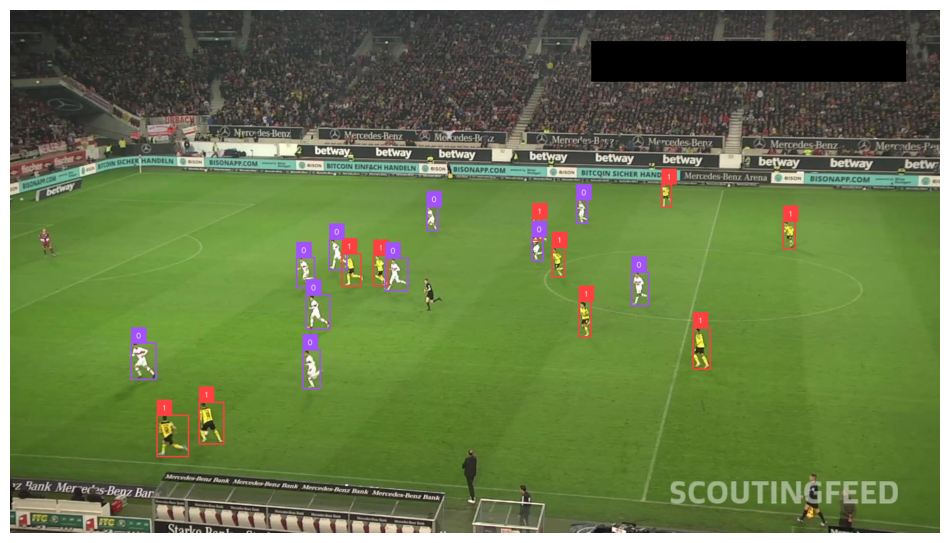

In [11]:
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()
image= cv2.imread(str(jpg_files[0]))
detections = detections_list[0]
annotated_image = image.copy()
annotated_image = box_annotator.annotate(annotated_image, detections=detections)
annotated_image = label_annotator.annotate(annotated_image, detections=detections)
sv.plot_image(image=annotated_image, size=(12, 12))

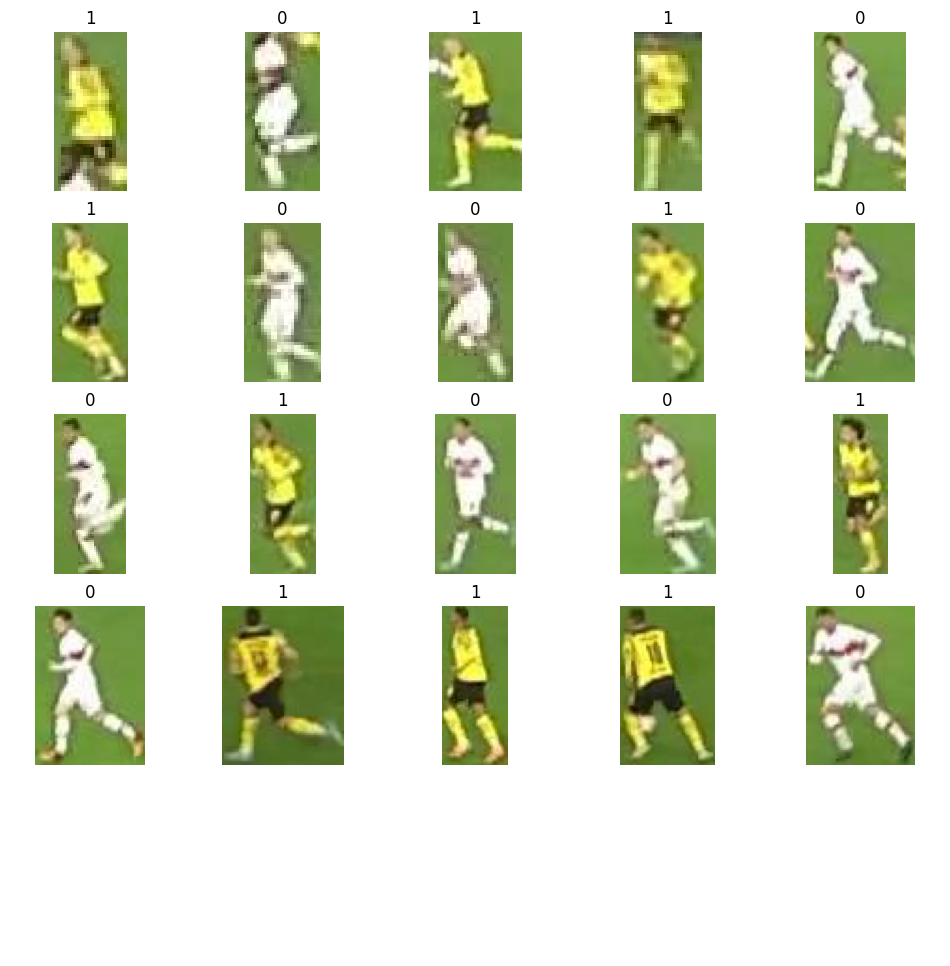

In [12]:
players_crops = [sv.crop_image(image, xyxy) for xyxy in detections.xyxy]
sv.plot_images_grid(players_crops, grid_size=(5,5), titles = [f"{i}" for i in detections_list[0].class_id])

### Define helper methods and class

In [13]:
class Experiment:
  def __init__(self, model_path: str):
    self.model_path = model_path
    self.model = None
    self.processor = None
    self.results_list = []
    self.clusters_list = []
    self.execution_time_list = []
    self.total_execution_time_list = []
    if "clip" in model_path:
      self.model_type = "CLIP"
    elif "siglip2" in model_path:
      self.model_type = "SIGLIP2"
    elif "siglip" in model_path:
      self.model_type = "SIGLIP"
    elif "resnet" in model_path:
      self.model_type = "RESNET"
    else:
      raise ValueError("Unknown model type")


  def init_model_n_processor(self):
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    if self.model_type == "CLIP":
      self.model = CLIPVisionModel.from_pretrained(self.model_path).to(DEVICE)
      self.processor = AutoProcessor.from_pretrained(self.model_path, use_fast=True)
      # self.processor = CLIPImageProcessorFast.from_pretrained(self.model_path)
    elif self.model_type == "SIGLIP2":
      self.model = AutoModel.from_pretrained(self.model_path, device_map=DEVICE).eval()
      self.processor = AutoProcessor.from_pretrained(self.model_path, use_fast=True)
      self.processor.image_processor.image_mean = [0.485, 0.456, 0.406]
      self.processor.image_processor.image_std = [0.229, 0.224, 0.225]
      # self.processor = Siglip2ImageProcessorFast.from_pretrained(self.model_path)
      # self.processor.image_mean = [0.485, 0.456, 0.406]
      # self.processor.image_std = [0.229, 0.224, 0.225]
    elif self.model_type == "SIGLIP":
      self.model = SiglipVisionModel.from_pretrained(self.model_path).to(DEVICE)
      # self.processor = SiglipImageProcessorFast.from_pretrained(self.model_path)
      # self.processor.image_mean = [0.485, 0.456, 0.406]
      # self.processor.image_std = [0.229, 0.224, 0.225]
      self.processor = AutoProcessor.from_pretrained(self.model_path, use_fast=True)
      self.processor.image_processor.image_mean = [0.485, 0.456, 0.406]
      self.processor.image_processor.image_std = [0.229, 0.224, 0.225]
    elif self.model_type == "RESNET":
      self.model = ResNetModel.from_pretrained(self.model_path).to(DEVICE)
      self.processor = AutoFeatureExtractor.from_pretrained(self.model_path)


  def forward(self, batch: np.ndarray) -> np.ndarray:
    with torch.no_grad():
      inputs = self.processor(images=batch, return_tensors="pt").to(DEVICE)

      if VISUALIZE_CROPS:
        # Print processor information
        # print("Processor info:", self.processor)
        if hasattr(self.processor, 'image_processor'):
            print("Image Processor info:", self.processor.image_processor)
        else:
            print("Image Processor: Not available or not an attribute of the processor")
        print("Size:", inputs.pixel_values.shape)  # Final image size after processing

        if hasattr(self.processor, 'size'):
          print("Resizing:", self.processor.size)  # Resizing settings
        else:
          print("Resizing: Not specified")

        if hasattr(self.processor, 'crop_size'):
          print("Cropping:", self.processor.crop_size)  # Cropping settings
        else:
          print("Cropping: Not specified")

        if hasattr(self.processor, 'image_mean') and hasattr(self.processor, 'image_std'):
          print("Normalization:", self.processor.image_mean, self.processor.image_std)  # Normalization settings
        else:
          print("Normalization: Not specified")

        for idx, image in enumerate(inputs.pixel_values):
            if idx in [1,8,12]:
              original_image = batch[idx]
              image_np = image.cpu().numpy()
              if image_np.shape[0] == 3:  # If shape is [3, H, W]
                  image_np = image_np.transpose(1, 2, 0)
              else:
                  print(image_np.shape)
                  # image_np = image_np.squeeze(0)  # Remove the channel dimension
                  # Stack the single channel 3 times to create a 3-channel image for visualization
                  image_np = np.stack([image_np, image_np, image_np], axis=-1)

              # Display side-by-side
              fig, axs = plt.subplots(1, 2, figsize=(10, 5))
              axs[0].imshow(original_image)
              axs[0].set_title("Original Image")
              axs[1].imshow(image_np)
              axs[1].set_title("Preprocessed Image")
              plt.show()

      if self.model_type == "SIGLIP2":
        embeddings = self.model.get_image_features(**inputs).cpu().numpy()
      else:
        outputs = self.model(**inputs)
        if self.model_type == "RESNET":
          embeddings = torch.mean(outputs.last_hidden_state, dim=[2, 3]).cpu().numpy()
        else:
          embeddings = torch.mean(outputs.last_hidden_state, dim=1).cpu().numpy()
      return embeddings


  def clean_up(self):
    self.model = None
    self.processor = None


In [14]:
def get_best_results_n_clusters(b_clusters: np.ndarray, b_class_id: np.ndarray)-> Tuple[np.ndarray, np.ndarray]:
  '''
    Compares predicted clusters (b_clusters) with ground truth class IDs (b_class_id)
    and potentially inverts the clusters to achieve the best possible accuracy.

    Setting all predictions to 1 or 0 will have at least a 50% success rate,
    so the classifier cannot perform worse than that.
    The assignment of cluster 0 and cluster 1 is arbitrary.
    Inverting the results to the "best result" corresponds to actual classification results.

    Args:
        b_clusters (np.ndarray): Predicted cluster assignments (0 or 1).
        b_class_id (np.ndarray): Ground truth class IDs (0 or 1).

    Returns:
        Tuple[np.ndarray, np.ndarray]: A tuple containing:
            - A boolean array indicating whether each prediction is correct after potential inversion.
            - The cluster assignments (0 or 1) after potential inversion.
  '''

  result = b_clusters == b_class_id
  if result.sum() < len(clusters)/2:
    b_clusters = ~b_clusters
    result = b_clusters == b_class_id
  return result, b_clusters.astype(np.int32)

def save_results_to_google_drive(experiments_list: list, batch_size: int, is_iteration=False):
  if is_iteration:
    filename = str(Path(FOLDER_DIR ) / ("experiments_list_batch32_it" + str(batch_size) + ".pkl"))
  else:
    filename = str(Path(FOLDER_DIR ) / ("experiments_list_batch" + str(batch_size) + ".pkl"))
  with open(filename, 'wb') as f:
    pickle.dump(experiments_list, f)

def load_results_from_google_drive(batch_size: list, is_iteration=False):
  if is_iteration:
    filename = str(Path(FOLDER_DIR ) / ("experiments_list_batch32_it" + str(batch_size) + ".pkl"))
  else:
    filename = str(Path(FOLDER_DIR ) / ("experiments_list_batch" + str(batch_size) + ".pkl"))
  loaded_experiment_list = None
  with open(filename, 'rb') as f:
    loaded_experiment_list = pickle.load(f)
  return loaded_experiment_list


### Init methods

In [15]:
TSNE_reducer = TSNE(n_components=3, perplexity=17, random_state=0)
PCA_reducer = PCA(n_components=3)
Umap_reducer = umap.UMAP(n_components=3)
KMeans_model = KMeans(n_clusters=2)

### Run the evaluation and save the results to your google drive for future evaluation

In [16]:
if RUN_EXPERIMENTS:
  DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
  warnings.filterwarnings("ignore", category=FutureWarning, message="'force_all_finite' was renamed to 'ensure_all_finite'")

  for iteration in range(NUM_ITERATIONS):
    experiments_list = [Experiment(model_path) for model_path in VERSIONS_TO_TEST] # prevent appending into infinity, create objects anew
    for batch_size in BATCH_SIZE_ARRAY:
      for k, exp in enumerate(experiments_list):
        print(f"Iteration: {iteration} / {NUM_ITERATIONS -1 }")
        print(f"Model: {exp.model_path}, {k} / {len(experiments_list)-1}")
        print("Batch size:", batch_size)
        exp.init_model_n_processor()
        for i, image_path in tqdm(enumerate(jpg_files), desc='per image', total=len(jpg_files)):
            image = cv2.imread(str(image_path))
            players_crops = [sv.crop_image(image, xyxy) for xyxy in detections_list[i].xyxy]
            pillow_crops = [sv.cv2_to_pillow(crop) for crop in players_crops]
            batches = chunked(pillow_crops, batch_size)

            data = []
            start_time = time.perf_counter()
            for batch in batches:
              data.append(exp.forward(batch))
            end_time = time.perf_counter()
            exp.execution_time_list.append(end_time - start_time)

            data = np.concatenate(data)
            # projections = Umap_reducer.fit_transform(data)
            projections = PCA_reducer.fit_transform(data)
            # projections = TSNE_reducer.fit_transform(data)


            clusters = np.array(KMeans_model.fit_predict(projections))

            total_time = time.perf_counter()
            exp.total_execution_time_list.append(total_time - start_time)

            result, clusters = get_best_results_n_clusters(clusters.astype(bool), detections_list[i].class_id.astype(bool))
            exp.results_list.append(result.sum() / len(clusters))
            exp.clusters_list.append(clusters)

        exp.clean_up()
        experiments_list[k] = exp

        print("Mean accuracy: ", np.mean(exp.results_list))
        print("Mean execution time: ", np.mean(exp.execution_time_list))
        print("Mean FPS: ", 1/np.mean(exp.execution_time_list))
        print("Double check exp.results_list length: ", len(exp.results_list))
        print(exp.results_list)
        print("\n")

      save_results_to_google_drive(experiments_list, iteration, is_iteration=True)

Iteration: 0 / 4
Model: google/siglip2-base-patch32-256, 0 / 35
Batch size: 32



The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
per image: 100%|██████████| 50/50 [00:10<00:00,  4.58it/s]


Mean accuracy:  0.8565300372142477
Mean execution time:  0.14802805802002694
Mean FPS:  6.755476045390722
Double check exp.results_list length:  50
[np.float64(0.85), np.float64(0.8), np.float64(1.0), np.float64(0.8636363636363636), np.float64(0.75), np.float64(0.95), np.float64(0.7368421052631579), np.float64(0.55), np.float64(0.85), np.float64(1.0), np.float64(0.95), np.float64(0.95), np.float64(0.65), np.float64(0.6), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(0.8), np.float64(1.0), np.float64(0.95), np.float64(0.8), np.float64(0.95), np.float64(0.85), np.float64(1.0), np.float64(1.0), np.float64(0.9), np.float64(0.8), np.float64(0.6842105263157895), np.float64(0.85), np.float64(0.75), np.float64(0.65), np.float64(1.0), np.float64(0.7), np.float64(0.65), np.float64(0.7), np.float64(0.95), np.float64(1.0), np.float64(0.9473684210526315), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(0.9444444444444444), np.float64(0

config.json:   0%|          | 0.00/253 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.50G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/47.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/34.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

per image: 100%|██████████| 50/50 [00:13<00:00,  3.72it/s]


Mean accuracy:  0.8689824561403509
Mean execution time:  0.22643300685998838
Mean FPS:  4.416317275768615
Double check exp.results_list length:  50
[np.float64(0.95), np.float64(0.8), np.float64(1.0), np.float64(1.0), np.float64(0.75), np.float64(0.95), np.float64(0.7894736842105263), np.float64(0.9), np.float64(0.85), np.float64(0.95), np.float64(0.95), np.float64(0.95), np.float64(0.6), np.float64(0.7), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(0.9), np.float64(0.85), np.float64(0.95), np.float64(0.9), np.float64(0.9), np.float64(0.7), np.float64(1.0), np.float64(0.95), np.float64(0.95), np.float64(0.95), np.float64(0.631578947368421), np.float64(0.75), np.float64(0.9), np.float64(0.6), np.float64(0.95), np.float64(0.85), np.float64(0.95), np.float64(0.65), np.float64(0.95), np.float64(0.9473684210526315), np.float64(0.9473684210526315), np.float64(1.0), np.float64(0.75), np.float64(1.0), np.float64(0.95), np.float64(0.9), np.float64(0.8333333333333334), np.float6

config.json:   0%|          | 0.00/276 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.50G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/47.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/34.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

per image: 100%|██████████| 50/50 [00:15<00:00,  3.20it/s]


Mean accuracy:  0.8749356725146198
Mean execution time:  0.2788095163599701
Mean FPS:  3.5866781487791943
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(0.85), np.float64(1.0), np.float64(1.0), np.float64(0.75), np.float64(0.95), np.float64(0.631578947368421), np.float64(0.95), np.float64(0.85), np.float64(0.95), np.float64(0.95), np.float64(1.0), np.float64(0.55), np.float64(0.55), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(0.85), np.float64(0.95), np.float64(0.95), np.float64(1.0), np.float64(0.9), np.float64(0.6), np.float64(1.0), np.float64(0.95), np.float64(0.95), np.float64(0.9), np.float64(0.631578947368421), np.float64(0.8), np.float64(0.9), np.float64(0.5), np.float64(1.0), np.float64(1.0), np.float64(0.9), np.float64(0.65), np.float64(0.95), np.float64(1.0), np.float64(0.8947368421052632), np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.8888888888888888), np.float64(0.6), np.float64

config.json:   0%|          | 0.00/276 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.50G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/47.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/34.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

per image: 100%|██████████| 50/50 [00:39<00:00,  1.28it/s]


Mean accuracy:  0.8849261031366296
Mean execution time:  0.7476603365600022
Mean FPS:  1.3375057510754373
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(0.8), np.float64(1.0), np.float64(0.6363636363636364), np.float64(0.75), np.float64(0.95), np.float64(0.8421052631578947), np.float64(0.95), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(0.6), np.float64(0.9), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.95), np.float64(0.95), np.float64(0.95), np.float64(0.75), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.9), np.float64(0.6842105263157895), np.float64(0.75), np.float64(0.9), np.float64(0.55), np.float64(1.0), np.float64(0.95), np.float64(0.9), np.float64(0.65), np.float64(0.95), np.float64(1.0), np.float64(0.8947368421052632), np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(1.0), np.float64(0.7), np.float64(0.8888888888888888), np.float64(0

config.json:   0%|          | 0.00/276 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.50G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/47.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/34.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

per image: 100%|██████████| 50/50 [01:17<00:00,  1.55s/it]


Mean accuracy:  0.8835587453482191
Mean execution time:  1.5224591600799795
Mean FPS:  0.6568320689452628
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(0.9545454545454546), np.float64(0.75), np.float64(0.95), np.float64(0.8421052631578947), np.float64(0.95), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(0.55), np.float64(0.65), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(0.75), np.float64(0.7), np.float64(0.95), np.float64(0.95), np.float64(0.9), np.float64(0.65), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.95), np.float64(0.8421052631578947), np.float64(0.75), np.float64(0.9), np.float64(0.5), np.float64(1.0), np.float64(0.7), np.float64(0.9), np.float64(0.7), np.float64(0.95), np.float64(1.0), np.float64(0.8947368421052632), np.float64(0.9), np.float64(0.95), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.9444444444444444), np.float64(0

config.json:   0%|          | 0.00/329 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.50G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/393 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/40.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/34.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

per image: 100%|██████████| 50/50 [00:17<00:00,  2.79it/s]


Mean accuracy:  0.8816783625730993
Mean execution time:  0.32536192455999297
Mean FPS:  3.0735003837722
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(0.8), np.float64(1.0), np.float64(1.0), np.float64(0.75), np.float64(0.95), np.float64(0.8421052631578947), np.float64(0.9), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.55), np.float64(0.8), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(0.8), np.float64(1.0), np.float64(0.95), np.float64(0.9), np.float64(0.9), np.float64(0.8), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.9), np.float64(1.0), np.float64(0.65), np.float64(0.9), np.float64(0.55), np.float64(0.95), np.float64(1.0), np.float64(0.55), np.float64(0.55), np.float64(0.95), np.float64(1.0), np.float64(0.9473684210526315), np.float64(0.95), np.float64(0.85), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.9444444444444444), np.float64(0.55), np.float64(0.95), np.float64

config.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.53G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/47.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/34.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

per image: 100%|██████████| 50/50 [00:47<00:00,  1.05it/s]


Mean accuracy:  0.806888888888889
Mean execution time:  0.9154047683599947
Mean FPS:  1.092412924384874
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(0.75), np.float64(1.0), np.float64(0.5), np.float64(0.75), np.float64(0.7), np.float64(0.7894736842105263), np.float64(0.65), np.float64(0.95), np.float64(1.0), np.float64(0.8), np.float64(0.95), np.float64(0.55), np.float64(0.65), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(0.75), np.float64(0.65), np.float64(0.95), np.float64(0.8), np.float64(0.65), np.float64(0.8), np.float64(1.0), np.float64(0.8), np.float64(0.95), np.float64(0.95), np.float64(0.5789473684210527), np.float64(0.6), np.float64(0.9), np.float64(0.6), np.float64(1.0), np.float64(0.5), np.float64(0.65), np.float64(0.5), np.float64(0.95), np.float64(0.6842105263157895), np.float64(0.9473684210526315), np.float64(0.95), np.float64(0.95), np.float64(1.0), np.float64(0.9), np.float64(0.8), np.float64(0.9444444444444444), np.float64(0.

config.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.53G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/47.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/34.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

per image: 100%|██████████| 50/50 [01:52<00:00,  2.25s/it]


Mean accuracy:  0.8797118553960659
Mean execution time:  2.219833110019963
Mean FPS:  0.4504843159092293
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.7727272727272727), np.float64(0.7), np.float64(0.95), np.float64(0.7894736842105263), np.float64(0.95), np.float64(1.0), np.float64(1.0), np.float64(0.75), np.float64(0.95), np.float64(0.55), np.float64(0.65), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(0.95), np.float64(0.85), np.float64(0.95), np.float64(0.9), np.float64(0.9), np.float64(0.7), np.float64(0.95), np.float64(1.0), np.float64(0.95), np.float64(0.95), np.float64(0.6842105263157895), np.float64(1.0), np.float64(0.9), np.float64(0.6), np.float64(0.95), np.float64(1.0), np.float64(0.55), np.float64(0.5), np.float64(0.95), np.float64(1.0), np.float64(0.8947368421052632), np.float64(0.75), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.9444444444444444), np.float64(0.

config.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.53G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/47.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/34.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

per image: 100%|██████████| 50/50 [03:40<00:00,  4.41s/it]


Mean accuracy:  0.8566353003721424
Mean execution time:  4.375909846340046
Mean FPS:  0.22852390362575384
Double check exp.results_list length:  50
[np.float64(0.95), np.float64(1.0), np.float64(0.55), np.float64(0.8636363636363636), np.float64(0.85), np.float64(0.95), np.float64(0.8947368421052632), np.float64(0.7), np.float64(1.0), np.float64(0.9), np.float64(0.85), np.float64(0.85), np.float64(0.55), np.float64(0.9), np.float64(1.0), np.float64(0.55), np.float64(1.0), np.float64(0.7), np.float64(1.0), np.float64(0.95), np.float64(0.95), np.float64(0.9), np.float64(0.9), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.6842105263157895), np.float64(0.9), np.float64(0.75), np.float64(0.7), np.float64(1.0), np.float64(0.55), np.float64(0.9), np.float64(0.5), np.float64(1.0), np.float64(0.8947368421052632), np.float64(1.0), np.float64(0.7), np.float64(1.0), np.float64(0.95), np.float64(0.9), np.float64(1.0), np.float64(0.9444444444444444), np.float64(0.6

config.json:   0%|          | 0.00/536 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/47.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/34.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

per image: 100%|██████████| 50/50 [01:05<00:00,  1.31s/it]


Mean accuracy:  0.830022860180755
Mean execution time:  1.2775270412999726
Mean FPS:  0.78276229596082
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(0.95), np.float64(0.95), np.float64(0.5909090909090909), np.float64(0.75), np.float64(0.95), np.float64(0.8421052631578947), np.float64(0.8), np.float64(1.0), np.float64(0.95), np.float64(0.8), np.float64(0.6), np.float64(0.6), np.float64(0.5), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(0.85), np.float64(0.55), np.float64(0.95), np.float64(0.85), np.float64(0.9), np.float64(0.75), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.9), np.float64(0.5789473684210527), np.float64(0.75), np.float64(0.7), np.float64(0.7), np.float64(1.0), np.float64(0.85), np.float64(0.85), np.float64(0.65), np.float64(0.95), np.float64(1.0), np.float64(0.8947368421052632), np.float64(0.95), np.float64(0.8), np.float64(0.95), np.float64(0.85), np.float64(0.9), np.float64(0.9444444444444444), np.float64(0

config.json:   0%|          | 0.00/559 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/47.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/34.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

per image: 100%|██████████| 50/50 [03:28<00:00,  4.16s/it]


Mean accuracy:  0.8744391281233388
Mean execution time:  4.1292694129799745
Mean FPS:  0.24217359052828885
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.9090909090909091), np.float64(0.75), np.float64(0.95), np.float64(0.8421052631578947), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.95), np.float64(0.9), np.float64(0.75), np.float64(0.9), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.85), np.float64(1.0), np.float64(0.95), np.float64(0.9), np.float64(0.9), np.float64(0.7), np.float64(0.95), np.float64(1.0), np.float64(0.95), np.float64(0.95), np.float64(0.631578947368421), np.float64(0.75), np.float64(0.9), np.float64(0.7), np.float64(1.0), np.float64(0.75), np.float64(0.8), np.float64(0.5), np.float64(0.95), np.float64(0.9473684210526315), np.float64(0.9473684210526315), np.float64(0.65), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.65), np.float64(0.9444444444444444)

config.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/47.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/34.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

per image: 100%|██████████| 50/50 [01:05<00:00,  1.31s/it]


Mean accuracy:  0.8488171185539606
Mean execution time:  1.2818962203800766
Mean FPS:  0.7800943509323277
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(0.9), np.float64(0.8), np.float64(0.7727272727272727), np.float64(0.7), np.float64(0.95), np.float64(0.8421052631578947), np.float64(0.9), np.float64(1.0), np.float64(0.95), np.float64(0.75), np.float64(0.85), np.float64(0.6), np.float64(0.55), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(0.8), np.float64(0.95), np.float64(0.95), np.float64(0.8), np.float64(0.9), np.float64(0.55), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.95), np.float64(0.7368421052631579), np.float64(0.8), np.float64(0.9), np.float64(0.7), np.float64(1.0), np.float64(0.85), np.float64(0.8), np.float64(0.5), np.float64(0.95), np.float64(1.0), np.float64(0.8947368421052632), np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.9444444444444444), np.float64(0.6

config.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/47.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/34.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

per image: 100%|██████████| 50/50 [02:53<00:00,  3.48s/it]


Mean accuracy:  0.871735778841042
Mean execution time:  3.439928731
Mean FPS:  0.2907036971400557
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(0.8), np.float64(1.0), np.float64(0.6818181818181818), np.float64(0.75), np.float64(0.95), np.float64(0.631578947368421), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.85), np.float64(0.95), np.float64(0.65), np.float64(0.8), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(0.85), np.float64(0.8), np.float64(0.95), np.float64(0.85), np.float64(0.9), np.float64(0.8), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.95), np.float64(0.7368421052631579), np.float64(0.55), np.float64(0.9), np.float64(0.7), np.float64(1.0), np.float64(0.75), np.float64(0.85), np.float64(0.7), np.float64(0.95), np.float64(0.9473684210526315), np.float64(0.8947368421052632), np.float64(0.95), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.9), np.float64(0.9444444444444444), np.flo

config.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/4.55G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/47.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/34.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

per image: 100%|██████████| 50/50 [05:08<00:00,  6.17s/it]


Mean accuracy:  0.88546783625731
Mean execution time:  6.124435750160046
Mean FPS:  0.1632803479037016
Double check exp.results_list length:  50
[np.float64(0.95), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.75), np.float64(0.95), np.float64(0.8421052631578947), np.float64(0.95), np.float64(1.0), np.float64(0.95), np.float64(0.9), np.float64(0.95), np.float64(0.75), np.float64(0.9), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.85), np.float64(0.75), np.float64(0.95), np.float64(0.95), np.float64(0.9), np.float64(0.85), np.float64(0.95), np.float64(1.0), np.float64(0.95), np.float64(0.95), np.float64(0.9473684210526315), np.float64(0.6), np.float64(0.9), np.float64(0.9), np.float64(1.0), np.float64(0.85), np.float64(0.8), np.float64(0.5), np.float64(0.85), np.float64(0.8947368421052632), np.float64(0.8947368421052632), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.9), np.float64(0.55), np.float64(0.9444444444444444), np.float64(0.

config.json:   0%|          | 0.00/590 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/393 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/40.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/34.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

per image: 100%|██████████| 50/50 [01:06<00:00,  1.33s/it]


Mean accuracy:  0.8123530037214247
Mean execution time:  1.2935010096199404
Mean FPS:  0.7730956470562187
Double check exp.results_list length:  50
[np.float64(0.75), np.float64(0.9), np.float64(1.0), np.float64(0.6363636363636364), np.float64(0.8), np.float64(0.95), np.float64(0.8947368421052632), np.float64(0.55), np.float64(0.55), np.float64(0.95), np.float64(0.8), np.float64(0.55), np.float64(0.65), np.float64(0.65), np.float64(0.8), np.float64(0.75), np.float64(1.0), np.float64(0.75), np.float64(0.95), np.float64(0.95), np.float64(1.0), np.float64(0.95), np.float64(0.8), np.float64(1.0), np.float64(0.95), np.float64(0.9), np.float64(0.85), np.float64(0.9473684210526315), np.float64(0.5), np.float64(0.75), np.float64(0.9), np.float64(0.75), np.float64(0.9), np.float64(0.85), np.float64(0.65), np.float64(0.9), np.float64(1.0), np.float64(0.8947368421052632), np.float64(1.0), np.float64(0.85), np.float64(0.65), np.float64(0.9), np.float64(0.75), np.float64(0.9444444444444444), np.flo

config.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/101k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.49G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/47.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/34.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

per image: 100%|██████████| 50/50 [02:49<00:00,  3.38s/it]


Mean accuracy:  0.7647262094630517
Mean execution time:  3.3396388862399182
Mean FPS:  0.2994335717314319
Double check exp.results_list length:  50
[np.float64(0.55), np.float64(0.7), np.float64(0.9), np.float64(0.8181818181818182), np.float64(0.85), np.float64(0.9), np.float64(0.7368421052631579), np.float64(0.5), np.float64(0.5), np.float64(0.95), np.float64(0.6), np.float64(0.5), np.float64(0.65), np.float64(0.55), np.float64(0.9), np.float64(0.8), np.float64(0.8), np.float64(0.8), np.float64(1.0), np.float64(0.9), np.float64(0.55), np.float64(0.85), np.float64(0.85), np.float64(0.9), np.float64(0.6), np.float64(0.95), np.float64(0.8), np.float64(0.8421052631578947), np.float64(0.9), np.float64(0.75), np.float64(0.6), np.float64(0.95), np.float64(0.8), np.float64(0.85), np.float64(0.55), np.float64(0.85), np.float64(1.0), np.float64(0.8947368421052632), np.float64(0.6), np.float64(0.65), np.float64(0.95), np.float64(0.85), np.float64(0.7), np.float64(0.9444444444444444), np.float64(

config.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/101k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.49G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/47.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/34.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

per image: 100%|██████████| 50/50 [06:38<00:00,  7.97s/it]


Mean accuracy:  0.7974152046783626
Mean execution time:  7.928809713120045
Mean FPS:  0.12612233565717554
Double check exp.results_list length:  50
[np.float64(0.55), np.float64(0.95), np.float64(1.0), np.float64(0.5), np.float64(0.85), np.float64(0.55), np.float64(0.7368421052631579), np.float64(0.5), np.float64(0.5), np.float64(0.85), np.float64(0.65), np.float64(0.55), np.float64(0.6), np.float64(0.55), np.float64(1.0), np.float64(0.8), np.float64(0.85), np.float64(0.85), np.float64(1.0), np.float64(0.9), np.float64(0.95), np.float64(0.75), np.float64(0.9), np.float64(1.0), np.float64(0.55), np.float64(0.95), np.float64(0.9), np.float64(0.8947368421052632), np.float64(0.85), np.float64(0.75), np.float64(0.6), np.float64(1.0), np.float64(0.75), np.float64(0.9), np.float64(0.75), np.float64(0.85), np.float64(1.0), np.float64(0.8947368421052632), np.float64(0.9), np.float64(0.65), np.float64(0.95), np.float64(0.85), np.float64(0.85), np.float64(0.9444444444444444), np.float64(0.8), np.

config.json:   0%|          | 0.00/322 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/815M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/711 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.40M [00:00<?, ?B/s]

per image: 100%|██████████| 50/50 [01:15<00:00,  1.52s/it]


Mean accuracy:  0.8691461988304094
Mean execution time:  1.4909345647599912
Mean FPS:  0.6707202473107723
Double check exp.results_list length:  50
[np.float64(0.8), np.float64(0.8), np.float64(1.0), np.float64(1.0), np.float64(0.75), np.float64(0.95), np.float64(0.631578947368421), np.float64(0.65), np.float64(1.0), np.float64(0.95), np.float64(0.8), np.float64(0.55), np.float64(0.6), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(0.95), np.float64(0.95), np.float64(0.95), np.float64(0.9), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(1.0), np.float64(0.9), np.float64(0.65), np.float64(1.0), np.float64(0.65), np.float64(0.85), np.float64(0.5), np.float64(0.6), np.float64(0.7368421052631579), np.float64(1.0), np.float64(1.0), np.float64(0.8), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.8888888888888888), np.float64(0.6), np.float64(0.9), np.float64(0.

config.json:   0%|          | 0.00/322 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/814M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/711 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.40M [00:00<?, ?B/s]

per image: 100%|██████████| 50/50 [00:40<00:00,  1.25it/s]


Mean accuracy:  0.8640409356725148
Mean execution time:  0.7758923570400293
Mean FPS:  1.288838575256656
Double check exp.results_list length:  50
[np.float64(0.75), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.75), np.float64(0.95), np.float64(0.7894736842105263), np.float64(0.6), np.float64(0.55), np.float64(0.95), np.float64(0.85), np.float64(1.0), np.float64(0.95), np.float64(0.85), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(0.55), np.float64(0.9), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.9), np.float64(0.7894736842105263), np.float64(1.0), np.float64(0.75), np.float64(0.7), np.float64(1.0), np.float64(0.7), np.float64(0.9), np.float64(0.7), np.float64(0.8), np.float64(0.7894736842105263), np.float64(0.8947368421052632), np.float64(0.95), np.float64(0.85), np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(0.8888888888888888), np.float64(0.5

per image: 100%|██████████| 50/50 [00:16<00:00,  3.09it/s]


Mean accuracy:  0.8682573099415205
Mean execution time:  0.2940158295199399
Mean FPS:  3.4011774183477455
Double check exp.results_list length:  50
[np.float64(0.75), np.float64(1.0), np.float64(0.65), np.float64(1.0), np.float64(0.65), np.float64(1.0), np.float64(0.8947368421052632), np.float64(0.6), np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(1.0), np.float64(0.85), np.float64(0.85), np.float64(1.0), np.float64(0.9), np.float64(0.7), np.float64(0.95), np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(0.9), np.float64(0.9), np.float64(0.85), np.float64(1.0), np.float64(0.9), np.float64(0.9), np.float64(1.0), np.float64(1.0), np.float64(0.75), np.float64(0.55), np.float64(1.0), np.float64(0.7), np.float64(0.9), np.float64(0.55), np.float64(0.65), np.float64(0.7368421052631579), np.float64(0.7368421052631579), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(0.75), np.float64(1.0), np.float64(0.9444444444444444), np.float64(0.9), np.float64(0

config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/813M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/711 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.40M [00:00<?, ?B/s]

per image: 100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


Mean accuracy:  0.8672333864965444
Mean execution time:  0.2420709985800022
Mean FPS:  4.131019435892934
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.5909090909090909), np.float64(0.75), np.float64(1.0), np.float64(0.7894736842105263), np.float64(0.6), np.float64(1.0), np.float64(0.95), np.float64(0.8), np.float64(1.0), np.float64(0.95), np.float64(0.6), np.float64(1.0), np.float64(1.0), np.float64(0.75), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.55), np.float64(0.95), np.float64(0.8), np.float64(0.6), np.float64(1.0), np.float64(1.0), np.float64(0.85), np.float64(1.0), np.float64(1.0), np.float64(0.9), np.float64(0.85), np.float64(1.0), np.float64(0.7), np.float64(0.95), np.float64(0.6), np.float64(0.65), np.float64(0.7368421052631579), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.7), np.float64(1.0), np.float64(0.9444444444444444), np.float64(0.6), np.float64(0.9),

config.json:   0%|          | 0.00/554 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.61G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/711 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.40M [00:00<?, ?B/s]

per image: 100%|██████████| 50/50 [00:47<00:00,  1.04it/s]


Mean accuracy:  0.8394625199362042
Mean execution time:  0.9261283236599047
Mean FPS:  1.0797639748757135
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.9090909090909091), np.float64(0.7), np.float64(0.95), np.float64(0.631578947368421), np.float64(0.6), np.float64(0.55), np.float64(0.95), np.float64(0.85), np.float64(1.0), np.float64(0.55), np.float64(0.8), np.float64(1.0), np.float64(0.6), np.float64(1.0), np.float64(0.9), np.float64(0.75), np.float64(0.95), np.float64(0.95), np.float64(0.95), np.float64(0.65), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.631578947368421), np.float64(0.8), np.float64(0.7), np.float64(0.7), np.float64(1.0), np.float64(0.7), np.float64(0.9), np.float64(0.6), np.float64(0.85), np.float64(0.9473684210526315), np.float64(0.7368421052631579), np.float64(0.8), np.float64(1.0), np.float64(0.95), np.float64(0.95), np.float64(1.0), np.float64(0.6666666666666666), n

config.json:   0%|          | 0.00/554 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.61G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/711 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.40M [00:00<?, ?B/s]

per image: 100%|██████████| 50/50 [01:54<00:00,  2.29s/it]


Mean accuracy:  0.8282711323763954
Mean execution time:  2.257109480440049
Mean FPS:  0.44304452604799605
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(0.6363636363636364), np.float64(0.7), np.float64(0.95), np.float64(0.6842105263157895), np.float64(0.9), np.float64(0.95), np.float64(0.95), np.float64(0.7), np.float64(1.0), np.float64(0.55), np.float64(0.9), np.float64(1.0), np.float64(0.6), np.float64(1.0), np.float64(0.85), np.float64(0.9), np.float64(0.95), np.float64(0.7), np.float64(0.9), np.float64(0.55), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.9), np.float64(0.9473684210526315), np.float64(0.85), np.float64(0.75), np.float64(0.55), np.float64(1.0), np.float64(0.65), np.float64(0.85), np.float64(0.5), np.float64(0.85), np.float64(0.9473684210526315), np.float64(0.631578947368421), np.float64(0.95), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.55), np.float64(0.6666666666666666)

config.json:   0%|          | 0.00/576 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.51G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/711 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.40M [00:00<?, ?B/s]

per image: 100%|██████████| 50/50 [03:29<00:00,  4.18s/it]


Mean accuracy:  0.8369941520467837
Mean execution time:  4.15213193832009
Mean FPS:  0.24084013101100776
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(0.8), np.float64(1.0), np.float64(0.5), np.float64(0.75), np.float64(0.95), np.float64(0.631578947368421), np.float64(0.9), np.float64(0.9), np.float64(0.95), np.float64(0.85), np.float64(1.0), np.float64(0.65), np.float64(0.65), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(0.65), np.float64(0.85), np.float64(0.95), np.float64(0.95), np.float64(0.9), np.float64(0.75), np.float64(1.0), np.float64(0.95), np.float64(0.9), np.float64(0.85), np.float64(0.8421052631578947), np.float64(0.7), np.float64(0.85), np.float64(0.5), np.float64(1.0), np.float64(0.6), np.float64(0.55), np.float64(0.55), np.float64(0.95), np.float64(1.0), np.float64(0.631578947368421), np.float64(1.0), np.float64(0.95), np.float64(0.95), np.float64(1.0), np.float64(0.55), np.float64(0.9444444444444444), np.float64(0.8), np.float6

config.json:   0%|          | 0.00/588 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.51G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/711 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

per image: 100%|██████████| 50/50 [01:05<00:00,  1.32s/it]


Mean accuracy:  0.8751509835194046
Mean execution time:  1.2865866739399825
Mean FPS:  0.7772503945945959
Double check exp.results_list length:  50
[np.float64(0.95), np.float64(1.0), np.float64(1.0), np.float64(0.6818181818181818), np.float64(0.75), np.float64(0.95), np.float64(0.8421052631578947), np.float64(0.9), np.float64(1.0), np.float64(0.95), np.float64(0.8), np.float64(0.95), np.float64(0.65), np.float64(0.75), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(0.5), np.float64(0.9), np.float64(0.95), np.float64(0.9), np.float64(0.9), np.float64(0.7), np.float64(1.0), np.float64(1.0), np.float64(0.9), np.float64(0.95), np.float64(0.9473684210526315), np.float64(0.55), np.float64(0.85), np.float64(0.55), np.float64(1.0), np.float64(0.65), np.float64(0.95), np.float64(0.75), np.float64(0.95), np.float64(1.0), np.float64(0.9473684210526315), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.95), np.float64(1.0), np.float64(0.8888888888888888), np.float64

config.json:   0%|          | 0.00/580 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/4.52G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/711 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

per image: 100%|██████████| 50/50 [01:06<00:00,  1.32s/it]


Mean accuracy:  0.7953088782562467
Mean execution time:  1.2921852747000049
Mean FPS:  0.7738828321133446
Double check exp.results_list length:  50
[np.float64(0.6), np.float64(0.9), np.float64(1.0), np.float64(0.6818181818181818), np.float64(0.75), np.float64(0.75), np.float64(0.8421052631578947), np.float64(0.5), np.float64(0.55), np.float64(0.95), np.float64(0.95), np.float64(0.55), np.float64(0.55), np.float64(0.65), np.float64(1.0), np.float64(0.9), np.float64(0.85), np.float64(0.6), np.float64(0.9), np.float64(0.95), np.float64(1.0), np.float64(0.95), np.float64(0.8), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.5263157894736842), np.float64(0.55), np.float64(0.85), np.float64(0.65), np.float64(1.0), np.float64(0.65), np.float64(1.0), np.float64(0.55), np.float64(0.65), np.float64(0.7894736842105263), np.float64(0.7368421052631579), np.float64(0.75), np.float64(0.55), np.float64(1.0), np.float64(0.75), np.float64(1.0), np.float64(0.88888888888

The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
per image: 100%|██████████| 50/50 [00:07<00:00,  7.11it/s]


Mean accuracy:  0.7566730462519936
Mean execution time:  0.12306900336005128
Mean FPS:  8.125522858703869
Double check exp.results_list length:  50
[np.float64(0.85), np.float64(0.85), np.float64(0.9), np.float64(0.9090909090909091), np.float64(0.8), np.float64(0.55), np.float64(0.7368421052631579), np.float64(0.95), np.float64(1.0), np.float64(0.8), np.float64(0.85), np.float64(0.65), np.float64(0.95), np.float64(0.65), np.float64(0.7), np.float64(0.5), np.float64(0.8), np.float64(0.75), np.float64(1.0), np.float64(0.6), np.float64(1.0), np.float64(0.55), np.float64(0.65), np.float64(0.55), np.float64(0.85), np.float64(0.65), np.float64(0.55), np.float64(0.8947368421052632), np.float64(1.0), np.float64(0.6), np.float64(0.95), np.float64(0.6), np.float64(0.7), np.float64(1.0), np.float64(0.75), np.float64(0.65), np.float64(0.7368421052631579), np.float64(0.7894736842105263), np.float64(1.0), np.float64(0.7), np.float64(1.0), np.float64(0.5), np.float64(1.0), np.float64(0.66666666666666

The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
per image: 100%|██████████| 50/50 [00:13<00:00,  3.70it/s]

Mean accuracy:  0.9111812865497078
Mean execution time:  0.16620538903993293
Mean FPS:  6.016652081959493
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(0.8), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.7894736842105263), np.float64(0.95), np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(1.0), np.float64(0.8), np.float64(1.0), np.float64(1.0), np.float64(0.75), np.float64(0.95), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.85), np.float64(0.85), np.float64(0.7), np.float64(0.9), np.float64(1.0), np.float64(1.0), np.float64(0.5), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.95), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.6), np.float64(0.85), np.float64(1.0), np.float64(0.9473684210526315), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(0.7222222222222222), np.float64(0.8), np.float64(0.9), np.float64(0.6

config.json:   0%|          | 0.00/69.5k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
per image: 100%|██████████| 50/50 [00:06<00:00,  8.23it/s]


Mean accuracy:  0.8207017543859649
Mean execution time:  0.10587270191999779
Mean FPS:  9.445305370176019
Double check exp.results_list length:  50
[np.float64(0.95), np.float64(0.8), np.float64(0.6), np.float64(1.0), np.float64(1.0), np.float64(0.9), np.float64(0.5789473684210527), np.float64(1.0), np.float64(1.0), np.float64(0.7), np.float64(0.95), np.float64(0.9), np.float64(0.75), np.float64(0.75), np.float64(0.95), np.float64(0.65), np.float64(0.6), np.float64(1.0), np.float64(1.0), np.float64(0.6), np.float64(0.85), np.float64(1.0), np.float64(0.75), np.float64(0.55), np.float64(1.0), np.float64(0.7), np.float64(0.75), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.55), np.float64(0.65), np.float64(0.9), np.float64(0.95), np.float64(0.7), np.float64(0.7), np.float64(1.0), np.float64(0.7894736842105263), np.float64(1.0), np.float64(1.0), np.float64(0.6), np.float64(0.7), np.float64(1.0), np.float64(0.6666666666666666), np.float64(0.65), np.float64(0.65), np.float

config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
per image: 100%|██████████| 50/50 [00:17<00:00,  2.85it/s]

Mean accuracy:  0.8233859649122809
Mean execution time:  0.2045653384000434
Mean FPS:  4.888413686410659
Double check exp.results_list length:  50
[np.float64(0.7), np.float64(0.6), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.5263157894736842), np.float64(1.0), np.float64(0.95), np.float64(0.9), np.float64(1.0), np.float64(0.7), np.float64(0.9), np.float64(1.0), np.float64(0.85), np.float64(0.55), np.float64(0.7), np.float64(0.75), np.float64(1.0), np.float64(0.6), np.float64(1.0), np.float64(0.95), np.float64(0.6), np.float64(0.9), np.float64(1.0), np.float64(0.5), np.float64(0.7), np.float64(1.0), np.float64(0.6), np.float64(0.9), np.float64(1.0), np.float64(1.0), np.float64(0.55), np.float64(1.0), np.float64(0.65), np.float64(0.9), np.float64(0.6842105263157895), np.float64(0.8421052631578947), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.65), np.float64(1.0), np.float64(0.6666666666666666), np.float64(0.85), np.float64(0.7), n

config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/179M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.

per image:   0%|          | 0/50 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/179M [00:00<?, ?B/s]


per image: 100%|██████████| 50/50 [00:16<00:00,  2.96it/s]

Mean accuracy:  0.8001111111111111
Mean execution time:  0.212869721960069
Mean FPS:  4.69770895922711
Double check exp.results_list length:  50
[np.float64(0.8), np.float64(0.55), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.5789473684210527), np.float64(0.9), np.float64(1.0), np.float64(0.95), np.float64(0.85), np.float64(0.75), np.float64(0.75), np.float64(0.85), np.float64(0.95), np.float64(0.55), np.float64(1.0), np.float64(0.95), np.float64(0.85), np.float64(0.65), np.float64(0.8), np.float64(0.55), np.float64(0.65), np.float64(1.0), np.float64(1.0), np.float64(0.7), np.float64(0.5), np.float64(0.8421052631578947), np.float64(0.8), np.float64(0.75), np.float64(0.95), np.float64(0.85), np.float64(0.65), np.float64(1.0), np.float64(0.7), np.float64(0.55), np.float64(0.631578947368421), np.float64(0.9473684210526315), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.6), np.float64(1.0), np.float64(0.5555555555555556), np.float64(0.

config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
per image: 100%|██████████| 50/50 [00:19<00:00,  2.58it/s]


Mean accuracy:  0.8221259968102071
Mean execution time:  0.2684872450801049
Mean FPS:  3.724571719232485
Double check exp.results_list length:  50
[np.float64(0.8), np.float64(0.95), np.float64(1.0), np.float64(0.9545454545454546), np.float64(1.0), np.float64(0.55), np.float64(0.5789473684210527), np.float64(0.9), np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(0.8), np.float64(1.0), np.float64(0.9), np.float64(0.85), np.float64(0.65), np.float64(1.0), np.float64(0.75), np.float64(1.0), np.float64(0.65), np.float64(0.8), np.float64(1.0), np.float64(0.7), np.float64(0.9), np.float64(1.0), np.float64(0.95), np.float64(0.7), np.float64(1.0), np.float64(0.55), np.float64(0.9), np.float64(0.6), np.float64(0.85), np.float64(0.5), np.float64(1.0), np.float64(0.5), np.float64(0.7), np.float64(0.8421052631578947), np.float64(0.9473684210526315), np.float64(1.0), np.float64(1.0), np.float64(0.75), np.float64(0.75), np.float64(1.0), np.float64(0.8333333333333334), np.float64(0.5), 

per image: 100%|██████████| 50/50 [00:13<00:00,  3.69it/s]

Mean accuracy:  0.7014960127591707
Mean execution time:  0.23991586082005598
Mean FPS:  4.168127928607562
Double check exp.results_list length:  50
[np.float64(0.9), np.float64(0.6), np.float64(0.95), np.float64(0.6818181818181818), np.float64(0.5), np.float64(0.8), np.float64(0.5263157894736842), np.float64(0.8), np.float64(0.85), np.float64(0.75), np.float64(0.6), np.float64(0.85), np.float64(0.7), np.float64(0.7), np.float64(0.55), np.float64(0.55), np.float64(0.55), np.float64(0.55), np.float64(0.85), np.float64(0.75), np.float64(0.65), np.float64(0.55), np.float64(0.7), np.float64(0.55), np.float64(0.95), np.float64(0.8), np.float64(0.65), np.float64(0.631578947368421), np.float64(0.55), np.float64(0.65), np.float64(0.9), np.float64(0.65), np.float64(0.7), np.float64(0.95), np.float64(0.7), np.float64(0.6), np.float64(0.631578947368421), np.float64(0.7368421052631579), np.float64(1.0), np.float64(0.55), np.float64(0.7), np.float64(0.6), np.float64(1.0), np.float64(0.66666666666666

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]


per image: 100%|██████████| 50/50 [00:09<00:00,  5.38it/s]


Mean accuracy:  0.7301387559808613
Mean execution time:  0.13807545197991203
Mean FPS:  7.242416994915834
Double check exp.results_list length:  50
[np.float64(0.55), np.float64(0.75), np.float64(0.7), np.float64(0.7727272727272727), np.float64(0.55), np.float64(0.95), np.float64(0.5789473684210527), np.float64(0.55), np.float64(0.7), np.float64(1.0), np.float64(0.55), np.float64(0.6), np.float64(0.5), np.float64(0.8), np.float64(0.7), np.float64(0.75), np.float64(0.8), np.float64(0.55), np.float64(0.75), np.float64(0.7), np.float64(0.85), np.float64(0.5), np.float64(0.7), np.float64(0.75), np.float64(0.95), np.float64(0.75), np.float64(0.75), np.float64(0.631578947368421), np.float64(0.5), np.float64(0.65), np.float64(0.95), np.float64(0.7), np.float64(0.85), np.float64(0.95), np.float64(0.75), np.float64(0.65), np.float64(0.5789473684210527), np.float64(0.8947368421052632), np.float64(0.9), np.float64(0.8), np.float64(0.7), np.float64(0.7), np.float64(0.8), np.float64(1.0), np.float6

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

per image: 100%|██████████| 50/50 [00:51<00:00,  1.03s/it]


Mean accuracy:  0.8568128654970759
Mean execution time:  1.0012969814399002
Mean FPS:  0.9987046985420498
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(1.0), np.float64(0.85), np.float64(0.9), np.float64(0.8421052631578947), np.float64(0.8), np.float64(0.9), np.float64(1.0), np.float64(0.65), np.float64(0.95), np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(0.75), np.float64(0.7), np.float64(1.0), np.float64(0.6), np.float64(1.0), np.float64(0.6), np.float64(1.0), np.float64(1.0), np.float64(0.85), np.float64(1.0), np.float64(1.0), np.float64(0.85), np.float64(0.7368421052631579), np.float64(1.0), np.float64(0.7), np.float64(1.0), np.float64(0.55), np.float64(0.95), np.float64(0.9), np.float64(0.75), np.float64(0.75), np.float64(0.9473684210526315), np.float64(0.8421052631578947), np.float64(1.0), np.float64(0.75), np.float64(1.0), np.float64(0.6), np.float64(1.0), np.float64(0.7222222222222222), np.float64(0.9)

config.json:   0%|          | 0.00/4.76k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/844 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]


per image: 100%|██████████| 50/50 [02:01<00:00,  2.43s/it]


Mean accuracy:  0.8424545454545453
Mean execution time:  2.3865055629800374
Mean FPS:  0.4190226980871969
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.7727272727272727), np.float64(0.7), np.float64(0.9), np.float64(0.7894736842105263), np.float64(0.7), np.float64(0.9), np.float64(1.0), np.float64(0.95), np.float64(0.9), np.float64(0.85), np.float64(0.85), np.float64(1.0), np.float64(0.7), np.float64(1.0), np.float64(0.9), np.float64(0.6), np.float64(1.0), np.float64(0.6), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.95), np.float64(0.6), np.float64(0.7368421052631579), np.float64(0.65), np.float64(0.6), np.float64(0.9), np.float64(1.0), np.float64(0.6), np.float64(0.95), np.float64(0.75), np.float64(0.65), np.float64(0.631578947368421), np.float64(0.8421052631578947), np.float64(1.0), np.float64(0.85), np.float64(1.0), np.float64(0.6), np.float64(1.0), np.float64(1.0), np.float64(0.85), n

per image: 100%|██████████| 50/50 [00:06<00:00,  7.60it/s]


Mean accuracy:  0.8591520467836257
Mean execution time:  0.09035279324001749
Mean FPS:  11.067726454715705
Double check exp.results_list length:  50
[np.float64(0.85), np.float64(0.8), np.float64(1.0), np.float64(1.0), np.float64(0.75), np.float64(0.95), np.float64(0.7368421052631579), np.float64(0.55), np.float64(0.85), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.65), np.float64(0.6), np.float64(1.0), np.float64(0.85), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.8), np.float64(0.95), np.float64(0.55), np.float64(1.0), np.float64(0.75), np.float64(0.9), np.float64(0.8), np.float64(0.8421052631578947), np.float64(1.0), np.float64(0.8), np.float64(0.65), np.float64(1.0), np.float64(1.0), np.float64(0.55), np.float64(0.7), np.float64(0.95), np.float64(1.0), np.float64(0.6842105263157895), np.float64(1.0), np.float64(0.85), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(0.9444444444444444), np.float64(0.65), np.float

per image: 100%|██████████| 50/50 [00:13<00:00,  3.72it/s]


Mean accuracy:  0.8629298245614037
Mean execution time:  0.2362405339399811
Mean FPS:  4.2329738395107865
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(0.8), np.float64(1.0), np.float64(1.0), np.float64(0.75), np.float64(0.95), np.float64(0.7894736842105263), np.float64(0.9), np.float64(0.85), np.float64(0.95), np.float64(0.95), np.float64(0.95), np.float64(0.55), np.float64(0.6), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(0.9), np.float64(0.9), np.float64(0.95), np.float64(0.8), np.float64(0.9), np.float64(0.6), np.float64(1.0), np.float64(0.9), np.float64(0.95), np.float64(0.95), np.float64(0.631578947368421), np.float64(1.0), np.float64(0.9), np.float64(0.55), np.float64(0.95), np.float64(0.85), np.float64(0.95), np.float64(0.65), np.float64(0.95), np.float64(0.9473684210526315), np.float64(0.8947368421052632), np.float64(0.75), np.float64(0.75), np.float64(1.0), np.float64(0.95), np.float64(0.9), np.float64(0.8333333333333334), np.float64

per image: 100%|██████████| 50/50 [00:16<00:00,  3.07it/s]


Mean accuracy:  0.8674795321637425
Mean execution time:  0.296189259060011
Mean FPS:  3.376219661623144
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(0.8), np.float64(1.0), np.float64(1.0), np.float64(0.75), np.float64(0.95), np.float64(0.8421052631578947), np.float64(0.95), np.float64(0.85), np.float64(0.95), np.float64(0.95), np.float64(1.0), np.float64(0.55), np.float64(0.6), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.95), np.float64(1.0), np.float64(0.9), np.float64(0.65), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.9), np.float64(0.631578947368421), np.float64(0.7), np.float64(0.9), np.float64(0.5), np.float64(1.0), np.float64(1.0), np.float64(0.9), np.float64(0.65), np.float64(0.95), np.float64(1.0), np.float64(0.8947368421052632), np.float64(0.5), np.float64(0.95), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.5555555555555556), np.float64(0.6), np.float64(0.9

per image: 100%|██████████| 50/50 [00:41<00:00,  1.20it/s]


Mean accuracy:  0.8776980329611908
Mean execution time:  0.7977395909400002
Mean FPS:  1.253541896825843
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(0.8), np.float64(1.0), np.float64(0.6363636363636364), np.float64(0.75), np.float64(0.95), np.float64(0.8421052631578947), np.float64(0.95), np.float64(0.95), np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(0.6), np.float64(0.7), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(0.9), np.float64(0.9), np.float64(0.95), np.float64(0.95), np.float64(0.95), np.float64(0.5), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.9), np.float64(0.7894736842105263), np.float64(0.75), np.float64(0.9), np.float64(0.5), np.float64(1.0), np.float64(1.0), np.float64(0.9), np.float64(0.65), np.float64(0.95), np.float64(1.0), np.float64(0.8947368421052632), np.float64(0.85), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.7222222222222222), np.float64(0.8),

per image: 100%|██████████| 50/50 [01:16<00:00,  1.53s/it]


Mean accuracy:  0.8598793195108985
Mean execution time:  1.500571167339931
Mean FPS:  0.6664129111401657
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(0.8), np.float64(1.0), np.float64(0.6363636363636364), np.float64(0.75), np.float64(0.95), np.float64(0.8421052631578947), np.float64(0.95), np.float64(0.95), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(0.6), np.float64(0.65), np.float64(1.0), np.float64(0.55), np.float64(1.0), np.float64(0.7), np.float64(0.85), np.float64(0.95), np.float64(0.95), np.float64(0.9), np.float64(0.65), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.95), np.float64(0.7894736842105263), np.float64(1.0), np.float64(0.9), np.float64(0.5), np.float64(1.0), np.float64(0.7), np.float64(0.9), np.float64(0.65), np.float64(0.95), np.float64(1.0), np.float64(0.631578947368421), np.float64(0.85), np.float64(0.95), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.9444444444444444), np.float64(0.5

per image: 100%|██████████| 50/50 [00:17<00:00,  2.86it/s]


Mean accuracy:  0.8446230728335992
Mean execution time:  0.31645655101994635
Mean FPS:  3.159991464158281
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(0.8), np.float64(1.0), np.float64(0.9545454545454546), np.float64(0.75), np.float64(0.95), np.float64(0.8421052631578947), np.float64(0.95), np.float64(0.95), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.55), np.float64(0.65), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(0.8), np.float64(0.7), np.float64(0.95), np.float64(0.9), np.float64(0.9), np.float64(0.6), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.9), np.float64(0.7894736842105263), np.float64(0.6), np.float64(0.9), np.float64(0.55), np.float64(0.95), np.float64(1.0), np.float64(0.55), np.float64(0.55), np.float64(0.95), np.float64(1.0), np.float64(0.7894736842105263), np.float64(0.95), np.float64(0.85), np.float64(1.0), np.float64(1.0), np.float64(0.55), np.float64(0.5555555555555556), np.float64(

per image: 100%|██████████| 50/50 [00:47<00:00,  1.05it/s]


Mean accuracy:  0.7959941520467837
Mean execution time:  0.9167149678400165
Mean FPS:  1.0908516115496854
Double check exp.results_list length:  50
[np.float64(0.6), np.float64(0.9), np.float64(1.0), np.float64(0.5), np.float64(0.75), np.float64(0.95), np.float64(0.8421052631578947), np.float64(0.65), np.float64(0.95), np.float64(1.0), np.float64(0.8), np.float64(0.95), np.float64(0.55), np.float64(0.5), np.float64(1.0), np.float64(0.55), np.float64(1.0), np.float64(0.75), np.float64(0.75), np.float64(0.95), np.float64(0.6), np.float64(0.9), np.float64(0.8), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.8), np.float64(0.631578947368421), np.float64(0.6), np.float64(0.9), np.float64(0.65), np.float64(1.0), np.float64(0.8), np.float64(0.5), np.float64(0.75), np.float64(0.95), np.float64(0.9473684210526315), np.float64(0.6842105263157895), np.float64(0.7), np.float64(0.6), np.float64(1.0), np.float64(0.75), np.float64(0.55), np.float64(0.9444444444444444), np.float64(0.

per image: 100%|██████████| 50/50 [01:52<00:00,  2.25s/it]


Mean accuracy:  0.8613577884104201
Mean execution time:  2.219331388320061
Mean FPS:  0.4505861563815205
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.8181818181818182), np.float64(0.7), np.float64(0.95), np.float64(0.7894736842105263), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.7), np.float64(0.95), np.float64(0.5), np.float64(0.6), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(0.85), np.float64(0.65), np.float64(0.95), np.float64(0.9), np.float64(0.9), np.float64(0.9), np.float64(0.95), np.float64(1.0), np.float64(0.95), np.float64(0.95), np.float64(0.7368421052631579), np.float64(0.85), np.float64(0.9), np.float64(0.7), np.float64(0.95), np.float64(0.85), np.float64(0.55), np.float64(0.5), np.float64(0.95), np.float64(0.6842105263157895), np.float64(0.8947368421052632), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.9), np.float64(0.9444444444444444), n

per image: 100%|██████████| 50/50 [03:39<00:00,  4.39s/it]


Mean accuracy:  0.8416353003721424
Mean execution time:  4.3625660655200225
Mean FPS:  0.2292228896895339
Double check exp.results_list length:  50
[np.float64(0.95), np.float64(0.9), np.float64(1.0), np.float64(0.8636363636363636), np.float64(0.85), np.float64(0.95), np.float64(0.8947368421052632), np.float64(0.7), np.float64(1.0), np.float64(0.9), np.float64(0.85), np.float64(0.95), np.float64(0.6), np.float64(0.6), np.float64(0.65), np.float64(0.6), np.float64(1.0), np.float64(0.7), np.float64(0.9), np.float64(0.95), np.float64(0.65), np.float64(0.9), np.float64(0.9), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.6842105263157895), np.float64(0.9), np.float64(0.8), np.float64(0.7), np.float64(1.0), np.float64(0.55), np.float64(0.85), np.float64(0.6), np.float64(1.0), np.float64(0.8947368421052632), np.float64(1.0), np.float64(0.7), np.float64(1.0), np.float64(0.75), np.float64(0.9), np.float64(0.95), np.float64(0.9444444444444444), np.float64(0.65

per image: 100%|██████████| 50/50 [01:05<00:00,  1.32s/it]


Mean accuracy:  0.8372573099415205
Mean execution time:  1.2794196529199688
Mean FPS:  0.781604376419996
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(1.0), np.float64(0.9), np.float64(0.5), np.float64(0.75), np.float64(0.95), np.float64(0.8947368421052632), np.float64(0.9), np.float64(0.9), np.float64(0.95), np.float64(0.8), np.float64(0.8), np.float64(0.5), np.float64(0.5), np.float64(1.0), np.float64(0.5), np.float64(1.0), np.float64(0.85), np.float64(0.85), np.float64(0.95), np.float64(0.6), np.float64(0.9), np.float64(0.75), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.9), np.float64(0.6842105263157895), np.float64(0.75), np.float64(0.8), np.float64(0.75), np.float64(1.0), np.float64(0.8), np.float64(0.85), np.float64(0.65), np.float64(0.95), np.float64(0.8947368421052632), np.float64(0.8947368421052632), np.float64(0.95), np.float64(0.8), np.float64(0.95), np.float64(1.0), np.float64(0.95), np.float64(0.9444444444444444), np.float64(0.6

per image: 100%|██████████| 50/50 [03:27<00:00,  4.14s/it]


Mean accuracy:  0.8825443912812334
Mean execution time:  4.108162996339888
Mean FPS:  0.2434178003382379
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(0.8), np.float64(1.0), np.float64(0.9090909090909091), np.float64(0.75), np.float64(0.95), np.float64(0.8421052631578947), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.95), np.float64(0.9), np.float64(0.6), np.float64(0.9), np.float64(1.0), np.float64(0.85), np.float64(1.0), np.float64(0.85), np.float64(1.0), np.float64(0.95), np.float64(0.85), np.float64(0.9), np.float64(0.7), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.85), np.float64(1.0), np.float64(1.0), np.float64(0.9), np.float64(0.85), np.float64(1.0), np.float64(0.75), np.float64(0.8), np.float64(0.75), np.float64(0.95), np.float64(0.9473684210526315), np.float64(0.6842105263157895), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.9), np.float64(0.6), np.float64(0.9444444444444444), np.float64(0.6)

per image: 100%|██████████| 50/50 [01:06<00:00,  1.32s/it]


Mean accuracy:  0.8490372142477406
Mean execution time:  1.2861523915399813
Mean FPS:  0.777512841073712
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(0.6363636363636364), np.float64(0.7), np.float64(0.95), np.float64(0.8421052631578947), np.float64(0.75), np.float64(1.0), np.float64(0.95), np.float64(0.75), np.float64(0.9), np.float64(0.55), np.float64(0.5), np.float64(1.0), np.float64(0.65), np.float64(1.0), np.float64(0.85), np.float64(0.9), np.float64(0.95), np.float64(0.8), np.float64(0.9), np.float64(0.75), np.float64(1.0), np.float64(0.9), np.float64(0.95), np.float64(0.95), np.float64(0.7368421052631579), np.float64(0.8), np.float64(0.9), np.float64(0.7), np.float64(1.0), np.float64(0.85), np.float64(0.85), np.float64(0.65), np.float64(0.95), np.float64(0.9473684210526315), np.float64(0.8947368421052632), np.float64(0.7), np.float64(0.8), np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(0.9444444444444444

per image: 100%|██████████| 50/50 [02:54<00:00,  3.48s/it]


Mean accuracy:  0.8739463051568315
Mean execution time:  3.440479660620258
Mean FPS:  0.29065714628282896
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(0.6818181818181818), np.float64(0.75), np.float64(0.95), np.float64(0.8421052631578947), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.85), np.float64(0.95), np.float64(0.65), np.float64(0.85), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(0.8), np.float64(0.95), np.float64(0.95), np.float64(0.85), np.float64(0.9), np.float64(0.7), np.float64(0.6), np.float64(1.0), np.float64(0.95), np.float64(0.9), np.float64(0.7368421052631579), np.float64(0.9), np.float64(0.9), np.float64(0.75), np.float64(1.0), np.float64(0.8), np.float64(0.85), np.float64(0.5), np.float64(0.95), np.float64(0.9473684210526315), np.float64(0.8947368421052632), np.float64(0.8), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.9), np.float64(0.9444444444444444),

per image: 100%|██████████| 50/50 [05:08<00:00,  6.16s/it]


Mean accuracy:  0.8777644869750134
Mean execution time:  6.121042685040047
Mean FPS:  0.16337085876627203
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.7727272727272727), np.float64(0.7), np.float64(0.95), np.float64(0.8421052631578947), np.float64(0.95), np.float64(1.0), np.float64(0.95), np.float64(0.65), np.float64(0.95), np.float64(0.55), np.float64(0.8), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.85), np.float64(0.75), np.float64(0.95), np.float64(0.95), np.float64(0.9), np.float64(0.7), np.float64(0.95), np.float64(1.0), np.float64(0.95), np.float64(0.95), np.float64(0.8421052631578947), np.float64(0.95), np.float64(0.9), np.float64(0.95), np.float64(1.0), np.float64(0.85), np.float64(0.8), np.float64(0.5), np.float64(0.85), np.float64(0.8421052631578947), np.float64(0.8947368421052632), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.8), np.float64(0.6), np.float64(0.944444444444444

per image: 100%|██████████| 50/50 [01:06<00:00,  1.34s/it]


Mean accuracy:  0.8475061137692719
Mean execution time:  1.2920896919998994
Mean FPS:  0.7739400803145466
Double check exp.results_list length:  50
[np.float64(0.95), np.float64(0.9), np.float64(1.0), np.float64(0.9545454545454546), np.float64(0.8), np.float64(0.95), np.float64(0.7368421052631579), np.float64(0.55), np.float64(0.55), np.float64(0.8), np.float64(0.9), np.float64(0.8), np.float64(1.0), np.float64(0.6), np.float64(1.0), np.float64(0.7), np.float64(1.0), np.float64(0.65), np.float64(0.95), np.float64(0.95), np.float64(1.0), np.float64(0.9), np.float64(0.8), np.float64(1.0), np.float64(1.0), np.float64(0.9), np.float64(0.9), np.float64(0.8947368421052632), np.float64(0.6), np.float64(0.55), np.float64(0.75), np.float64(1.0), np.float64(0.9), np.float64(0.85), np.float64(0.65), np.float64(0.9), np.float64(1.0), np.float64(0.8947368421052632), np.float64(1.0), np.float64(1.0), np.float64(0.75), np.float64(0.9), np.float64(0.95), np.float64(0.9444444444444444), np.float64(0.75

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

per image: 100%|██████████| 50/50 [02:49<00:00,  3.38s/it]


Mean accuracy:  0.7890467836257311
Mean execution time:  3.346607075719876
Mean FPS:  0.29881010150702975
Double check exp.results_list length:  50
[np.float64(0.55), np.float64(0.85), np.float64(0.55), np.float64(1.0), np.float64(0.85), np.float64(0.9), np.float64(0.8421052631578947), np.float64(0.5), np.float64(0.5), np.float64(0.95), np.float64(1.0), np.float64(0.55), np.float64(0.75), np.float64(0.55), np.float64(0.9), np.float64(0.8), np.float64(0.8), np.float64(0.65), np.float64(1.0), np.float64(0.9), np.float64(0.5), np.float64(0.85), np.float64(0.9), np.float64(1.0), np.float64(0.6), np.float64(0.95), np.float64(0.8), np.float64(0.8421052631578947), np.float64(0.8), np.float64(0.7), np.float64(0.5), np.float64(0.9), np.float64(0.95), np.float64(0.95), np.float64(0.55), np.float64(0.85), np.float64(0.5789473684210527), np.float64(0.8947368421052632), np.float64(0.8), np.float64(0.65), np.float64(0.95), np.float64(0.85), np.float64(1.0), np.float64(0.9444444444444444), np.float64

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

per image: 100%|██████████| 50/50 [06:43<00:00,  8.06s/it]


Mean accuracy:  0.7792514619883041
Mean execution time:  8.012871575499922
Mean FPS:  0.12479920470179383
Double check exp.results_list length:  50
[np.float64(0.9), np.float64(0.85), np.float64(0.7), np.float64(0.5), np.float64(0.85), np.float64(0.9), np.float64(0.7368421052631579), np.float64(0.5), np.float64(0.55), np.float64(0.95), np.float64(0.65), np.float64(0.55), np.float64(0.65), np.float64(0.5), np.float64(0.9), np.float64(0.8), np.float64(0.8), np.float64(0.75), np.float64(1.0), np.float64(0.9), np.float64(0.65), np.float64(0.9), np.float64(0.85), np.float64(0.9), np.float64(0.55), np.float64(0.9), np.float64(0.85), np.float64(0.8421052631578947), np.float64(0.95), np.float64(0.6), np.float64(0.6), np.float64(1.0), np.float64(0.75), np.float64(1.0), np.float64(0.6), np.float64(0.85), np.float64(1.0), np.float64(0.8947368421052632), np.float64(0.9), np.float64(0.65), np.float64(1.0), np.float64(0.85), np.float64(0.65), np.float64(0.8888888888888888), np.float64(0.9), np.float

per image: 100%|██████████| 50/50 [01:15<00:00,  1.51s/it]


Mean accuracy:  0.8721461988304093
Mean execution time:  1.484588618719863
Mean FPS:  0.6735872735318987
Double check exp.results_list length:  50
[np.float64(0.95), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.6), np.float64(0.7894736842105263), np.float64(0.55), np.float64(1.0), np.float64(0.95), np.float64(0.7), np.float64(0.95), np.float64(0.7), np.float64(1.0), np.float64(1.0), np.float64(0.85), np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(0.7), np.float64(0.65), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.85), np.float64(0.631578947368421), np.float64(1.0), np.float64(0.5), np.float64(0.65), np.float64(1.0), np.float64(0.65), np.float64(0.95), np.float64(0.5), np.float64(0.6), np.float64(0.9473684210526315), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.8888888888888888), np.float64(0.95), np.float64(0.9

per image: 100%|██████████| 50/50 [00:40<00:00,  1.24it/s]


Mean accuracy:  0.8668830409356726
Mean execution time:  0.7773850845199195
Mean FPS:  1.2863637596257178
Double check exp.results_list length:  50
[np.float64(0.8), np.float64(0.9), np.float64(1.0), np.float64(1.0), np.float64(0.75), np.float64(0.9), np.float64(0.7894736842105263), np.float64(0.6), np.float64(1.0), np.float64(0.95), np.float64(0.8), np.float64(0.95), np.float64(0.7), np.float64(0.85), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(0.55), np.float64(0.9), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.85), np.float64(0.6842105263157895), np.float64(1.0), np.float64(0.75), np.float64(1.0), np.float64(0.55), np.float64(0.7), np.float64(0.95), np.float64(0.75), np.float64(0.6), np.float64(0.7368421052631579), np.float64(0.8947368421052632), np.float64(0.95), np.float64(0.8), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.8888888888888888), np.float64(0.8)

per image: 100%|██████████| 50/50 [00:16<00:00,  3.12it/s]


Mean accuracy:  0.8569883040935673
Mean execution time:  0.29005840058009197
Mean FPS:  3.447581583571052
Double check exp.results_list length:  50
[np.float64(0.9), np.float64(0.8), np.float64(1.0), np.float64(1.0), np.float64(0.7), np.float64(0.6), np.float64(0.6842105263157895), np.float64(0.6), np.float64(0.9), np.float64(0.95), np.float64(0.95), np.float64(0.5), np.float64(0.9), np.float64(0.85), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(0.95), np.float64(0.6), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(1.0), np.float64(0.7), np.float64(0.95), np.float64(1.0), np.float64(0.65), np.float64(0.95), np.float64(0.5), np.float64(0.65), np.float64(0.7368421052631579), np.float64(0.7894736842105263), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.7), np.float64(1.0), np.float64(0.8888888888888888), np.float64(0.55), np.float64(0.7)

per image: 100%|██████████| 50/50 [00:13<00:00,  3.73it/s]


Mean accuracy:  0.864845826687932
Mean execution time:  0.23771761839998362
Mean FPS:  4.206671792905985
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(0.8), np.float64(1.0), np.float64(0.8636363636363636), np.float64(0.75), np.float64(0.9), np.float64(0.7368421052631579), np.float64(1.0), np.float64(0.5), np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(0.85), np.float64(0.65), np.float64(1.0), np.float64(0.95), np.float64(0.75), np.float64(0.95), np.float64(0.85), np.float64(0.95), np.float64(0.75), np.float64(0.95), np.float64(0.9), np.float64(0.85), np.float64(1.0), np.float64(1.0), np.float64(0.85), np.float64(1.0), np.float64(0.6), np.float64(0.8), np.float64(0.7), np.float64(1.0), np.float64(0.7), np.float64(0.9), np.float64(0.75), np.float64(0.6), np.float64(0.9473684210526315), np.float64(1.0), np.float64(1.0), np.float64(0.8), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.9444444444444444), np.float64(0.55), np.float64(0

per image: 100%|██████████| 50/50 [00:48<00:00,  1.04it/s]


Mean accuracy:  0.8167214247740563
Mean execution time:  0.92482019288007
Mean FPS:  1.0812912690474517
Double check exp.results_list length:  50
[np.float64(0.7), np.float64(1.0), np.float64(1.0), np.float64(0.6363636363636364), np.float64(0.7), np.float64(0.95), np.float64(0.7894736842105263), np.float64(0.8), np.float64(0.55), np.float64(0.95), np.float64(0.85), np.float64(1.0), np.float64(0.6), np.float64(0.6), np.float64(1.0), np.float64(0.6), np.float64(1.0), np.float64(0.75), np.float64(0.75), np.float64(0.95), np.float64(0.95), np.float64(0.95), np.float64(0.5), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.7368421052631579), np.float64(0.7), np.float64(0.8), np.float64(0.7), np.float64(1.0), np.float64(0.7), np.float64(0.9), np.float64(0.65), np.float64(0.85), np.float64(0.7368421052631579), np.float64(0.8421052631578947), np.float64(0.7), np.float64(0.6), np.float64(0.95), np.float64(0.95), np.float64(1.0), np.float64(0.9444444444444444), n

per image: 100%|██████████| 50/50 [01:54<00:00,  2.29s/it]


Mean accuracy:  0.8487921318447634
Mean execution time:  2.2503319572400504
Mean FPS:  0.4443788823167509
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(0.85), np.float64(1.0), np.float64(0.5454545454545454), np.float64(0.7), np.float64(0.95), np.float64(0.631578947368421), np.float64(0.65), np.float64(0.95), np.float64(0.95), np.float64(0.8), np.float64(1.0), np.float64(0.75), np.float64(0.95), np.float64(1.0), np.float64(0.6), np.float64(1.0), np.float64(0.9), np.float64(0.95), np.float64(0.95), np.float64(0.9), np.float64(0.9), np.float64(0.55), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.9), np.float64(0.8947368421052632), np.float64(0.95), np.float64(0.8), np.float64(0.55), np.float64(1.0), np.float64(0.7), np.float64(0.85), np.float64(0.5), np.float64(0.95), np.float64(0.9473684210526315), np.float64(0.631578947368421), np.float64(0.95), np.float64(1.0), np.float64(0.95), np.float64(0.9), np.float64(1.0), np.float64(0.8888888888888888),

per image: 100%|██████████| 50/50 [03:28<00:00,  4.18s/it]


Mean accuracy:  0.8577644869750132
Mean execution time:  4.147411728120169
Mean FPS:  0.24111423353987912
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(0.8), np.float64(1.0), np.float64(0.7727272727272727), np.float64(0.75), np.float64(0.95), np.float64(0.631578947368421), np.float64(0.85), np.float64(0.9), np.float64(0.95), np.float64(0.9), np.float64(0.95), np.float64(0.55), np.float64(0.65), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(0.6), np.float64(1.0), np.float64(0.95), np.float64(0.95), np.float64(0.9), np.float64(0.75), np.float64(1.0), np.float64(0.85), np.float64(0.95), np.float64(0.95), np.float64(0.8421052631578947), np.float64(0.7), np.float64(0.8), np.float64(0.55), np.float64(1.0), np.float64(0.65), np.float64(1.0), np.float64(0.65), np.float64(0.95), np.float64(1.0), np.float64(0.9473684210526315), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(0.55), np.float64(0.9444444444444444), np.float64

per image: 100%|██████████| 50/50 [01:06<00:00,  1.33s/it]


Mean accuracy:  0.8763328017012227
Mean execution time:  1.2894248953600982
Mean FPS:  0.7755395475908891
Double check exp.results_list length:  50
[np.float64(0.95), np.float64(0.95), np.float64(1.0), np.float64(0.5909090909090909), np.float64(0.75), np.float64(0.95), np.float64(0.8421052631578947), np.float64(0.95), np.float64(1.0), np.float64(1.0), np.float64(0.8), np.float64(0.95), np.float64(0.65), np.float64(0.6), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(0.6), np.float64(0.9), np.float64(0.95), np.float64(0.65), np.float64(0.9), np.float64(0.75), np.float64(1.0), np.float64(1.0), np.float64(0.9), np.float64(0.95), np.float64(0.9473684210526315), np.float64(0.85), np.float64(0.85), np.float64(0.7), np.float64(1.0), np.float64(0.7), np.float64(0.95), np.float64(0.65), np.float64(0.95), np.float64(1.0), np.float64(0.9473684210526315), np.float64(0.9), np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(1.0), np.float64(0.8888888888888888), np.float64(

per image: 100%|██████████| 50/50 [01:06<00:00,  1.32s/it]


Mean accuracy:  0.8129654439128124
Mean execution time:  1.2880301367399807
Mean FPS:  0.7763793497340146
Double check exp.results_list length:  50
[np.float64(0.6), np.float64(0.8), np.float64(0.6), np.float64(0.9090909090909091), np.float64(0.75), np.float64(0.95), np.float64(0.7894736842105263), np.float64(0.55), np.float64(0.9), np.float64(0.95), np.float64(0.95), np.float64(0.55), np.float64(0.85), np.float64(0.95), np.float64(1.0), np.float64(0.9), np.float64(0.9), np.float64(0.6), np.float64(0.5), np.float64(0.95), np.float64(0.55), np.float64(0.8), np.float64(0.7), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.5263157894736842), np.float64(0.55), np.float64(0.8), np.float64(0.65), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(0.65), np.float64(0.85), np.float64(0.7368421052631579), np.float64(0.8421052631578947), np.float64(1.0), np.float64(0.7), np.float64(1.0), np.float64(0.75), np.float64(1.0), np.float64(0.9444444444444444

The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
per image: 100%|██████████| 50/50 [00:05<00:00,  9.36it/s]


Mean accuracy:  0.7550058479532162
Mean execution time:  0.09098044903996197
Mean FPS:  10.991372438278065
Double check exp.results_list length:  50
[np.float64(0.85), np.float64(1.0), np.float64(0.75), np.float64(1.0), np.float64(0.95), np.float64(0.55), np.float64(0.631578947368421), np.float64(0.95), np.float64(1.0), np.float64(0.7), np.float64(0.55), np.float64(0.7), np.float64(0.75), np.float64(0.6), np.float64(0.7), np.float64(0.55), np.float64(0.7), np.float64(0.7), np.float64(1.0), np.float64(0.6), np.float64(0.9), np.float64(1.0), np.float64(0.65), np.float64(0.55), np.float64(0.95), np.float64(0.55), np.float64(0.55), np.float64(0.8947368421052632), np.float64(1.0), np.float64(0.55), np.float64(0.95), np.float64(0.95), np.float64(0.55), np.float64(1.0), np.float64(0.85), np.float64(0.65), np.float64(0.5789473684210527), np.float64(0.7894736842105263), np.float64(1.0), np.float64(0.8), np.float64(1.0), np.float64(0.6), np.float64(1.0), np.float64(0.5555555555555556), np.float6

The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
per image: 100%|██████████| 50/50 [00:14<00:00,  3.35it/s]


Mean accuracy:  0.9151345029239765
Mean execution time:  0.171211907560064
Mean FPS:  5.84071525310927
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(0.75), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.7368421052631579), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(1.0), np.float64(0.75), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.65), np.float64(0.9), np.float64(1.0), np.float64(0.6), np.float64(0.55), np.float64(1.0), np.float64(0.95), np.float64(0.85), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.95), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.65), np.float64(1.0), np.float64(1.0), np.float64(0.8421052631578947), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.7777777777777778), np.float64(0.8), np.float64(0.9), np.float64(0.6), 

The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
per image: 100%|██████████| 50/50 [00:06<00:00,  7.94it/s]


Mean accuracy:  0.7868947368421053
Mean execution time:  0.10927497046013741
Mean FPS:  9.151226450020333
Double check exp.results_list length:  50
[np.float64(0.65), np.float64(0.6), np.float64(0.6), np.float64(1.0), np.float64(0.55), np.float64(0.9), np.float64(0.5789473684210527), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(0.65), np.float64(0.7), np.float64(0.85), np.float64(0.6), np.float64(0.5), np.float64(0.65), np.float64(1.0), np.float64(0.6), np.float64(0.9), np.float64(1.0), np.float64(0.65), np.float64(0.75), np.float64(1.0), np.float64(0.9), np.float64(0.75), np.float64(0.8947368421052632), np.float64(0.65), np.float64(0.85), np.float64(1.0), np.float64(0.6), np.float64(0.9), np.float64(1.0), np.float64(0.65), np.float64(0.6), np.float64(0.7368421052631579), np.float64(0.6842105263157895), np.float64(1.0), np.float64(0.95), np.float64(0.9), np.float64(0.7), np.float64(1.0), np.float64(0.5), np.float64(0.65), np.float64(0

The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
per image: 100%|██████████| 50/50 [00:15<00:00,  3.23it/s]


Mean accuracy:  0.8540350877192983
Mean execution time:  0.1982924894599273
Mean FPS:  5.043055350828548
Double check exp.results_list length:  50
[np.float64(0.95), np.float64(0.6), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.6), np.float64(0.5789473684210527), np.float64(0.95), np.float64(1.0), np.float64(0.85), np.float64(1.0), np.float64(0.75), np.float64(0.9), np.float64(1.0), np.float64(0.85), np.float64(0.55), np.float64(0.95), np.float64(0.75), np.float64(1.0), np.float64(1.0), np.float64(0.85), np.float64(0.95), np.float64(0.7), np.float64(0.9), np.float64(1.0), np.float64(0.75), np.float64(0.6), np.float64(1.0), np.float64(1.0), np.float64(0.7), np.float64(1.0), np.float64(0.8), np.float64(1.0), np.float64(1.0), np.float64(0.6), np.float64(0.55), np.float64(0.9473684210526315), np.float64(0.8421052631578947), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.7), np.float64(1.0), np.float64(0.8333333333333334), np.float64(0.8), np.float64(0.9)

The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
per image: 100%|██████████| 50/50 [00:17<00:00,  2.89it/s]


Mean accuracy:  0.7711052631578948
Mean execution time:  0.22104375889994116
Mean FPS:  4.52399110916615
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(0.5), np.float64(0.55), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.5789473684210527), np.float64(0.85), np.float64(1.0), np.float64(0.95), np.float64(0.95), np.float64(0.5), np.float64(0.65), np.float64(0.85), np.float64(0.95), np.float64(0.55), np.float64(1.0), np.float64(0.95), np.float64(0.55), np.float64(0.65), np.float64(0.9), np.float64(0.55), np.float64(0.8), np.float64(0.55), np.float64(1.0), np.float64(0.75), np.float64(0.55), np.float64(1.0), np.float64(0.55), np.float64(0.8), np.float64(0.95), np.float64(0.8), np.float64(0.55), np.float64(1.0), np.float64(0.6), np.float64(0.6), np.float64(0.5789473684210527), np.float64(0.9473684210526315), np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(0.55), np.float64(1.0), np.float64(0.5), np.float64(0.5), np.float64(0.75), np.f

The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
per image: 100%|██████████| 50/50 [00:18<00:00,  2.70it/s]


Mean accuracy:  0.7848628389154705
Mean execution time:  0.2598983013799443
Mean FPS:  3.847658852291243
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(0.55), np.float64(1.0), np.float64(0.9545454545454546), np.float64(1.0), np.float64(0.55), np.float64(0.6842105263157895), np.float64(0.9), np.float64(1.0), np.float64(0.95), np.float64(0.7), np.float64(0.8), np.float64(1.0), np.float64(0.75), np.float64(0.85), np.float64(0.65), np.float64(0.65), np.float64(0.85), np.float64(0.6), np.float64(0.5), np.float64(0.8), np.float64(0.7), np.float64(0.9), np.float64(0.9), np.float64(1.0), np.float64(0.9), np.float64(0.85), np.float64(0.7894736842105263), np.float64(1.0), np.float64(0.9), np.float64(0.65), np.float64(0.7), np.float64(0.5), np.float64(1.0), np.float64(0.6), np.float64(0.8), np.float64(0.7368421052631579), np.float64(0.8947368421052632), np.float64(1.0), np.float64(0.9), np.float64(0.75), np.float64(0.8), np.float64(0.5), np.float64(0.8333333333333334), np.

per image: 100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


Mean accuracy:  0.7506198830409356
Mean execution time:  0.24139107764003712
Mean FPS:  4.142655187492895
Double check exp.results_list length:  50
[np.float64(0.7), np.float64(0.75), np.float64(0.95), np.float64(1.0), np.float64(0.8), np.float64(0.65), np.float64(0.5263157894736842), np.float64(0.7), np.float64(0.8), np.float64(0.9), np.float64(0.85), np.float64(1.0), np.float64(0.7), np.float64(0.65), np.float64(0.95), np.float64(0.55), np.float64(0.5), np.float64(0.55), np.float64(1.0), np.float64(0.75), np.float64(0.55), np.float64(0.55), np.float64(0.85), np.float64(0.6), np.float64(0.9), np.float64(0.85), np.float64(0.7), np.float64(1.0), np.float64(1.0), np.float64(0.65), np.float64(0.75), np.float64(0.65), np.float64(1.0), np.float64(0.6), np.float64(0.65), np.float64(0.5), np.float64(0.5789473684210527), np.float64(0.7368421052631579), np.float64(1.0), np.float64(0.65), np.float64(1.0), np.float64(0.65), np.float64(1.0), np.float64(0.8888888888888888), np.float64(0.75), np.flo

per image: 100%|██████████| 50/50 [00:04<00:00, 10.08it/s]


Mean accuracy:  0.7322147793726741
Mean execution time:  0.07739744214020902
Mean FPS:  12.920323622432562
Double check exp.results_list length:  50
[np.float64(0.55), np.float64(0.75), np.float64(0.75), np.float64(0.7727272727272727), np.float64(0.55), np.float64(0.95), np.float64(0.5789473684210527), np.float64(0.75), np.float64(0.9), np.float64(1.0), np.float64(0.55), np.float64(0.6), np.float64(0.85), np.float64(0.85), np.float64(1.0), np.float64(0.5), np.float64(0.8), np.float64(0.65), np.float64(0.6), np.float64(0.8), np.float64(0.7), np.float64(0.8), np.float64(0.8), np.float64(0.65), np.float64(0.8), np.float64(0.7), np.float64(0.65), np.float64(0.631578947368421), np.float64(0.5), np.float64(0.55), np.float64(0.95), np.float64(0.95), np.float64(0.75), np.float64(0.9), np.float64(0.65), np.float64(0.85), np.float64(0.5789473684210527), np.float64(0.5263157894736842), np.float64(0.8), np.float64(0.8), np.float64(0.95), np.float64(0.6), np.float64(0.95), np.float64(0.722222222222

per image: 100%|██████████| 50/50 [00:51<00:00,  1.04s/it]


Mean accuracy:  0.8364019138755981
Mean execution time:  0.9976372691399592
Mean FPS:  1.002368326578334
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(0.55), np.float64(1.0), np.float64(0.7727272727272727), np.float64(1.0), np.float64(0.9), np.float64(0.7368421052631579), np.float64(0.8), np.float64(0.9), np.float64(1.0), np.float64(0.65), np.float64(0.9), np.float64(0.55), np.float64(0.55), np.float64(1.0), np.float64(0.5), np.float64(1.0), np.float64(0.6), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.9), np.float64(0.5789473684210527), np.float64(0.55), np.float64(0.55), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.9), np.float64(0.75), np.float64(0.9), np.float64(0.7894736842105263), np.float64(0.8421052631578947), np.float64(1.0), np.float64(0.75), np.float64(1.0), np.float64(0.6), np.float64(1.0), np.float64(1.0), np.float64(0.9), n

per image: 100%|██████████| 50/50 [02:00<00:00,  2.41s/it]


Mean accuracy:  0.8218197767145135
Mean execution time:  2.383329950319894
Mean FPS:  0.4195810151530964
Double check exp.results_list length:  50
[np.float64(0.5), np.float64(1.0), np.float64(1.0), np.float64(0.8181818181818182), np.float64(0.85), np.float64(0.9), np.float64(0.6842105263157895), np.float64(0.7), np.float64(0.95), np.float64(0.95), np.float64(0.55), np.float64(0.9), np.float64(0.85), np.float64(0.65), np.float64(1.0), np.float64(0.7), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(1.0), np.float64(0.7), np.float64(1.0), np.float64(0.85), np.float64(0.8), np.float64(0.95), np.float64(0.8), np.float64(0.631578947368421), np.float64(0.6), np.float64(0.6), np.float64(0.8), np.float64(1.0), np.float64(0.95), np.float64(0.95), np.float64(0.8), np.float64(1.0), np.float64(0.631578947368421), np.float64(0.8421052631578947), np.float64(0.95), np.float64(0.55), np.float64(1.0), np.float64(0.6), np.float64(1.0), np.float64(0.8333333333333334), np.

per image: 100%|██████████| 50/50 [00:05<00:00,  8.40it/s]


Mean accuracy:  0.8783099415204677
Mean execution time:  0.08522023590001482
Mean FPS:  11.734302181153973
Double check exp.results_list length:  50
[np.float64(0.85), np.float64(0.8), np.float64(1.0), np.float64(1.0), np.float64(0.75), np.float64(0.95), np.float64(0.7368421052631579), np.float64(0.9), np.float64(0.85), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.65), np.float64(0.6), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(0.8), np.float64(1.0), np.float64(0.95), np.float64(0.8), np.float64(0.95), np.float64(0.9), np.float64(1.0), np.float64(1.0), np.float64(0.9), np.float64(0.8), np.float64(1.0), np.float64(1.0), np.float64(0.75), np.float64(0.65), np.float64(1.0), np.float64(1.0), np.float64(0.85), np.float64(0.7), np.float64(0.95), np.float64(1.0), np.float64(0.6842105263157895), np.float64(1.0), np.float64(0.75), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(0.9444444444444444), np.float64(0.65), np.float64(0.9), np.float6

per image: 100%|██████████| 50/50 [00:13<00:00,  3.78it/s]


Mean accuracy:  0.8630350877192983
Mean execution time:  0.2344633104798777
Mean FPS:  4.265059628959827
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(0.8), np.float64(1.0), np.float64(1.0), np.float64(0.75), np.float64(0.95), np.float64(0.7894736842105263), np.float64(0.95), np.float64(0.85), np.float64(0.95), np.float64(0.75), np.float64(0.95), np.float64(0.6), np.float64(0.6), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(0.9), np.float64(0.9), np.float64(0.95), np.float64(0.9), np.float64(0.9), np.float64(0.6), np.float64(1.0), np.float64(0.85), np.float64(0.95), np.float64(0.95), np.float64(0.6842105263157895), np.float64(1.0), np.float64(0.9), np.float64(0.5), np.float64(0.95), np.float64(0.9), np.float64(0.75), np.float64(0.65), np.float64(0.95), np.float64(0.9473684210526315), np.float64(0.9473684210526315), np.float64(1.0), np.float64(0.75), np.float64(1.0), np.float64(0.95), np.float64(0.9), np.float64(0.8333333333333334), np.float64(0

per image: 100%|██████████| 50/50 [00:16<00:00,  3.06it/s]


Mean accuracy:  0.8597012227538543
Mean execution time:  0.29650951900002837
Mean FPS:  3.3725730066693216
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(0.8), np.float64(1.0), np.float64(0.5909090909090909), np.float64(0.75), np.float64(0.95), np.float64(0.8421052631578947), np.float64(0.95), np.float64(0.85), np.float64(0.95), np.float64(0.9), np.float64(1.0), np.float64(0.55), np.float64(0.65), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(0.9), np.float64(0.95), np.float64(0.95), np.float64(1.0), np.float64(0.9), np.float64(0.6), np.float64(1.0), np.float64(0.95), np.float64(0.95), np.float64(0.9), np.float64(0.631578947368421), np.float64(0.85), np.float64(0.9), np.float64(0.5), np.float64(1.0), np.float64(1.0), np.float64(0.75), np.float64(0.75), np.float64(0.95), np.float64(1.0), np.float64(0.631578947368421), np.float64(0.6), np.float64(0.8), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.8888888888888888), np.float64(0.6

per image: 100%|██████████| 50/50 [00:39<00:00,  1.28it/s]


Mean accuracy:  0.8664875066454013
Mean execution time:  0.7536198418400091
Mean FPS:  1.326928969330795
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(0.8), np.float64(1.0), np.float64(0.6363636363636364), np.float64(0.75), np.float64(0.95), np.float64(0.631578947368421), np.float64(0.95), np.float64(1.0), np.float64(1.0), np.float64(0.85), np.float64(1.0), np.float64(0.6), np.float64(0.85), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(0.75), np.float64(0.9), np.float64(0.95), np.float64(0.95), np.float64(0.9), np.float64(0.5), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.9), np.float64(0.7894736842105263), np.float64(0.85), np.float64(0.9), np.float64(0.5), np.float64(1.0), np.float64(0.95), np.float64(0.9), np.float64(0.65), np.float64(0.95), np.float64(1.0), np.float64(0.8947368421052632), np.float64(0.8), np.float64(0.85), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.7222222222222222), np.float64(0.6),

per image: 100%|██████████| 50/50 [01:16<00:00,  1.54s/it]


Mean accuracy:  0.8741951089845827
Mean execution time:  1.5067519166001149
Mean FPS:  0.6636792619825785
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(0.6363636363636364), np.float64(0.75), np.float64(0.95), np.float64(0.8421052631578947), np.float64(0.95), np.float64(1.0), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(0.6), np.float64(0.65), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(0.7), np.float64(0.9), np.float64(0.95), np.float64(0.95), np.float64(0.9), np.float64(0.65), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.95), np.float64(0.8421052631578947), np.float64(0.75), np.float64(0.9), np.float64(0.5), np.float64(1.0), np.float64(0.7), np.float64(0.85), np.float64(0.7), np.float64(0.95), np.float64(1.0), np.float64(0.8947368421052632), np.float64(0.85), np.float64(0.95), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.9444444444444444), np.float64(0.

per image: 100%|██████████| 50/50 [00:17<00:00,  2.85it/s]


Mean accuracy:  0.8636783625730995
Mean execution time:  0.3182904514799884
Mean FPS:  3.1417844781399986
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(0.8), np.float64(1.0), np.float64(0.5), np.float64(0.75), np.float64(0.95), np.float64(0.8421052631578947), np.float64(0.9), np.float64(0.95), np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(0.55), np.float64(0.75), np.float64(1.0), np.float64(0.65), np.float64(1.0), np.float64(0.85), np.float64(0.95), np.float64(0.95), np.float64(0.9), np.float64(0.9), np.float64(0.9), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.95), np.float64(1.0), np.float64(0.85), np.float64(0.9), np.float64(0.55), np.float64(0.95), np.float64(1.0), np.float64(0.55), np.float64(0.55), np.float64(0.95), np.float64(1.0), np.float64(0.9473684210526315), np.float64(0.95), np.float64(0.85), np.float64(1.0), np.float64(1.0), np.float64(0.55), np.float64(0.9444444444444444), np.float64(0.55), np.float64(0.95), n

per image: 100%|██████████| 50/50 [00:47<00:00,  1.06it/s]


Mean accuracy:  0.7906374269005849
Mean execution time:  0.9155349740599195
Mean FPS:  1.0922575634282132
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(0.85), np.float64(1.0), np.float64(0.5), np.float64(0.75), np.float64(0.95), np.float64(0.5789473684210527), np.float64(0.7), np.float64(0.6), np.float64(1.0), np.float64(0.8), np.float64(0.95), np.float64(0.55), np.float64(0.5), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(0.75), np.float64(0.8), np.float64(0.95), np.float64(0.8), np.float64(0.9), np.float64(0.75), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.95), np.float64(0.5789473684210527), np.float64(0.55), np.float64(0.9), np.float64(0.55), np.float64(1.0), np.float64(0.55), np.float64(0.65), np.float64(0.5), np.float64(0.95), np.float64(0.6842105263157895), np.float64(0.6842105263157895), np.float64(0.65), np.float64(0.95), np.float64(1.0), np.float64(0.85), np.float64(0.6), np.float64(0.5555555555555556), np.float64

per image: 100%|██████████| 50/50 [01:54<00:00,  2.29s/it]


Mean accuracy:  0.8503721424774057
Mean execution time:  2.2568571422202512
Mean FPS:  0.4430940626646044
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(0.8), np.float64(1.0), np.float64(0.8636363636363636), np.float64(0.7), np.float64(0.95), np.float64(0.5789473684210527), np.float64(0.8), np.float64(1.0), np.float64(1.0), np.float64(0.75), np.float64(0.95), np.float64(0.5), np.float64(0.55), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(0.7), np.float64(0.65), np.float64(0.95), np.float64(0.9), np.float64(0.9), np.float64(0.9), np.float64(0.95), np.float64(1.0), np.float64(0.95), np.float64(0.95), np.float64(0.7368421052631579), np.float64(0.7), np.float64(0.9), np.float64(0.7), np.float64(0.95), np.float64(0.6), np.float64(0.55), np.float64(0.75), np.float64(0.95), np.float64(1.0), np.float64(0.8947368421052632), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.6), np.float64(0.9444444444444444), np.float64(0.8)

per image: 100%|██████████| 50/50 [03:40<00:00,  4.41s/it]


Mean accuracy:  0.8427644869750134
Mean execution time:  4.379789762399814
Mean FPS:  0.2283214615881633
Double check exp.results_list length:  50
[np.float64(0.55), np.float64(0.9), np.float64(1.0), np.float64(0.7727272727272727), np.float64(0.85), np.float64(0.95), np.float64(0.8947368421052632), np.float64(0.55), np.float64(1.0), np.float64(0.9), np.float64(0.85), np.float64(0.95), np.float64(0.55), np.float64(0.6), np.float64(1.0), np.float64(0.55), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.65), np.float64(0.9), np.float64(0.9), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.7894736842105263), np.float64(0.75), np.float64(0.75), np.float64(0.7), np.float64(1.0), np.float64(0.55), np.float64(0.9), np.float64(0.7), np.float64(1.0), np.float64(0.8947368421052632), np.float64(0.8421052631578947), np.float64(0.7), np.float64(1.0), np.float64(0.95), np.float64(0.9), np.float64(0.95), np.float64(0.9444444444444444)

per image: 100%|██████████| 50/50 [01:05<00:00,  1.31s/it]


Mean accuracy:  0.8220754917597023
Mean execution time:  1.2760971288999645
Mean FPS:  0.7836394090644426
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.5909090909090909), np.float64(0.75), np.float64(0.95), np.float64(0.8421052631578947), np.float64(0.9), np.float64(0.85), np.float64(0.95), np.float64(0.7), np.float64(0.9), np.float64(0.55), np.float64(0.5), np.float64(1.0), np.float64(0.5), np.float64(1.0), np.float64(0.85), np.float64(0.8), np.float64(0.95), np.float64(0.6), np.float64(0.9), np.float64(0.75), np.float64(1.0), np.float64(0.9), np.float64(0.75), np.float64(0.95), np.float64(0.631578947368421), np.float64(0.75), np.float64(0.8), np.float64(0.6), np.float64(1.0), np.float64(0.85), np.float64(0.85), np.float64(0.65), np.float64(0.95), np.float64(1.0), np.float64(0.8947368421052632), np.float64(0.55), np.float64(0.95), np.float64(0.95), np.float64(0.85), np.float64(1.0), np.float64(0.9444444444444444), np.float6

per image: 100%|██████████| 50/50 [03:28<00:00,  4.16s/it]


Mean accuracy:  0.8878075491759703
Mean execution time:  4.128178668400069
Mean FPS:  0.24223757747083255
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(0.8), np.float64(1.0), np.float64(0.9090909090909091), np.float64(0.75), np.float64(0.95), np.float64(0.8421052631578947), np.float64(0.6), np.float64(1.0), np.float64(0.95), np.float64(0.95), np.float64(0.95), np.float64(0.75), np.float64(0.95), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(0.85), np.float64(1.0), np.float64(0.95), np.float64(0.9), np.float64(0.9), np.float64(0.7), np.float64(0.95), np.float64(1.0), np.float64(0.95), np.float64(0.85), np.float64(1.0), np.float64(0.9), np.float64(0.9), np.float64(0.85), np.float64(1.0), np.float64(0.75), np.float64(0.8), np.float64(0.5), np.float64(0.95), np.float64(0.9473684210526315), np.float64(0.9473684210526315), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(0.9444444444444444), np.float64(0.

per image: 100%|██████████| 50/50 [01:05<00:00,  1.31s/it]


Mean accuracy:  0.8360754917597023
Mean execution time:  1.283428928760004
Mean FPS:  0.77916273943284
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(0.85), np.float64(0.85), np.float64(0.5909090909090909), np.float64(0.7), np.float64(0.95), np.float64(0.8421052631578947), np.float64(0.75), np.float64(1.0), np.float64(0.95), np.float64(0.7), np.float64(0.75), np.float64(0.5), np.float64(0.55), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(0.85), np.float64(0.85), np.float64(0.95), np.float64(0.85), np.float64(0.9), np.float64(0.75), np.float64(1.0), np.float64(0.95), np.float64(0.95), np.float64(0.9), np.float64(0.631578947368421), np.float64(0.6), np.float64(0.9), np.float64(0.7), np.float64(1.0), np.float64(0.9), np.float64(0.8), np.float64(0.65), np.float64(0.95), np.float64(1.0), np.float64(0.8947368421052632), np.float64(0.65), np.float64(0.95), np.float64(1.0), np.float64(0.95), np.float64(0.95), np.float64(0.9444444444444444), np.float64(0

per image: 100%|██████████| 50/50 [02:53<00:00,  3.47s/it]


Mean accuracy:  0.8699463051568315
Mean execution time:  3.4352176186798897
Mean FPS:  0.29110237283432633
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.6818181818181818), np.float64(0.75), np.float64(0.95), np.float64(0.8421052631578947), np.float64(0.95), np.float64(1.0), np.float64(1.0), np.float64(0.85), np.float64(0.95), np.float64(0.65), np.float64(0.85), np.float64(1.0), np.float64(0.85), np.float64(1.0), np.float64(0.85), np.float64(0.95), np.float64(0.95), np.float64(0.85), np.float64(0.9), np.float64(0.7), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.9), np.float64(0.7368421052631579), np.float64(0.65), np.float64(0.9), np.float64(0.7), np.float64(1.0), np.float64(0.75), np.float64(0.85), np.float64(0.6), np.float64(0.95), np.float64(0.9473684210526315), np.float64(0.8947368421052632), np.float64(0.5), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.9), np.float64(0.94444444444444

per image: 100%|██████████| 50/50 [05:07<00:00,  6.15s/it]


Mean accuracy:  0.8866353003721426
Mean execution time:  6.122554920220064
Mean FPS:  0.16333050712169958
Double check exp.results_list length:  50
[np.float64(0.95), np.float64(1.0), np.float64(1.0), np.float64(0.8636363636363636), np.float64(0.75), np.float64(0.95), np.float64(0.8421052631578947), np.float64(0.95), np.float64(1.0), np.float64(0.95), np.float64(0.75), np.float64(0.95), np.float64(0.6), np.float64(0.6), np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(0.8), np.float64(1.0), np.float64(0.95), np.float64(0.95), np.float64(0.9), np.float64(0.85), np.float64(0.95), np.float64(1.0), np.float64(0.95), np.float64(0.95), np.float64(0.8421052631578947), np.float64(0.95), np.float64(0.9), np.float64(0.75), np.float64(1.0), np.float64(0.85), np.float64(0.8), np.float64(0.75), np.float64(0.95), np.float64(0.8947368421052632), np.float64(0.8947368421052632), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.8), np.float64(0.5), np.float64(0.9444444444444

per image: 100%|██████████| 50/50 [01:06<00:00,  1.32s/it]


Mean accuracy:  0.837089845826688
Mean execution time:  1.2872547918000055
Mean FPS:  0.7768469819418354
Double check exp.results_list length:  50
[np.float64(0.75), np.float64(0.9), np.float64(1.0), np.float64(0.6363636363636364), np.float64(0.8), np.float64(0.9), np.float64(0.7894736842105263), np.float64(0.65), np.float64(0.8), np.float64(0.8), np.float64(0.9), np.float64(0.7), np.float64(0.6), np.float64(0.55), np.float64(0.8), np.float64(0.7), np.float64(1.0), np.float64(0.8), np.float64(0.95), np.float64(0.95), np.float64(1.0), np.float64(0.95), np.float64(0.9), np.float64(1.0), np.float64(1.0), np.float64(0.9), np.float64(0.85), np.float64(0.7894736842105263), np.float64(0.85), np.float64(0.85), np.float64(0.7), np.float64(1.0), np.float64(0.8), np.float64(0.85), np.float64(0.65), np.float64(0.9), np.float64(1.0), np.float64(0.8947368421052632), np.float64(1.0), np.float64(0.85), np.float64(1.0), np.float64(0.9), np.float64(0.5), np.float64(0.9444444444444444), np.float64(0.7), 

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

per image: 100%|██████████| 50/50 [02:49<00:00,  3.39s/it]


Mean accuracy:  0.7647740563530039
Mean execution time:  3.342349013979947
Mean FPS:  0.2991907774494312
Double check exp.results_list length:  50
[np.float64(0.55), np.float64(0.7), np.float64(0.8), np.float64(0.6363636363636364), np.float64(0.85), np.float64(0.55), np.float64(0.8421052631578947), np.float64(0.5), np.float64(0.5), np.float64(0.75), np.float64(1.0), np.float64(0.5), np.float64(0.75), np.float64(0.55), np.float64(1.0), np.float64(0.8), np.float64(0.8), np.float64(0.85), np.float64(1.0), np.float64(0.9), np.float64(0.85), np.float64(0.85), np.float64(0.85), np.float64(0.9), np.float64(0.6), np.float64(0.75), np.float64(0.8), np.float64(0.8421052631578947), np.float64(0.6), np.float64(0.75), np.float64(0.65), np.float64(0.95), np.float64(0.75), np.float64(0.9), np.float64(0.65), np.float64(0.85), np.float64(0.5789473684210527), np.float64(0.8947368421052632), np.float64(0.6), np.float64(0.65), np.float64(0.95), np.float64(0.8), np.float64(1.0), np.float64(0.94444444444444

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

per image: 100%|██████████| 50/50 [06:39<00:00,  7.99s/it]


Mean accuracy:  0.7841749069643806
Mean execution time:  7.948745789079912
Mean FPS:  0.1258060109777083
Double check exp.results_list length:  50
[np.float64(0.55), np.float64(0.95), np.float64(1.0), np.float64(0.5909090909090909), np.float64(0.85), np.float64(0.8), np.float64(0.7368421052631579), np.float64(0.55), np.float64(0.5), np.float64(0.85), np.float64(0.95), np.float64(0.55), np.float64(0.65), np.float64(0.55), np.float64(0.9), np.float64(0.8), np.float64(0.8), np.float64(0.65), np.float64(0.95), np.float64(0.95), np.float64(0.65), np.float64(0.9), np.float64(0.9), np.float64(1.0), np.float64(0.55), np.float64(0.95), np.float64(0.9), np.float64(1.0), np.float64(0.55), np.float64(0.7), np.float64(0.6), np.float64(0.95), np.float64(0.85), np.float64(0.95), np.float64(0.75), np.float64(0.85), np.float64(0.9473684210526315), np.float64(0.8947368421052632), np.float64(0.9), np.float64(0.65), np.float64(0.95), np.float64(0.85), np.float64(0.65), np.float64(0.8888888888888888), np.f

per image: 100%|██████████| 50/50 [01:15<00:00,  1.52s/it]


Mean accuracy:  0.8779941520467837
Mean execution time:  1.4891626605000783
Mean FPS:  0.6715183146374274
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.95), np.float64(0.631578947368421), np.float64(0.8), np.float64(1.0), np.float64(0.95), np.float64(0.8), np.float64(0.95), np.float64(0.95), np.float64(0.9), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(0.95), np.float64(0.85), np.float64(0.95), np.float64(0.85), np.float64(0.75), np.float64(0.65), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.85), np.float64(0.631578947368421), np.float64(1.0), np.float64(0.8), np.float64(0.9), np.float64(1.0), np.float64(0.65), np.float64(0.95), np.float64(0.5), np.float64(0.6), np.float64(0.9473684210526315), np.float64(0.8947368421052632), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.55), np.float64(1.0), np.float64(0.9444444444444444), np.float64(0.8

per image: 100%|██████████| 50/50 [00:39<00:00,  1.26it/s]


Mean accuracy:  0.8725146198830411
Mean execution time:  0.7592399099800968
Mean FPS:  1.3171067364282978
Double check exp.results_list length:  50
[np.float64(0.85), np.float64(0.9), np.float64(1.0), np.float64(0.5), np.float64(0.75), np.float64(0.65), np.float64(0.7894736842105263), np.float64(0.6), np.float64(0.9), np.float64(0.95), np.float64(0.9), np.float64(1.0), np.float64(0.7), np.float64(0.95), np.float64(1.0), np.float64(0.55), np.float64(0.8), np.float64(0.95), np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(0.7), np.float64(0.55), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(1.0), np.float64(0.7), np.float64(0.95), np.float64(1.0), np.float64(0.7), np.float64(0.95), np.float64(0.7), np.float64(0.8), np.float64(0.9473684210526315), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(1.0), np.float64(0.8888888888888888), np.float64(0.95), np.float64(0.9), np.float64

per image: 100%|██████████| 50/50 [00:16<00:00,  3.06it/s]


Mean accuracy:  0.8671461988304094
Mean execution time:  0.29648733660000287
Mean FPS:  3.3728253336806775
Double check exp.results_list length:  50
[np.float64(0.9), np.float64(0.65), np.float64(1.0), np.float64(1.0), np.float64(0.7), np.float64(0.65), np.float64(0.6842105263157895), np.float64(1.0), np.float64(0.5), np.float64(1.0), np.float64(0.7), np.float64(1.0), np.float64(0.9), np.float64(0.85), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(0.8), np.float64(0.85), np.float64(1.0), np.float64(1.0), np.float64(0.9), np.float64(0.9), np.float64(1.0), np.float64(1.0), np.float64(0.75), np.float64(0.85), np.float64(1.0), np.float64(0.7), np.float64(0.9), np.float64(0.7), np.float64(0.6), np.float64(0.6842105263157895), np.float64(1.0), np.float64(1.0), np.float64(0.75), np.float64(1.0), np.float64(0.7), np.float64(1.0), np.float64(0.8888888888888888), np.float64(0.9), np.float64(0.9), np.float64(0.8)

per image: 100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


Mean accuracy:  0.8658304093567252
Mean execution time:  0.2369207129600909
Mean FPS:  4.220821335146198
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.6), np.float64(1.0), np.float64(0.7894736842105263), np.float64(0.65), np.float64(0.55), np.float64(1.0), np.float64(0.8), np.float64(1.0), np.float64(0.75), np.float64(0.65), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(0.95), np.float64(0.75), np.float64(0.95), np.float64(1.0), np.float64(0.65), np.float64(0.75), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.85), np.float64(0.5263157894736842), np.float64(1.0), np.float64(0.8), np.float64(0.8), np.float64(1.0), np.float64(0.7), np.float64(0.85), np.float64(0.5), np.float64(0.95), np.float64(0.7368421052631579), np.float64(1.0), np.float64(1.0), np.float64(0.8), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.8888888888888888), np.float64(0.9), np.float64(0.9)

per image: 100%|██████████| 50/50 [00:48<00:00,  1.04it/s]


Mean accuracy:  0.8250611376927166
Mean execution time:  0.9212656806400265
Mean FPS:  1.0854632067757857
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.5454545454545454), np.float64(0.75), np.float64(0.95), np.float64(0.8421052631578947), np.float64(0.55), np.float64(0.55), np.float64(0.95), np.float64(0.85), np.float64(0.85), np.float64(0.95), np.float64(0.65), np.float64(1.0), np.float64(0.6), np.float64(1.0), np.float64(0.9), np.float64(0.7), np.float64(0.95), np.float64(0.95), np.float64(0.9), np.float64(0.5), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.9473684210526315), np.float64(0.6), np.float64(0.7), np.float64(0.6), np.float64(1.0), np.float64(0.7), np.float64(0.9), np.float64(0.6), np.float64(0.8), np.float64(0.9473684210526315), np.float64(0.5263157894736842), np.float64(1.0), np.float64(0.75), np.float64(0.95), np.float64(0.95), np.float64(0.8), np.float64(0.9444444444444444)

per image: 100%|██████████| 50/50 [01:53<00:00,  2.26s/it]


Mean accuracy:  0.8320494417862838
Mean execution time:  2.2357385859799614
Mean FPS:  0.44727948350977864
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.5454545454545454), np.float64(0.75), np.float64(0.95), np.float64(0.631578947368421), np.float64(0.9), np.float64(0.95), np.float64(0.95), np.float64(0.85), np.float64(1.0), np.float64(0.65), np.float64(0.7), np.float64(1.0), np.float64(0.6), np.float64(1.0), np.float64(0.75), np.float64(0.65), np.float64(0.95), np.float64(0.75), np.float64(0.9), np.float64(0.55), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.9), np.float64(0.9473684210526315), np.float64(0.85), np.float64(0.7), np.float64(0.65), np.float64(1.0), np.float64(0.7), np.float64(0.9), np.float64(0.5), np.float64(0.7), np.float64(0.9473684210526315), np.float64(0.9473684210526315), np.float64(0.75), np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(0.7), np.float64(0.8333333333333334)

per image: 100%|██████████| 50/50 [03:28<00:00,  4.17s/it]


Mean accuracy:  0.8551759702286019
Mean execution time:  4.135217338440125
Mean FPS:  0.2418252580594028
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(0.8), np.float64(1.0), np.float64(0.9090909090909091), np.float64(0.75), np.float64(0.95), np.float64(0.631578947368421), np.float64(0.9), np.float64(0.9), np.float64(0.95), np.float64(0.9), np.float64(1.0), np.float64(0.65), np.float64(0.65), np.float64(1.0), np.float64(0.85), np.float64(1.0), np.float64(0.75), np.float64(0.75), np.float64(0.95), np.float64(0.95), np.float64(0.9), np.float64(0.8), np.float64(1.0), np.float64(0.85), np.float64(0.9), np.float64(0.95), np.float64(0.8421052631578947), np.float64(0.55), np.float64(0.8), np.float64(0.55), np.float64(1.0), np.float64(0.6), np.float64(0.95), np.float64(0.65), np.float64(0.95), np.float64(1.0), np.float64(0.631578947368421), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(0.75), np.float64(0.9444444444444444), np.float64(0

per image: 100%|██████████| 50/50 [01:06<00:00,  1.33s/it]


Mean accuracy:  0.8701626794258372
Mean execution time:  1.295473795600119
Mean FPS:  0.7719183540387686
Double check exp.results_list length:  50
[np.float64(0.95), np.float64(1.0), np.float64(1.0), np.float64(0.6818181818181818), np.float64(0.75), np.float64(0.95), np.float64(0.631578947368421), np.float64(0.95), np.float64(1.0), np.float64(1.0), np.float64(0.8), np.float64(0.95), np.float64(0.65), np.float64(0.75), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(0.9), np.float64(0.9), np.float64(0.95), np.float64(0.9), np.float64(0.9), np.float64(0.8), np.float64(1.0), np.float64(1.0), np.float64(0.9), np.float64(0.95), np.float64(0.9473684210526315), np.float64(0.55), np.float64(0.9), np.float64(0.55), np.float64(1.0), np.float64(0.7), np.float64(0.95), np.float64(0.65), np.float64(0.95), np.float64(1.0), np.float64(0.9473684210526315), np.float64(0.95), np.float64(1.0), np.float64(0.95), np.float64(0.95), np.float64(1.0), np.float64(0.5), np.float64(0.6), np.float64(

per image: 100%|██████████| 50/50 [01:06<00:00,  1.33s/it]


Mean accuracy:  0.8133758639021798
Mean execution time:  1.2960646346800786
Mean FPS:  0.7715664583709906
Double check exp.results_list length:  50
[np.float64(0.6), np.float64(0.9), np.float64(1.0), np.float64(0.7272727272727273), np.float64(0.75), np.float64(0.75), np.float64(0.7894736842105263), np.float64(0.55), np.float64(0.85), np.float64(0.95), np.float64(0.95), np.float64(0.55), np.float64(0.8), np.float64(0.8), np.float64(1.0), np.float64(0.7), np.float64(0.85), np.float64(0.6), np.float64(1.0), np.float64(0.95), np.float64(0.55), np.float64(0.95), np.float64(0.8), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.5789473684210527), np.float64(0.5), np.float64(0.8), np.float64(0.65), np.float64(1.0), np.float64(0.65), np.float64(1.0), np.float64(0.5), np.float64(0.85), np.float64(0.7894736842105263), np.float64(0.8947368421052632), np.float64(0.75), np.float64(0.75), np.float64(1.0), np.float64(0.8), np.float64(1.0), np.float64(0.888888888888888

The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
per image: 100%|██████████| 50/50 [00:07<00:00,  7.00it/s]


Mean accuracy:  0.7564444444444445
Mean execution time:  0.1213696819800316
Mean FPS:  8.239289941985062
Double check exp.results_list length:  50
[np.float64(0.85), np.float64(0.9), np.float64(0.55), np.float64(1.0), np.float64(0.7), np.float64(0.55), np.float64(0.5789473684210527), np.float64(1.0), np.float64(0.7), np.float64(0.65), np.float64(0.95), np.float64(0.6), np.float64(0.7), np.float64(0.65), np.float64(0.7), np.float64(0.65), np.float64(0.8), np.float64(1.0), np.float64(1.0), np.float64(0.6), np.float64(0.85), np.float64(1.0), np.float64(0.7), np.float64(0.6), np.float64(0.95), np.float64(0.9), np.float64(0.5), np.float64(1.0), np.float64(1.0), np.float64(0.7), np.float64(0.7), np.float64(0.95), np.float64(0.55), np.float64(1.0), np.float64(0.85), np.float64(0.65), np.float64(0.631578947368421), np.float64(0.7894736842105263), np.float64(1.0), np.float64(0.55), np.float64(0.95), np.float64(0.55), np.float64(1.0), np.float64(0.7222222222222222), np.float64(0.8), np.float64(0

The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
per image: 100%|██████████| 50/50 [00:15<00:00,  3.31it/s]


Mean accuracy:  0.9222397660818713
Mean execution time:  0.17547475084018516
Mean FPS:  5.698825587225121
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.55), np.float64(0.7368421052631579), np.float64(0.95), np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(1.0), np.float64(0.8), np.float64(1.0), np.float64(1.0), np.float64(0.7), np.float64(0.75), np.float64(1.0), np.float64(1.0), np.float64(0.85), np.float64(0.85), np.float64(1.0), np.float64(0.7), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.95), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.8), np.float64(0.65), np.float64(1.0), np.float64(0.9473684210526315), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.7777777777777778), np.float64(0.8), np.float64(0.85), np.float64(0.

The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
per image: 100%|██████████| 50/50 [00:06<00:00,  8.09it/s]


Mean accuracy:  0.753757044125465
Mean execution time:  0.10706758267991973
Mean FPS:  9.339895185543847
Double check exp.results_list length:  50
[np.float64(0.95), np.float64(0.8), np.float64(0.6), np.float64(0.5454545454545454), np.float64(1.0), np.float64(0.6), np.float64(0.5263157894736842), np.float64(0.6), np.float64(1.0), np.float64(0.55), np.float64(0.95), np.float64(1.0), np.float64(0.95), np.float64(0.95), np.float64(0.85), np.float64(0.75), np.float64(0.5), np.float64(1.0), np.float64(1.0), np.float64(0.55), np.float64(0.7), np.float64(0.95), np.float64(0.75), np.float64(0.55), np.float64(1.0), np.float64(0.9), np.float64(0.8), np.float64(0.5263157894736842), np.float64(0.65), np.float64(0.65), np.float64(0.7), np.float64(0.6), np.float64(0.65), np.float64(1.0), np.float64(0.6), np.float64(0.7), np.float64(0.9473684210526315), np.float64(0.7368421052631579), np.float64(1.0), np.float64(1.0), np.float64(0.6), np.float64(0.8), np.float64(1.0), np.float64(0.5555555555555556), 

The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
per image: 100%|██████████| 50/50 [00:15<00:00,  3.16it/s]


Mean accuracy:  0.7837538543328015
Mean execution time:  0.1960840732197903
Mean FPS:  5.099853259775473
Double check exp.results_list length:  50
[np.float64(0.7), np.float64(0.65), np.float64(1.0), np.float64(0.5909090909090909), np.float64(1.0), np.float64(0.55), np.float64(0.5263157894736842), np.float64(0.9), np.float64(1.0), np.float64(0.85), np.float64(0.55), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(0.85), np.float64(0.6), np.float64(0.7), np.float64(0.5), np.float64(1.0), np.float64(0.6), np.float64(0.75), np.float64(1.0), np.float64(0.7), np.float64(0.6), np.float64(1.0), np.float64(0.75), np.float64(0.55), np.float64(1.0), np.float64(1.0), np.float64(0.65), np.float64(1.0), np.float64(0.8), np.float64(1.0), np.float64(0.55), np.float64(0.7), np.float64(0.55), np.float64(0.7368421052631579), np.float64(0.8947368421052632), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.7), np.float64(1.0), np.float64(0.8888888888888888), np.float64(0.6), n

The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
per image: 100%|██████████| 50/50 [00:15<00:00,  3.17it/s]


Mean accuracy:  0.7631674641148325
Mean execution time:  0.21560436795993154
Mean FPS:  4.638124957588255
Double check exp.results_list length:  50
[np.float64(0.7), np.float64(0.55), np.float64(1.0), np.float64(0.8636363636363636), np.float64(1.0), np.float64(1.0), np.float64(0.5789473684210527), np.float64(0.95), np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(1.0), np.float64(0.8), np.float64(0.7), np.float64(0.95), np.float64(0.6), np.float64(0.7), np.float64(0.9), np.float64(0.7), np.float64(0.65), np.float64(0.75), np.float64(0.5), np.float64(0.8), np.float64(0.55), np.float64(1.0), np.float64(0.55), np.float64(0.5), np.float64(0.5263157894736842), np.float64(0.55), np.float64(0.75), np.float64(0.95), np.float64(0.5), np.float64(0.55), np.float64(1.0), np.float64(0.6), np.float64(0.65), np.float64(0.8421052631578947), np.float64(0.9473684210526315), np.float64(1.0), np.float64(0.55), np.float64(0.75), np.float64(0.55), np.float64(1.0), np.float64(1.0), np.float64(0

The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
per image: 100%|██████████| 50/50 [00:18<00:00,  2.72it/s]


Mean accuracy:  0.825652312599681
Mean execution time:  0.2633171751600457
Mean FPS:  3.7977013819633836
Double check exp.results_list length:  50
[np.float64(0.8), np.float64(0.75), np.float64(1.0), np.float64(0.9545454545454546), np.float64(1.0), np.float64(0.55), np.float64(0.7368421052631579), np.float64(0.95), np.float64(1.0), np.float64(1.0), np.float64(0.55), np.float64(1.0), np.float64(1.0), np.float64(0.75), np.float64(1.0), np.float64(0.65), np.float64(0.8), np.float64(1.0), np.float64(1.0), np.float64(0.65), np.float64(1.0), np.float64(1.0), np.float64(0.9), np.float64(0.9), np.float64(1.0), np.float64(0.6), np.float64(0.95), np.float64(0.7368421052631579), np.float64(0.55), np.float64(0.9), np.float64(0.8), np.float64(0.85), np.float64(0.9), np.float64(0.9), np.float64(0.5), np.float64(0.7), np.float64(0.5789473684210527), np.float64(0.8421052631578947), np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(0.65), np.float64(1.0), np.float64(0.8333333333333334), np

per image: 100%|██████████| 50/50 [00:13<00:00,  3.72it/s]


Mean accuracy:  0.7349548112706007
Mean execution time:  0.2377732855800059
Mean FPS:  4.20568693224168
Double check exp.results_list length:  50
[np.float64(0.7), np.float64(0.75), np.float64(0.95), np.float64(0.7272727272727273), np.float64(0.85), np.float64(0.9), np.float64(0.5263157894736842), np.float64(0.7), np.float64(0.75), np.float64(1.0), np.float64(0.5), np.float64(0.7), np.float64(0.75), np.float64(0.65), np.float64(0.7), np.float64(0.55), np.float64(0.6), np.float64(0.55), np.float64(0.85), np.float64(0.8), np.float64(0.95), np.float64(0.55), np.float64(0.7), np.float64(0.6), np.float64(0.95), np.float64(0.95), np.float64(0.65), np.float64(0.7368421052631579), np.float64(0.65), np.float64(0.65), np.float64(0.9), np.float64(0.65), np.float64(1.0), np.float64(0.95), np.float64(0.65), np.float64(0.5), np.float64(0.5789473684210527), np.float64(0.7894736842105263), np.float64(0.9), np.float64(0.65), np.float64(1.0), np.float64(0.65), np.float64(1.0), np.float64(0.8888888888888

per image: 100%|██████████| 50/50 [00:04<00:00, 10.45it/s]


Mean accuracy:  0.7304253056884634
Mean execution time:  0.07492185279992554
Mean FPS:  13.34724065981713
Double check exp.results_list length:  50
[np.float64(0.55), np.float64(0.7), np.float64(0.55), np.float64(0.7727272727272727), np.float64(0.95), np.float64(0.9), np.float64(0.5789473684210527), np.float64(0.65), np.float64(0.75), np.float64(0.65), np.float64(0.55), np.float64(0.65), np.float64(0.85), np.float64(0.8), np.float64(1.0), np.float64(0.6), np.float64(0.75), np.float64(0.55), np.float64(0.8), np.float64(0.75), np.float64(1.0), np.float64(0.8), np.float64(0.7), np.float64(0.95), np.float64(0.95), np.float64(0.6), np.float64(0.5), np.float64(0.631578947368421), np.float64(0.7), np.float64(0.6), np.float64(0.7), np.float64(0.85), np.float64(0.7), np.float64(0.9), np.float64(0.65), np.float64(0.85), np.float64(0.631578947368421), np.float64(0.6842105263157895), np.float64(0.8), np.float64(0.85), np.float64(0.75), np.float64(0.6), np.float64(1.0), np.float64(0.722222222222222

per image: 100%|██████████| 50/50 [00:51<00:00,  1.03s/it]


Mean accuracy:  0.8853684210526315
Mean execution time:  1.0034887217599318
Mean FPS:  0.9965234071053503
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(0.6), np.float64(1.0), np.float64(1.0), np.float64(0.85), np.float64(0.8), np.float64(0.7368421052631579), np.float64(0.8), np.float64(0.9), np.float64(1.0), np.float64(0.9), np.float64(0.85), np.float64(0.85), np.float64(0.95), np.float64(1.0), np.float64(0.75), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(0.95), np.float64(0.6), np.float64(1.0), np.float64(1.0), np.float64(0.85), np.float64(0.9), np.float64(0.9), np.float64(0.9), np.float64(0.7894736842105263), np.float64(0.8421052631578947), np.float64(1.0), np.float64(0.75), np.float64(1.0), np.float64(0.7), np.float64(0.6), np.float64(1.0), np.float64(0.9), np.float64(0.9), np.float64(0.55

per image: 100%|██████████| 50/50 [02:00<00:00,  2.42s/it]


Mean accuracy:  0.8379298245614035
Mean execution time:  2.382655059120152
Mean FPS:  0.41969986220719335
Double check exp.results_list length:  50
[np.float64(0.85), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.7368421052631579), np.float64(0.75), np.float64(0.8), np.float64(0.95), np.float64(0.6), np.float64(0.95), np.float64(0.85), np.float64(0.75), np.float64(1.0), np.float64(0.7), np.float64(1.0), np.float64(0.75), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(1.0), np.float64(0.75), np.float64(1.0), np.float64(0.95), np.float64(0.8), np.float64(1.0), np.float64(0.65), np.float64(0.6), np.float64(0.85), np.float64(1.0), np.float64(0.6), np.float64(0.95), np.float64(0.8), np.float64(0.95), np.float64(0.7368421052631579), np.float64(0.7894736842105263), np.float64(1.0), np.float64(0.95), np.float64(0.5), np.float64(0.6), np.float64(1.0), np.float64(0.8333333333333334), np.float64(0.8), np.float64

per image: 100%|██████████| 50/50 [00:05<00:00,  9.66it/s]


Mean accuracy:  0.8674210526315789
Mean execution time:  0.08059702471986384
Mean FPS:  12.407405899606879
Double check exp.results_list length:  50
[np.float64(0.85), np.float64(0.8), np.float64(1.0), np.float64(1.0), np.float64(0.75), np.float64(0.95), np.float64(0.7368421052631579), np.float64(0.55), np.float64(0.85), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.65), np.float64(0.6), np.float64(1.0), np.float64(0.85), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.8), np.float64(0.95), np.float64(0.75), np.float64(1.0), np.float64(1.0), np.float64(0.9), np.float64(0.85), np.float64(0.7368421052631579), np.float64(1.0), np.float64(0.65), np.float64(0.65), np.float64(1.0), np.float64(1.0), np.float64(0.85), np.float64(0.7), np.float64(0.9), np.float64(1.0), np.float64(0.9473684210526315), np.float64(1.0), np.float64(0.75), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(1.0), np.float64(0.6), np.float64(0.9), np.floa

per image: 100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


Mean accuracy:  0.8650972886762363
Mean execution time:  0.23572934109994093
Mean FPS:  4.2421532904384405
Double check exp.results_list length:  50
[np.float64(0.95), np.float64(0.8), np.float64(1.0), np.float64(0.8636363636363636), np.float64(0.75), np.float64(0.95), np.float64(0.631578947368421), np.float64(0.95), np.float64(0.85), np.float64(0.95), np.float64(0.95), np.float64(0.95), np.float64(0.6), np.float64(0.7), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(1.0), np.float64(0.85), np.float64(0.95), np.float64(0.8), np.float64(0.9), np.float64(0.7), np.float64(1.0), np.float64(0.85), np.float64(0.95), np.float64(0.95), np.float64(0.631578947368421), np.float64(0.75), np.float64(0.9), np.float64(0.5), np.float64(0.95), np.float64(1.0), np.float64(0.9), np.float64(0.65), np.float64(0.95), np.float64(0.9473684210526315), np.float64(0.9473684210526315), np.float64(0.95), np.float64(0.9), np.float64(1.0), np.float64(0.95), np.float64(0.9), np.float64(0.83333333333333

per image: 100%|██████████| 50/50 [00:16<00:00,  2.99it/s]


Mean accuracy:  0.8750935672514619
Mean execution time:  0.30034002950003924
Mean FPS:  3.3295595051537057
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(0.8), np.float64(1.0), np.float64(1.0), np.float64(0.75), np.float64(0.95), np.float64(0.8421052631578947), np.float64(0.95), np.float64(0.85), np.float64(0.95), np.float64(0.9), np.float64(1.0), np.float64(0.55), np.float64(0.65), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(0.85), np.float64(0.75), np.float64(0.95), np.float64(1.0), np.float64(0.9), np.float64(0.5), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.95), np.float64(0.5789473684210527), np.float64(1.0), np.float64(0.9), np.float64(0.5), np.float64(1.0), np.float64(0.9), np.float64(0.75), np.float64(0.6), np.float64(0.95), np.float64(1.0), np.float64(0.8947368421052632), np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.8888888888888888), np.float64(0.65), np.float

per image: 100%|██████████| 50/50 [00:39<00:00,  1.27it/s]


Mean accuracy:  0.8803280170122275
Mean execution time:  0.7591961945600633
Mean FPS:  1.3171825770010306
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(0.8), np.float64(1.0), np.float64(0.9090909090909091), np.float64(0.75), np.float64(0.95), np.float64(0.7894736842105263), np.float64(0.95), np.float64(0.95), np.float64(1.0), np.float64(0.85), np.float64(1.0), np.float64(0.6), np.float64(0.8), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(0.8), np.float64(0.9), np.float64(0.95), np.float64(0.95), np.float64(0.95), np.float64(0.7), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.95), np.float64(0.6842105263157895), np.float64(0.75), np.float64(0.9), np.float64(0.5), np.float64(1.0), np.float64(1.0), np.float64(0.9), np.float64(0.65), np.float64(0.95), np.float64(1.0), np.float64(0.8947368421052632), np.float64(0.95), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.7), np.float64(0.8888888888888888), np.float64(0.6

per image: 100%|██████████| 50/50 [01:17<00:00,  1.55s/it]


Mean accuracy:  0.8732333864965445
Mean execution time:  1.5159187723002105
Mean FPS:  0.6596659519445289
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(0.5909090909090909), np.float64(0.75), np.float64(0.95), np.float64(0.8421052631578947), np.float64(0.95), np.float64(0.95), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(0.6), np.float64(0.8), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(0.85), np.float64(0.85), np.float64(0.95), np.float64(0.95), np.float64(0.9), np.float64(0.7), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.9), np.float64(0.7894736842105263), np.float64(0.75), np.float64(0.9), np.float64(0.55), np.float64(1.0), np.float64(0.7), np.float64(0.85), np.float64(0.5), np.float64(0.95), np.float64(1.0), np.float64(0.8947368421052632), np.float64(0.85), np.float64(0.95), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.9444444444444444), np.float64(0

per image: 100%|██████████| 50/50 [00:17<00:00,  2.90it/s]


Mean accuracy:  0.8715587453482191
Mean execution time:  0.3147224514199115
Mean FPS:  3.1774028051966714
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(0.8), np.float64(1.0), np.float64(0.9545454545454546), np.float64(0.75), np.float64(0.95), np.float64(0.8421052631578947), np.float64(0.9), np.float64(0.95), np.float64(1.0), np.float64(0.95), np.float64(0.95), np.float64(0.55), np.float64(0.75), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(0.75), np.float64(0.55), np.float64(0.95), np.float64(0.9), np.float64(0.9), np.float64(0.7), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.9), np.float64(0.7894736842105263), np.float64(0.65), np.float64(0.85), np.float64(0.55), np.float64(0.95), np.float64(1.0), np.float64(0.55), np.float64(0.55), np.float64(0.95), np.float64(1.0), np.float64(0.9473684210526315), np.float64(0.95), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.9444444444444444), np.float6

per image: 100%|██████████| 50/50 [00:47<00:00,  1.05it/s]


Mean accuracy:  0.811888888888889
Mean execution time:  0.9175390850999611
Mean FPS:  1.0898718280661093
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(0.5), np.float64(0.75), np.float64(0.95), np.float64(0.8421052631578947), np.float64(0.65), np.float64(1.0), np.float64(1.0), np.float64(0.75), np.float64(0.95), np.float64(0.55), np.float64(0.55), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(0.8), np.float64(0.65), np.float64(0.95), np.float64(0.6), np.float64(0.9), np.float64(0.75), np.float64(1.0), np.float64(0.7), np.float64(0.95), np.float64(0.9), np.float64(0.631578947368421), np.float64(0.85), np.float64(0.9), np.float64(0.6), np.float64(1.0), np.float64(0.8), np.float64(0.5), np.float64(0.5), np.float64(0.95), np.float64(0.6842105263157895), np.float64(0.8421052631578947), np.float64(0.65), np.float64(0.85), np.float64(1.0), np.float64(0.85), np.float64(0.75), np.float64(0.9444444444444444), np.float64(0.

per image: 100%|██████████| 50/50 [01:52<00:00,  2.25s/it]


Mean accuracy:  0.8803721424774057
Mean execution time:  2.2182926543201393
Mean FPS:  0.4507971470998173
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.8636363636363636), np.float64(0.7), np.float64(0.95), np.float64(0.5789473684210527), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.75), np.float64(0.95), np.float64(0.55), np.float64(0.6), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(0.95), np.float64(0.85), np.float64(0.9), np.float64(0.9), np.float64(0.95), np.float64(1.0), np.float64(0.95), np.float64(0.95), np.float64(0.7368421052631579), np.float64(0.75), np.float64(0.9), np.float64(0.55), np.float64(0.95), np.float64(0.75), np.float64(0.55), np.float64(0.75), np.float64(0.95), np.float64(1.0), np.float64(0.8947368421052632), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.9), np.float64(0.9444444444444444), np.float64(

per image: 100%|██████████| 50/50 [03:39<00:00,  4.39s/it]


Mean accuracy:  0.8670898458266878
Mean execution time:  4.367327739539978
Mean FPS:  0.22897296920183338
Double check exp.results_list length:  50
[np.float64(0.95), np.float64(0.9), np.float64(1.0), np.float64(0.6363636363636364), np.float64(0.85), np.float64(0.95), np.float64(0.8947368421052632), np.float64(0.55), np.float64(1.0), np.float64(0.9), np.float64(0.85), np.float64(0.95), np.float64(0.75), np.float64(0.75), np.float64(1.0), np.float64(0.6), np.float64(1.0), np.float64(0.85), np.float64(1.0), np.float64(0.95), np.float64(0.9), np.float64(0.9), np.float64(0.9), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.6842105263157895), np.float64(0.9), np.float64(0.7), np.float64(0.6), np.float64(1.0), np.float64(0.8), np.float64(0.9), np.float64(0.7), np.float64(1.0), np.float64(0.8947368421052632), np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(0.95), np.float64(0.9), np.float64(1.0), np.float64(0.9444444444444444), np.float64(0.65

per image: 100%|██████████| 50/50 [01:05<00:00,  1.32s/it]


Mean accuracy:  0.83053216374269
Mean execution time:  1.280107799779871
Mean FPS:  0.7811842097766776
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.5), np.float64(0.75), np.float64(0.95), np.float64(0.8947368421052632), np.float64(0.75), np.float64(0.9), np.float64(0.95), np.float64(0.7), np.float64(0.95), np.float64(0.55), np.float64(0.5), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(0.85), np.float64(0.9), np.float64(0.95), np.float64(0.85), np.float64(0.9), np.float64(0.75), np.float64(1.0), np.float64(0.95), np.float64(0.75), np.float64(0.9), np.float64(0.631578947368421), np.float64(0.75), np.float64(0.8), np.float64(0.75), np.float64(1.0), np.float64(0.8), np.float64(0.85), np.float64(0.65), np.float64(0.95), np.float64(1.0), np.float64(0.8947368421052632), np.float64(0.7), np.float64(0.95), np.float64(0.95), np.float64(0.8), np.float64(0.9), np.float64(0.5555555555555556), np.float64(0.6), np.float64

per image: 100%|██████████| 50/50 [03:27<00:00,  4.15s/it]


Mean accuracy:  0.8868718766613504
Mean execution time:  4.105329275779914
Mean FPS:  0.24358582048452718
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.9090909090909091), np.float64(0.75), np.float64(0.95), np.float64(0.8421052631578947), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.95), np.float64(0.95), np.float64(0.75), np.float64(0.95), np.float64(1.0), np.float64(0.85), np.float64(1.0), np.float64(0.85), np.float64(1.0), np.float64(0.95), np.float64(0.9), np.float64(0.9), np.float64(0.65), np.float64(0.95), np.float64(1.0), np.float64(0.95), np.float64(0.95), np.float64(0.9473684210526315), np.float64(1.0), np.float64(0.9), np.float64(0.75), np.float64(1.0), np.float64(0.85), np.float64(0.8), np.float64(0.7), np.float64(0.95), np.float64(0.8421052631578947), np.float64(0.9473684210526315), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.55), np.float64(0.55555555555555

per image: 100%|██████████| 50/50 [01:06<00:00,  1.32s/it]


Mean accuracy:  0.8287836257309942
Mean execution time:  1.285341895340098
Mean FPS:  0.778003116233446
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(0.85), np.float64(0.95), np.float64(0.5), np.float64(0.7), np.float64(0.95), np.float64(0.8421052631578947), np.float64(0.9), np.float64(1.0), np.float64(0.95), np.float64(0.7), np.float64(0.7), np.float64(0.55), np.float64(0.5), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(0.8), np.float64(0.9), np.float64(0.95), np.float64(0.85), np.float64(0.9), np.float64(0.75), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.9), np.float64(0.631578947368421), np.float64(0.6), np.float64(0.9), np.float64(0.7), np.float64(1.0), np.float64(0.85), np.float64(0.8), np.float64(0.65), np.float64(0.95), np.float64(0.5263157894736842), np.float64(0.8947368421052632), np.float64(0.5), np.float64(0.95), np.float64(0.9), np.float64(0.95), np.float64(1.0), np.float64(0.9444444444444444), np.float64(0.6), 

per image: 100%|██████████| 50/50 [02:53<00:00,  3.48s/it]


Mean accuracy:  0.8714630515683147
Mean execution time:  3.4407269685199937
Mean FPS:  0.29063625482324845
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(0.8181818181818182), np.float64(0.75), np.float64(0.95), np.float64(0.631578947368421), np.float64(0.95), np.float64(1.0), np.float64(1.0), np.float64(0.85), np.float64(0.95), np.float64(0.65), np.float64(0.85), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(0.8), np.float64(0.65), np.float64(0.95), np.float64(0.85), np.float64(0.9), np.float64(0.7), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.95), np.float64(0.7368421052631579), np.float64(0.85), np.float64(0.9), np.float64(0.75), np.float64(1.0), np.float64(0.75), np.float64(0.85), np.float64(0.65), np.float64(0.95), np.float64(0.9473684210526315), np.float64(0.8947368421052632), np.float64(0.65), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.9), np.float64(0.944444444444

per image: 100%|██████████| 50/50 [05:08<00:00,  6.16s/it]


Mean accuracy:  0.8791281233386498
Mean execution time:  6.1218314880998514
Mean FPS:  0.16334980829575055
Double check exp.results_list length:  50
[np.float64(0.95), np.float64(1.0), np.float64(1.0), np.float64(0.5909090909090909), np.float64(0.7), np.float64(0.95), np.float64(0.8421052631578947), np.float64(0.95), np.float64(1.0), np.float64(0.95), np.float64(0.9), np.float64(0.95), np.float64(0.6), np.float64(0.75), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(0.8), np.float64(0.95), np.float64(0.95), np.float64(0.95), np.float64(0.9), np.float64(0.85), np.float64(0.95), np.float64(1.0), np.float64(0.95), np.float64(0.95), np.float64(0.8421052631578947), np.float64(0.95), np.float64(0.9), np.float64(0.9), np.float64(1.0), np.float64(0.85), np.float64(0.8), np.float64(0.65), np.float64(0.95), np.float64(0.8421052631578947), np.float64(0.8947368421052632), np.float64(0.55), np.float64(1.0), np.float64(1.0), np.float64(0.8), np.float64(1.0), np.float64(0.9444444444444

per image: 100%|██████████| 50/50 [01:06<00:00,  1.32s/it]


Mean accuracy:  0.8093530037214248
Mean execution time:  1.2927089918400816
Mean FPS:  0.7735693077964665
Double check exp.results_list length:  50
[np.float64(0.75), np.float64(0.9), np.float64(0.6), np.float64(0.6363636363636364), np.float64(0.8), np.float64(0.95), np.float64(0.8947368421052632), np.float64(0.6), np.float64(0.55), np.float64(0.95), np.float64(0.8), np.float64(0.55), np.float64(0.6), np.float64(0.65), np.float64(0.9), np.float64(0.9), np.float64(1.0), np.float64(0.75), np.float64(0.95), np.float64(0.95), np.float64(1.0), np.float64(0.9), np.float64(0.9), np.float64(1.0), np.float64(0.9), np.float64(0.95), np.float64(0.85), np.float64(0.9473684210526315), np.float64(0.7), np.float64(0.55), np.float64(0.65), np.float64(1.0), np.float64(0.9), np.float64(0.7), np.float64(0.55), np.float64(0.9), np.float64(1.0), np.float64(0.8947368421052632), np.float64(1.0), np.float64(0.8), np.float64(0.5), np.float64(1.0), np.float64(0.6), np.float64(0.9444444444444444), np.float64(0.7

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

per image: 100%|██████████| 50/50 [02:48<00:00,  3.38s/it]


Mean accuracy:  0.769271664008506
Mean execution time:  3.3476135142600105
Mean FPS:  0.29872026616580616
Double check exp.results_list length:  50
[np.float64(0.55), np.float64(0.85), np.float64(0.9), np.float64(0.5454545454545454), np.float64(0.85), np.float64(0.9), np.float64(0.7368421052631579), np.float64(0.5), np.float64(0.5), np.float64(0.75), np.float64(1.0), np.float64(0.5), np.float64(0.6), np.float64(0.55), np.float64(0.75), np.float64(0.8), np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(0.9), np.float64(0.75), np.float64(0.75), np.float64(0.9), np.float64(0.9), np.float64(0.6), np.float64(0.95), np.float64(0.8), np.float64(0.8421052631578947), np.float64(0.6), np.float64(0.7), np.float64(0.5), np.float64(0.95), np.float64(0.8), np.float64(0.55), np.float64(0.55), np.float64(0.85), np.float64(1.0), np.float64(0.8947368421052632), np.float64(0.8), np.float64(0.65), np.float64(0.95), np.float64(0.8), np.float64(0.85), np.float64(0.9444444444444444), np.float64(

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

per image: 100%|██████████| 50/50 [06:39<00:00,  7.99s/it]


Mean accuracy:  0.7879883040935672
Mean execution time:  7.952791516059733
Mean FPS:  0.12574201121463033
Double check exp.results_list length:  50
[np.float64(0.55), np.float64(0.85), np.float64(1.0), np.float64(0.5), np.float64(0.8), np.float64(0.9), np.float64(0.7368421052631579), np.float64(0.5), np.float64(0.55), np.float64(0.85), np.float64(0.6), np.float64(0.55), np.float64(0.65), np.float64(0.55), np.float64(1.0), np.float64(0.8), np.float64(0.8), np.float64(0.95), np.float64(1.0), np.float64(0.95), np.float64(0.95), np.float64(0.9), np.float64(0.85), np.float64(0.9), np.float64(0.55), np.float64(0.9), np.float64(0.9), np.float64(1.0), np.float64(0.8), np.float64(0.6), np.float64(0.55), np.float64(0.9), np.float64(0.9), np.float64(0.95), np.float64(0.55), np.float64(0.85), np.float64(0.5789473684210527), np.float64(0.8947368421052632), np.float64(0.9), np.float64(0.65), np.float64(1.0), np.float64(0.85), np.float64(0.85), np.float64(0.8888888888888888), np.float64(0.8), np.floa

per image: 100%|██████████| 50/50 [01:15<00:00,  1.51s/it]


Mean accuracy:  0.8771520467836258
Mean execution time:  1.4821335556803388
Mean FPS:  0.6747030294047781
Double check exp.results_list length:  50
[np.float64(0.8), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.95), np.float64(0.7894736842105263), np.float64(0.8), np.float64(0.55), np.float64(0.95), np.float64(1.0), np.float64(0.95), np.float64(0.95), np.float64(0.9), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(0.95), np.float64(0.8), np.float64(0.95), np.float64(0.85), np.float64(0.6), np.float64(1.0), np.float64(1.0), np.float64(0.85), np.float64(0.8421052631578947), np.float64(1.0), np.float64(0.7), np.float64(0.8), np.float64(1.0), np.float64(0.65), np.float64(0.95), np.float64(0.5), np.float64(0.55), np.float64(0.7368421052631579), np.float64(0.8947368421052632), np.float64(0.95), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(0.9444444444444444), np.float64(0

per image: 100%|██████████| 50/50 [00:39<00:00,  1.27it/s]


Mean accuracy:  0.8854486975013292
Mean execution time:  0.7561563605403353
Mean FPS:  1.3224777998103707
Double check exp.results_list length:  50
[np.float64(0.9), np.float64(1.0), np.float64(1.0), np.float64(0.7727272727272727), np.float64(0.75), np.float64(0.65), np.float64(0.7894736842105263), np.float64(0.6), np.float64(0.9), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.95), np.float64(0.85), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(0.95), np.float64(0.8), np.float64(0.65), np.float64(0.9), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.85), np.float64(0.7368421052631579), np.float64(1.0), np.float64(0.65), np.float64(1.0), np.float64(1.0), np.float64(0.7), np.float64(0.95), np.float64(0.5), np.float64(0.95), np.float64(0.7894736842105263), np.float64(0.7894736842105263), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.9444444444444444), n

per image: 100%|██████████| 50/50 [00:16<00:00,  3.10it/s]


Mean accuracy:  0.8380409356725146
Mean execution time:  0.29337568785995244
Mean FPS:  3.4085987400474913
Double check exp.results_list length:  50
[np.float64(0.75), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.7), np.float64(1.0), np.float64(0.7894736842105263), np.float64(0.6), np.float64(0.5), np.float64(0.95), np.float64(1.0), np.float64(1.0), np.float64(0.55), np.float64(0.85), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(0.5), np.float64(0.9), np.float64(0.85), np.float64(1.0), np.float64(0.9), np.float64(0.9), np.float64(0.7894736842105263), np.float64(1.0), np.float64(0.7), np.float64(0.7), np.float64(1.0), np.float64(0.65), np.float64(0.95), np.float64(0.55), np.float64(0.6), np.float64(0.8947368421052632), np.float64(0.7894736842105263), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.6), np.float64(1.0), np.float64(0.8888888888888888), np.float64(0.55),

per image: 100%|██████████| 50/50 [00:13<00:00,  3.72it/s]


Mean accuracy:  0.8600409356725147
Mean execution time:  0.2374676732003718
Mean FPS:  4.211099500504283
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.6), np.float64(0.7368421052631579), np.float64(0.6), np.float64(1.0), np.float64(0.95), np.float64(0.95), np.float64(1.0), np.float64(0.7), np.float64(1.0), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(0.95), np.float64(0.55), np.float64(0.95), np.float64(0.55), np.float64(0.85), np.float64(1.0), np.float64(1.0), np.float64(0.85), np.float64(0.5789473684210527), np.float64(1.0), np.float64(0.8), np.float64(0.6), np.float64(1.0), np.float64(0.7), np.float64(0.95), np.float64(0.5), np.float64(0.65), np.float64(0.9473684210526315), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(0.55), np.float64(1.0), np.float64(0.8888888888888888), np.float64(0.75), np.float64(0

per image: 100%|██████████| 50/50 [00:48<00:00,  1.04it/s]


Mean accuracy:  0.8148447634237108
Mean execution time:  0.9254098024399718
Mean FPS:  1.0806023421876023
Double check exp.results_list length:  50
[np.float64(0.7), np.float64(0.75), np.float64(1.0), np.float64(0.5454545454545454), np.float64(0.7), np.float64(0.95), np.float64(0.8421052631578947), np.float64(0.55), np.float64(0.55), np.float64(0.95), np.float64(0.65), np.float64(1.0), np.float64(0.95), np.float64(0.65), np.float64(1.0), np.float64(0.6), np.float64(1.0), np.float64(1.0), np.float64(0.6), np.float64(0.95), np.float64(0.95), np.float64(0.95), np.float64(0.65), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.9), np.float64(0.9473684210526315), np.float64(0.6), np.float64(0.7), np.float64(0.6), np.float64(1.0), np.float64(0.7), np.float64(0.9), np.float64(0.5), np.float64(0.9), np.float64(0.7368421052631579), np.float64(0.631578947368421), np.float64(0.8), np.float64(0.75), np.float64(0.95), np.float64(0.85), np.float64(1.0), np.float64(0.8888888888888888),

per image: 100%|██████████| 50/50 [01:53<00:00,  2.27s/it]


Mean accuracy:  0.8503306751727806
Mean execution time:  2.2325040169603017
Mean FPS:  0.44792752550634357
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(0.8), np.float64(1.0), np.float64(0.9545454545454546), np.float64(0.75), np.float64(0.95), np.float64(0.8421052631578947), np.float64(0.6), np.float64(0.95), np.float64(0.95), np.float64(0.8), np.float64(1.0), np.float64(0.7), np.float64(0.6), np.float64(1.0), np.float64(0.6), np.float64(1.0), np.float64(0.8), np.float64(0.8), np.float64(0.95), np.float64(0.9), np.float64(0.9), np.float64(0.55), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.9), np.float64(0.9473684210526315), np.float64(0.95), np.float64(0.8), np.float64(0.7), np.float64(1.0), np.float64(0.7), np.float64(0.85), np.float64(0.5), np.float64(0.7), np.float64(0.9473684210526315), np.float64(0.9473684210526315), np.float64(0.95), np.float64(0.9), np.float64(1.0), np.float64(1.0), np.float64(0.85), np.float64(0.7777777777777778), np

per image: 100%|██████████| 50/50 [03:28<00:00,  4.17s/it]


Mean accuracy:  0.8554938862307283
Mean execution time:  4.1376852011398295
Mean FPS:  0.24168102486978102
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(0.8), np.float64(1.0), np.float64(0.5454545454545454), np.float64(0.75), np.float64(0.95), np.float64(0.631578947368421), np.float64(0.9), np.float64(0.9), np.float64(0.95), np.float64(0.9), np.float64(1.0), np.float64(0.65), np.float64(0.5), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(1.0), np.float64(0.75), np.float64(0.95), np.float64(0.95), np.float64(0.9), np.float64(0.75), np.float64(1.0), np.float64(1.0), np.float64(0.9), np.float64(0.9), np.float64(0.8947368421052632), np.float64(0.7), np.float64(0.8), np.float64(0.5), np.float64(1.0), np.float64(0.6), np.float64(0.95), np.float64(0.55), np.float64(0.95), np.float64(1.0), np.float64(0.9473684210526315), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(0.9), np.float64(0.5555555555555556), np.float64(0.8),

per image: 100%|██████████| 50/50 [01:06<00:00,  1.32s/it]


Mean accuracy:  0.8600074428495482
Mean execution time:  1.2867015780198563
Mean FPS:  0.7771809851503642
Double check exp.results_list length:  50
[np.float64(0.95), np.float64(0.8), np.float64(1.0), np.float64(0.7272727272727273), np.float64(0.75), np.float64(0.95), np.float64(0.8421052631578947), np.float64(0.8), np.float64(1.0), np.float64(0.95), np.float64(0.8), np.float64(0.95), np.float64(0.6), np.float64(0.65), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(0.75), np.float64(0.9), np.float64(0.95), np.float64(0.65), np.float64(0.9), np.float64(0.7), np.float64(1.0), np.float64(1.0), np.float64(0.9), np.float64(0.95), np.float64(0.8947368421052632), np.float64(0.75), np.float64(0.9), np.float64(0.55), np.float64(1.0), np.float64(0.7), np.float64(0.95), np.float64(0.65), np.float64(0.95), np.float64(1.0), np.float64(0.9473684210526315), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(0.5), np.float64(0.8888888888888888), np.float64(0

per image: 100%|██████████| 50/50 [01:06<00:00,  1.33s/it]


Mean accuracy:  0.7892046783625731
Mean execution time:  1.2919114351797907
Mean FPS:  0.7740468678960439
Double check exp.results_list length:  50
[np.float64(0.6), np.float64(0.9), np.float64(0.9), np.float64(1.0), np.float64(0.75), np.float64(0.95), np.float64(0.8421052631578947), np.float64(0.5), np.float64(1.0), np.float64(1.0), np.float64(0.65), np.float64(0.55), np.float64(0.55), np.float64(0.65), np.float64(1.0), np.float64(0.9), np.float64(0.9), np.float64(0.8), np.float64(0.9), np.float64(0.95), np.float64(0.6), np.float64(0.95), np.float64(0.8), np.float64(0.7), np.float64(0.9), np.float64(1.0), np.float64(0.65), np.float64(0.8421052631578947), np.float64(0.5), np.float64(0.75), np.float64(0.65), np.float64(1.0), np.float64(0.55), np.float64(0.55), np.float64(0.55), np.float64(0.6), np.float64(0.8947368421052632), np.float64(0.7368421052631579), np.float64(1.0), np.float64(0.55), np.float64(1.0), np.float64(0.75), np.float64(1.0), np.float64(0.9444444444444444), np.float64(0

The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
per image: 100%|██████████| 50/50 [00:06<00:00,  8.06it/s]


Mean accuracy:  0.7597655502392345
Mean execution time:  0.10550631693971808
Mean FPS:  9.478105472787552
Double check exp.results_list length:  50
[np.float64(0.85), np.float64(0.65), np.float64(0.8), np.float64(0.5909090909090909), np.float64(0.85), np.float64(0.95), np.float64(0.631578947368421), np.float64(0.95), np.float64(0.7), np.float64(0.75), np.float64(0.95), np.float64(0.6), np.float64(1.0), np.float64(0.6), np.float64(0.75), np.float64(0.55), np.float64(0.95), np.float64(1.0), np.float64(1.0), np.float64(0.6), np.float64(0.85), np.float64(1.0), np.float64(0.65), np.float64(0.55), np.float64(0.85), np.float64(0.6), np.float64(0.5), np.float64(1.0), np.float64(1.0), np.float64(0.7), np.float64(0.75), np.float64(0.6), np.float64(0.65), np.float64(0.9), np.float64(0.6), np.float64(0.5), np.float64(0.5263157894736842), np.float64(0.7894736842105263), np.float64(1.0), np.float64(0.85), np.float64(1.0), np.float64(0.55), np.float64(1.0), np.float64(1.0), np.float64(0.65), np.float

The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
per image: 100%|██████████| 50/50 [00:14<00:00,  3.51it/s]


Mean accuracy:  0.8886608187134502
Mean execution time:  0.16290518685978894
Mean FPS:  6.138539964726177
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.631578947368421), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(1.0), np.float64(0.65), np.float64(0.65), np.float64(1.0), np.float64(1.0), np.float64(0.55), np.float64(1.0), np.float64(0.6), np.float64(0.65), np.float64(0.7), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.95), np.float64(0.65), np.float64(1.0), np.float64(1.0), np.float64(0.65), np.float64(1.0), np.float64(0.5263157894736842), np.float64(0.9473684210526315), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.7777777777777778), np.float64(0.55), np.float64(0.95)

The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
per image: 100%|██████████| 50/50 [00:07<00:00,  6.99it/s]


Mean accuracy:  0.7985847953216374
Mean execution time:  0.12433503997985099
Mean FPS:  8.04278504403951
Double check exp.results_list length:  50
[np.float64(0.65), np.float64(0.6), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.7), np.float64(0.5789473684210527), np.float64(0.95), np.float64(1.0), np.float64(0.85), np.float64(0.95), np.float64(0.95), np.float64(0.7), np.float64(0.65), np.float64(0.85), np.float64(0.55), np.float64(0.65), np.float64(1.0), np.float64(1.0), np.float64(0.55), np.float64(1.0), np.float64(0.75), np.float64(0.65), np.float64(0.6), np.float64(1.0), np.float64(0.75), np.float64(0.8), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.7), np.float64(0.6), np.float64(0.55), np.float64(1.0), np.float64(0.7), np.float64(0.5), np.float64(0.9473684210526315), np.float64(0.9473684210526315), np.float64(0.55), np.float64(1.0), np.float64(0.95), np.float64(0.7), np.float64(1.0), np.float64(0.5555555555555556), np.float64(0.85), np.float6

The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
per image: 100%|██████████| 50/50 [00:15<00:00,  3.21it/s]


Mean accuracy:  0.8376608187134503
Mean execution time:  0.19747511648005456
Mean FPS:  5.063929156365391
Double check exp.results_list length:  50
[np.float64(0.7), np.float64(0.5), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.5263157894736842), np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(1.0), np.float64(0.7), np.float64(0.8), np.float64(0.55), np.float64(1.0), np.float64(0.55), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.6), np.float64(0.85), np.float64(1.0), np.float64(0.7), np.float64(0.95), np.float64(1.0), np.float64(0.9), np.float64(0.6), np.float64(1.0), np.float64(1.0), np.float64(0.85), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.65), np.float64(0.55), np.float64(0.6842105263157895), np.float64(0.8947368421052632), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.5), np.float64(1.0), np.float64(0.7777777777777778), np.float64(0.75), np.float64(0.7),

The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
per image: 100%|██████████| 50/50 [00:17<00:00,  2.85it/s]


Mean accuracy:  0.7632488038277512
Mean execution time:  0.2128778625200357
Mean FPS:  4.697529316397949
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(0.5), np.float64(1.0), np.float64(0.9545454545454546), np.float64(1.0), np.float64(0.55), np.float64(0.5789473684210527), np.float64(0.9), np.float64(1.0), np.float64(0.95), np.float64(0.65), np.float64(0.65), np.float64(0.95), np.float64(0.5), np.float64(0.85), np.float64(0.55), np.float64(0.75), np.float64(0.95), np.float64(0.9), np.float64(0.65), np.float64(0.9), np.float64(0.5), np.float64(0.6), np.float64(0.9), np.float64(1.0), np.float64(0.7), np.float64(0.5), np.float64(1.0), np.float64(0.55), np.float64(0.7), np.float64(0.95), np.float64(0.9), np.float64(0.55), np.float64(1.0), np.float64(0.8), np.float64(0.55), np.float64(0.631578947368421), np.float64(0.9473684210526315), np.float64(1.0), np.float64(0.95), np.float64(0.7), np.float64(0.55), np.float64(1.0), np.float64(0.5), np.float64(0.5), np.float64(0

The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
per image: 100%|██████████| 50/50 [00:19<00:00,  2.55it/s]


Mean accuracy:  0.7953014354066985
Mean execution time:  0.2605172482000489
Mean FPS:  3.83851743755603
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(0.6), np.float64(1.0), np.float64(0.9545454545454546), np.float64(1.0), np.float64(0.55), np.float64(0.6842105263157895), np.float64(0.9), np.float64(1.0), np.float64(0.95), np.float64(0.75), np.float64(1.0), np.float64(1.0), np.float64(0.9), np.float64(0.85), np.float64(0.65), np.float64(0.7), np.float64(0.8), np.float64(1.0), np.float64(0.55), np.float64(0.7), np.float64(0.5), np.float64(0.7), np.float64(0.9), np.float64(1.0), np.float64(0.9), np.float64(0.95), np.float64(1.0), np.float64(0.55), np.float64(0.9), np.float64(0.6), np.float64(0.85), np.float64(0.5), np.float64(0.55), np.float64(0.65), np.float64(0.7), np.float64(0.631578947368421), np.float64(0.8947368421052632), np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(0.85), np.float64(1.0), np.float64(1.0), np.float64(0.5), np.float64(0.6),

per image: 100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


Mean accuracy:  0.725677830940989
Mean execution time:  0.23975159393979995
Mean FPS:  4.170983740158547
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(0.75), np.float64(0.95), np.float64(0.5909090909090909), np.float64(0.5), np.float64(0.9), np.float64(0.5263157894736842), np.float64(0.5), np.float64(0.85), np.float64(1.0), np.float64(0.65), np.float64(0.8), np.float64(0.65), np.float64(0.95), np.float64(0.6), np.float64(0.55), np.float64(0.65), np.float64(0.55), np.float64(1.0), np.float64(0.8), np.float64(0.65), np.float64(0.55), np.float64(0.7), np.float64(0.8), np.float64(0.85), np.float64(0.9), np.float64(0.5), np.float64(0.6842105263157895), np.float64(0.55), np.float64(0.65), np.float64(0.9), np.float64(0.55), np.float64(0.85), np.float64(0.65), np.float64(0.7), np.float64(0.6), np.float64(0.5789473684210527), np.float64(0.7368421052631579), np.float64(0.9), np.float64(0.85), np.float64(1.0), np.float64(0.65), np.float64(1.0), np.float64(0.66666666666666

per image: 100%|██████████| 50/50 [00:04<00:00, 10.20it/s]


Mean accuracy:  0.7382918660287082
Mean execution time:  0.0755273889399541
Mean FPS:  13.240229988554503
Double check exp.results_list length:  50
[np.float64(0.55), np.float64(0.75), np.float64(0.7), np.float64(0.5909090909090909), np.float64(0.85), np.float64(0.95), np.float64(0.5789473684210527), np.float64(0.65), np.float64(0.9), np.float64(0.55), np.float64(0.55), np.float64(0.8), np.float64(0.8), np.float64(0.8), np.float64(1.0), np.float64(0.6), np.float64(0.8), np.float64(0.6), np.float64(0.8), np.float64(0.7), np.float64(0.95), np.float64(0.85), np.float64(0.8), np.float64(0.8), np.float64(0.95), np.float64(0.75), np.float64(0.6), np.float64(0.631578947368421), np.float64(0.55), np.float64(0.5), np.float64(0.95), np.float64(0.6), np.float64(0.9), np.float64(0.9), np.float64(0.55), np.float64(0.55), np.float64(0.5789473684210527), np.float64(0.6842105263157895), np.float64(0.9), np.float64(0.65), np.float64(0.7), np.float64(0.6), np.float64(0.85), np.float64(1.0), np.float64(0

per image: 100%|██████████| 50/50 [00:51<00:00,  1.03s/it]


Mean accuracy:  0.8310101010101009
Mean execution time:  0.9982291848199384
Mean FPS:  1.0017739565292123
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(0.55), np.float64(1.0), np.float64(0.7727272727272727), np.float64(0.85), np.float64(0.85), np.float64(0.5263157894736842), np.float64(0.65), np.float64(0.9), np.float64(1.0), np.float64(0.55), np.float64(0.95), np.float64(0.85), np.float64(0.9), np.float64(1.0), np.float64(0.75), np.float64(1.0), np.float64(0.55), np.float64(1.0), np.float64(0.6), np.float64(0.95), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(0.85), np.float64(1.0), np.float64(0.55), np.float64(0.6), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.65), np.float64(0.95), np.float64(0.631578947368421), np.float64(0.8421052631578947), np.float64(1.0), np.float64(0.75), np.float64(1.0), np.float64(0.6), np.float64(0.9), np.float64(0.7777777777777778), np.float64(0

per image: 100%|██████████| 50/50 [02:00<00:00,  2.42s/it]


Mean accuracy:  0.8392727272727274
Mean execution time:  2.381430046579626
Mean FPS:  0.4199157566842112
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(0.75), np.float64(1.0), np.float64(0.8636363636363636), np.float64(0.7), np.float64(0.9), np.float64(0.7894736842105263), np.float64(0.6), np.float64(0.8), np.float64(1.0), np.float64(0.6), np.float64(0.95), np.float64(0.85), np.float64(0.85), np.float64(1.0), np.float64(0.75), np.float64(1.0), np.float64(0.75), np.float64(0.95), np.float64(0.85), np.float64(0.6), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.8), np.float64(0.6842105263157895), np.float64(0.95), np.float64(0.85), np.float64(0.8), np.float64(1.0), np.float64(0.65), np.float64(0.95), np.float64(0.75), np.float64(0.65), np.float64(0.7368421052631579), np.float64(0.7894736842105263), np.float64(0.95), np.float64(0.85), np.float64(1.0), np.float64(0.85), np.float64(1.0), np.float64(1.0), np.float64(

per image: 100%|██████████| 50/50 [00:06<00:00,  7.93it/s]


Mean accuracy:  0.879421052631579
Mean execution time:  0.08969529394023994
Mean FPS:  11.148856936309906
Double check exp.results_list length:  50
[np.float64(0.85), np.float64(0.8), np.float64(1.0), np.float64(1.0), np.float64(0.75), np.float64(0.95), np.float64(0.7368421052631579), np.float64(0.85), np.float64(0.85), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.65), np.float64(0.6), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(0.85), np.float64(1.0), np.float64(0.95), np.float64(0.8), np.float64(0.95), np.float64(0.7), np.float64(1.0), np.float64(1.0), np.float64(0.9), np.float64(0.85), np.float64(0.7368421052631579), np.float64(0.85), np.float64(0.75), np.float64(0.65), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.7), np.float64(0.95), np.float64(1.0), np.float64(0.9473684210526315), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(1.0), np.float64(0.65), np.float64(0.9), np.floa

per image: 100%|██████████| 50/50 [00:13<00:00,  3.72it/s]


Mean accuracy:  0.8678771929824562
Mean execution time:  0.23525760697986697
Mean FPS:  4.250659576272825
Double check exp.results_list length:  50
[np.float64(0.95), np.float64(0.8), np.float64(1.0), np.float64(1.0), np.float64(0.75), np.float64(0.95), np.float64(0.7894736842105263), np.float64(0.95), np.float64(0.85), np.float64(0.95), np.float64(0.95), np.float64(0.95), np.float64(0.55), np.float64(0.7), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(1.0), np.float64(0.85), np.float64(0.95), np.float64(0.8), np.float64(0.9), np.float64(0.6), np.float64(1.0), np.float64(0.85), np.float64(0.95), np.float64(0.95), np.float64(0.631578947368421), np.float64(1.0), np.float64(0.9), np.float64(0.55), np.float64(0.95), np.float64(0.9), np.float64(0.85), np.float64(0.7), np.float64(0.95), np.float64(0.9473684210526315), np.float64(0.8421052631578947), np.float64(1.0), np.float64(0.75), np.float64(1.0), np.float64(0.95), np.float64(0.9), np.float64(0.8333333333333334), np.float6

per image: 100%|██████████| 50/50 [00:16<00:00,  3.03it/s]


Mean accuracy:  0.886093567251462
Mean execution time:  0.29690777350006103
Mean FPS:  3.3680492370126323
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(0.85), np.float64(1.0), np.float64(1.0), np.float64(0.75), np.float64(0.95), np.float64(0.8421052631578947), np.float64(0.95), np.float64(0.9), np.float64(0.95), np.float64(1.0), np.float64(1.0), np.float64(0.55), np.float64(0.65), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(0.85), np.float64(0.9), np.float64(0.95), np.float64(1.0), np.float64(0.9), np.float64(0.6), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.95), np.float64(0.5789473684210527), np.float64(0.8), np.float64(0.9), np.float64(0.6), np.float64(1.0), np.float64(1.0), np.float64(0.9), np.float64(0.7), np.float64(0.95), np.float64(1.0), np.float64(0.8947368421052632), np.float64(0.9), np.float64(0.8), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.8888888888888888), np.float64(0.7), np.float64(0.9

per image: 100%|██████████| 50/50 [00:40<00:00,  1.24it/s]


Mean accuracy:  0.8677038809144073
Mean execution time:  0.7745698710000579
Mean FPS:  1.2910391140167718
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(0.8), np.float64(1.0), np.float64(0.6363636363636364), np.float64(0.75), np.float64(0.95), np.float64(0.8421052631578947), np.float64(0.95), np.float64(0.95), np.float64(1.0), np.float64(0.85), np.float64(1.0), np.float64(0.6), np.float64(0.95), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(0.7), np.float64(0.9), np.float64(0.95), np.float64(0.95), np.float64(0.95), np.float64(0.7), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.9), np.float64(0.6842105263157895), np.float64(0.75), np.float64(0.9), np.float64(0.5), np.float64(1.0), np.float64(0.7), np.float64(0.9), np.float64(0.65), np.float64(0.95), np.float64(1.0), np.float64(0.8947368421052632), np.float64(0.8), np.float64(0.95), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.7777777777777778), np.float64(0.5

per image: 100%|██████████| 50/50 [01:16<00:00,  1.54s/it]


Mean accuracy:  0.8708793195108986
Mean execution time:  1.5090186667002854
Mean FPS:  0.6626823259825291
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(0.8), np.float64(1.0), np.float64(0.6363636363636364), np.float64(0.75), np.float64(0.95), np.float64(0.631578947368421), np.float64(0.95), np.float64(0.95), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(0.55), np.float64(0.7), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(0.8), np.float64(0.9), np.float64(0.95), np.float64(0.95), np.float64(0.9), np.float64(0.65), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.9), np.float64(0.7368421052631579), np.float64(0.75), np.float64(0.9), np.float64(0.55), np.float64(1.0), np.float64(0.75), np.float64(0.85), np.float64(0.7), np.float64(0.95), np.float64(1.0), np.float64(0.8947368421052632), np.float64(0.85), np.float64(0.95), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.9444444444444444), np.float64(0.

per image: 100%|██████████| 50/50 [00:17<00:00,  2.85it/s]


Mean accuracy:  0.8574534821903244
Mean execution time:  0.31447193923995653
Mean FPS:  3.1799339630012398
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(0.8), np.float64(1.0), np.float64(0.9545454545454546), np.float64(0.75), np.float64(0.95), np.float64(0.8421052631578947), np.float64(0.9), np.float64(1.0), np.float64(1.0), np.float64(0.6), np.float64(1.0), np.float64(0.55), np.float64(0.65), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(0.85), np.float64(0.7), np.float64(0.95), np.float64(0.9), np.float64(0.9), np.float64(0.9), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.9), np.float64(0.6842105263157895), np.float64(0.5), np.float64(0.85), np.float64(0.55), np.float64(1.0), np.float64(0.65), np.float64(0.55), np.float64(0.55), np.float64(0.95), np.float64(1.0), np.float64(0.9473684210526315), np.float64(0.95), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.9444444444444444), np.float64(0.

per image: 100%|██████████| 50/50 [00:47<00:00,  1.06it/s]


Mean accuracy:  0.803601807549176
Mean execution time:  0.9179320593799639
Mean FPS:  1.0894052449540443
Double check exp.results_list length:  50
[np.float64(0.6), np.float64(0.65), np.float64(1.0), np.float64(0.5909090909090909), np.float64(0.75), np.float64(0.95), np.float64(0.7894736842105263), np.float64(0.7), np.float64(0.9), np.float64(1.0), np.float64(0.75), np.float64(0.95), np.float64(0.55), np.float64(0.6), np.float64(1.0), np.float64(0.85), np.float64(1.0), np.float64(0.75), np.float64(0.8), np.float64(0.95), np.float64(0.8), np.float64(0.9), np.float64(0.8), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.85), np.float64(0.5789473684210527), np.float64(0.75), np.float64(0.9), np.float64(0.55), np.float64(1.0), np.float64(0.55), np.float64(0.65), np.float64(0.5), np.float64(0.95), np.float64(0.6842105263157895), np.float64(0.8421052631578947), np.float64(0.65), np.float64(0.85), np.float64(1.0), np.float64(0.9), np.float64(0.55), np.float64(0.94444444444444

per image: 100%|██████████| 50/50 [01:54<00:00,  2.28s/it]


Mean accuracy:  0.8676209463051567
Mean execution time:  2.2480573526801164
Mean FPS:  0.44482850884912156
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(0.8), np.float64(1.0), np.float64(0.8181818181818182), np.float64(0.7), np.float64(0.95), np.float64(0.7894736842105263), np.float64(0.95), np.float64(1.0), np.float64(1.0), np.float64(0.75), np.float64(0.95), np.float64(0.55), np.float64(0.55), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(0.7), np.float64(0.7), np.float64(0.95), np.float64(0.85), np.float64(0.9), np.float64(0.9), np.float64(0.95), np.float64(1.0), np.float64(0.95), np.float64(0.95), np.float64(0.6842105263157895), np.float64(0.9), np.float64(0.9), np.float64(0.6), np.float64(0.95), np.float64(0.75), np.float64(0.55), np.float64(0.75), np.float64(0.95), np.float64(1.0), np.float64(0.8947368421052632), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.9444444444444444), np.float64(

per image: 100%|██████████| 50/50 [03:40<00:00,  4.40s/it]


Mean accuracy:  0.8667931951089846
Mean execution time:  4.371447479400013
Mean FPS:  0.22875718047909646
Double check exp.results_list length:  50
[np.float64(0.95), np.float64(1.0), np.float64(1.0), np.float64(0.8636363636363636), np.float64(0.85), np.float64(0.95), np.float64(0.8947368421052632), np.float64(0.55), np.float64(1.0), np.float64(0.9), np.float64(0.85), np.float64(0.95), np.float64(0.75), np.float64(0.55), np.float64(1.0), np.float64(0.55), np.float64(1.0), np.float64(0.75), np.float64(0.85), np.float64(0.95), np.float64(0.95), np.float64(0.9), np.float64(0.9), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.9), np.float64(0.8421052631578947), np.float64(0.9), np.float64(0.75), np.float64(0.65), np.float64(1.0), np.float64(0.55), np.float64(0.9), np.float64(0.7), np.float64(1.0), np.float64(0.8947368421052632), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.75), np.float64(0.9), np.float64(0.95), np.float64(0.9444444444444444), np.float64

per image: 100%|██████████| 50/50 [01:05<00:00,  1.31s/it]


Mean accuracy:  0.8230228601807548
Mean execution time:  1.2807283872197877
Mean FPS:  0.7808056805633906
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(0.8), np.float64(0.95), np.float64(0.5909090909090909), np.float64(0.75), np.float64(0.95), np.float64(0.8421052631578947), np.float64(0.7), np.float64(0.8), np.float64(0.95), np.float64(0.7), np.float64(0.95), np.float64(0.55), np.float64(0.65), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(0.85), np.float64(0.85), np.float64(0.95), np.float64(0.85), np.float64(0.9), np.float64(0.5), np.float64(1.0), np.float64(0.95), np.float64(0.95), np.float64(0.9), np.float64(0.631578947368421), np.float64(0.75), np.float64(0.8), np.float64(0.55), np.float64(1.0), np.float64(0.85), np.float64(0.85), np.float64(0.65), np.float64(0.95), np.float64(0.9473684210526315), np.float64(0.8947368421052632), np.float64(1.0), np.float64(0.8), np.float64(0.95), np.float64(0.85), np.float64(0.85), np.float64(0.94444444444

per image: 100%|██████████| 50/50 [03:29<00:00,  4.19s/it]


Mean accuracy:  0.8875970228601807
Mean execution time:  4.147183223039901
Mean FPS:  0.24112751866000176
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(0.8), np.float64(1.0), np.float64(0.9090909090909091), np.float64(0.75), np.float64(0.95), np.float64(0.8421052631578947), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.95), np.float64(0.95), np.float64(0.75), np.float64(0.95), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.85), np.float64(0.7), np.float64(0.95), np.float64(0.9), np.float64(0.9), np.float64(0.7), np.float64(0.95), np.float64(1.0), np.float64(0.95), np.float64(0.95), np.float64(0.8947368421052632), np.float64(1.0), np.float64(0.9), np.float64(0.8), np.float64(1.0), np.float64(0.85), np.float64(0.8), np.float64(0.7), np.float64(0.95), np.float64(0.8421052631578947), np.float64(0.9473684210526315), np.float64(0.65), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.8), np.float64(0.9444444444444444)

per image: 100%|██████████| 50/50 [01:05<00:00,  1.32s/it]


Mean accuracy:  0.8473099415204678
Mean execution time:  1.2806900921199849
Mean FPS:  0.7808290281567294
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.5), np.float64(0.75), np.float64(0.95), np.float64(0.8421052631578947), np.float64(0.9), np.float64(0.75), np.float64(0.95), np.float64(0.75), np.float64(0.95), np.float64(0.55), np.float64(0.5), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(0.85), np.float64(0.9), np.float64(0.95), np.float64(0.85), np.float64(0.9), np.float64(0.75), np.float64(1.0), np.float64(0.95), np.float64(0.9), np.float64(0.9), np.float64(0.7368421052631579), np.float64(0.8), np.float64(0.9), np.float64(0.7), np.float64(1.0), np.float64(0.85), np.float64(0.85), np.float64(0.6), np.float64(0.95), np.float64(0.9473684210526315), np.float64(0.8947368421052632), np.float64(0.65), np.float64(0.95), np.float64(1.0), np.float64(1.0), np.float64(0.85), np.float64(0.9444444444444444), np.float6

per image: 100%|██████████| 50/50 [02:54<00:00,  3.50s/it]


Mean accuracy:  0.8769989367357788
Mean execution time:  3.463816994399749
Mean FPS:  0.2886988549385796
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.6818181818181818), np.float64(0.75), np.float64(0.95), np.float64(0.8421052631578947), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.85), np.float64(0.95), np.float64(0.65), np.float64(0.85), np.float64(1.0), np.float64(0.85), np.float64(1.0), np.float64(0.8), np.float64(0.8), np.float64(0.95), np.float64(0.85), np.float64(0.9), np.float64(0.8), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.9), np.float64(0.7368421052631579), np.float64(0.85), np.float64(0.9), np.float64(0.55), np.float64(1.0), np.float64(0.8), np.float64(0.85), np.float64(0.65), np.float64(0.95), np.float64(1.0), np.float64(0.8947368421052632), np.float64(0.65), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.9), np.float64(0.9444444444444444), np.float64(0.

per image: 100%|██████████| 50/50 [05:07<00:00,  6.16s/it]


Mean accuracy:  0.8835443912812334
Mean execution time:  6.115892973359514
Mean FPS:  0.16350842049655606
Double check exp.results_list length:  50
[np.float64(0.95), np.float64(1.0), np.float64(1.0), np.float64(0.9090909090909091), np.float64(0.75), np.float64(0.55), np.float64(0.8421052631578947), np.float64(0.95), np.float64(1.0), np.float64(0.95), np.float64(0.65), np.float64(0.95), np.float64(0.75), np.float64(0.75), np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(0.8), np.float64(0.8), np.float64(0.95), np.float64(0.95), np.float64(0.9), np.float64(0.85), np.float64(0.95), np.float64(1.0), np.float64(0.95), np.float64(0.95), np.float64(0.8421052631578947), np.float64(0.9), np.float64(0.9), np.float64(0.95), np.float64(1.0), np.float64(0.85), np.float64(0.8), np.float64(0.5), np.float64(0.95), np.float64(0.8947368421052632), np.float64(0.8947368421052632), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.8), np.float64(0.9444444444444

per image: 100%|██████████| 50/50 [01:05<00:00,  1.32s/it]


Mean accuracy:  0.823089845826688
Mean execution time:  1.288523753440386
Mean FPS:  0.7760819288972971
Double check exp.results_list length:  50
[np.float64(0.75), np.float64(0.9), np.float64(0.65), np.float64(0.6363636363636364), np.float64(0.8), np.float64(0.9), np.float64(0.7368421052631579), np.float64(0.55), np.float64(0.8), np.float64(0.95), np.float64(0.9), np.float64(0.55), np.float64(0.6), np.float64(0.65), np.float64(1.0), np.float64(0.75), np.float64(1.0), np.float64(0.65), np.float64(0.95), np.float64(0.95), np.float64(1.0), np.float64(0.9), np.float64(0.8), np.float64(1.0), np.float64(0.6), np.float64(0.95), np.float64(0.85), np.float64(0.8947368421052632), np.float64(0.75), np.float64(0.55), np.float64(0.95), np.float64(0.75), np.float64(0.85), np.float64(0.85), np.float64(0.55), np.float64(0.9), np.float64(1.0), np.float64(0.8421052631578947), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.9444444444444444), np.float64

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

per image: 100%|██████████| 50/50 [02:48<00:00,  3.38s/it]


Mean accuracy:  0.772955874534822
Mean execution time:  3.3393880007202825
Mean FPS:  0.2994560679334977
Double check exp.results_list length:  50
[np.float64(0.55), np.float64(0.7), np.float64(0.7), np.float64(0.5454545454545454), np.float64(0.85), np.float64(0.9), np.float64(0.8421052631578947), np.float64(0.5), np.float64(0.5), np.float64(0.75), np.float64(0.6), np.float64(0.5), np.float64(0.65), np.float64(0.55), np.float64(1.0), np.float64(0.8), np.float64(1.0), np.float64(0.75), np.float64(1.0), np.float64(0.9), np.float64(0.5), np.float64(0.85), np.float64(0.9), np.float64(0.9), np.float64(0.6), np.float64(0.95), np.float64(0.8), np.float64(0.8421052631578947), np.float64(0.9), np.float64(0.7), np.float64(0.6), np.float64(0.95), np.float64(0.85), np.float64(0.95), np.float64(0.8), np.float64(0.85), np.float64(0.5789473684210527), np.float64(0.8947368421052632), np.float64(1.0), np.float64(0.65), np.float64(0.95), np.float64(0.85), np.float64(0.6), np.float64(0.9444444444444444),

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

per image: 100%|██████████| 50/50 [06:40<00:00,  8.02s/it]


Mean accuracy:  0.7813567251461987
Mean execution time:  7.978383439379977
Mean FPS:  0.1253386738802457
Double check exp.results_list length:  50
[np.float64(0.6), np.float64(0.85), np.float64(1.0), np.float64(0.5), np.float64(0.8), np.float64(0.9), np.float64(0.8421052631578947), np.float64(0.5), np.float64(0.5), np.float64(0.85), np.float64(0.65), np.float64(0.75), np.float64(0.65), np.float64(0.55), np.float64(0.8), np.float64(0.8), np.float64(0.8), np.float64(0.85), np.float64(0.95), np.float64(0.95), np.float64(0.95), np.float64(0.75), np.float64(0.75), np.float64(1.0), np.float64(0.55), np.float64(0.95), np.float64(0.85), np.float64(0.8421052631578947), np.float64(0.55), np.float64(0.6), np.float64(0.55), np.float64(1.0), np.float64(0.75), np.float64(1.0), np.float64(0.55), np.float64(0.9), np.float64(1.0), np.float64(0.8947368421052632), np.float64(0.7), np.float64(0.65), np.float64(1.0), np.float64(0.85), np.float64(0.85), np.float64(0.8888888888888888), np.float64(0.85), np.f

per image: 100%|██████████| 50/50 [01:16<00:00,  1.54s/it]


Mean accuracy:  0.8568064859117492
Mean execution time:  1.5107050423598412
Mean FPS:  0.6619425843961708
Double check exp.results_list length:  50
[np.float64(0.8), np.float64(0.8), np.float64(1.0), np.float64(0.5909090909090909), np.float64(0.9), np.float64(0.65), np.float64(0.7894736842105263), np.float64(0.55), np.float64(0.95), np.float64(0.95), np.float64(0.9), np.float64(1.0), np.float64(0.7), np.float64(0.9), np.float64(1.0), np.float64(0.6), np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(0.95), np.float64(0.95), np.float64(0.95), np.float64(0.9), np.float64(0.6), np.float64(1.0), np.float64(1.0), np.float64(0.9), np.float64(0.631578947368421), np.float64(1.0), np.float64(0.9), np.float64(0.55), np.float64(1.0), np.float64(0.65), np.float64(0.95), np.float64(0.65), np.float64(0.6), np.float64(0.7894736842105263), np.float64(1.0), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(0.8888888888888888), np.float64(0.9),

per image: 100%|██████████| 50/50 [00:40<00:00,  1.23it/s]


Mean accuracy:  0.8658304093567253
Mean execution time:  0.7816917170198576
Mean FPS:  1.279276699787004
Double check exp.results_list length:  50
[np.float64(0.75), np.float64(0.85), np.float64(1.0), np.float64(1.0), np.float64(0.9), np.float64(0.95), np.float64(0.7894736842105263), np.float64(0.6), np.float64(0.9), np.float64(0.95), np.float64(1.0), np.float64(0.95), np.float64(0.85), np.float64(0.85), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(0.95), np.float64(0.75), np.float64(0.95), np.float64(0.9), np.float64(0.85), np.float64(1.0), np.float64(1.0), np.float64(0.85), np.float64(0.5789473684210527), np.float64(1.0), np.float64(0.75), np.float64(0.7), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.5), np.float64(0.8), np.float64(0.9473684210526315), np.float64(0.7368421052631579), np.float64(0.55), np.float64(0.85), np.float64(0.95), np.float64(0.55), np.float64(1.0), np.float64(0.8888888888888888), np.float64

per image: 100%|██████████| 50/50 [00:16<00:00,  3.11it/s]


Mean accuracy:  0.8439883040935672
Mean execution time:  0.2891973718799272
Mean FPS:  3.457846084490675
Double check exp.results_list length:  50
[np.float64(0.75), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.7), np.float64(0.65), np.float64(0.8421052631578947), np.float64(0.6), np.float64(0.5), np.float64(0.95), np.float64(0.95), np.float64(0.7), np.float64(0.95), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.75), np.float64(1.0), np.float64(0.85), np.float64(0.95), np.float64(0.7), np.float64(0.8), np.float64(0.8), np.float64(1.0), np.float64(1.0), np.float64(0.9), np.float64(0.9), np.float64(1.0), np.float64(0.6), np.float64(0.9), np.float64(0.55), np.float64(1.0), np.float64(1.0), np.float64(0.9), np.float64(0.5), np.float64(0.65), np.float64(0.6842105263157895), np.float64(0.6842105263157895), np.float64(1.0), np.float64(0.6), np.float64(1.0), np.float64(0.75), np.float64(1.0), np.float64(0.8888888888888888), np.float64(0.95), np.float64(0.9)

per image: 100%|██████████| 50/50 [00:13<00:00,  3.63it/s]


Mean accuracy:  0.8744428495481127
Mean execution time:  0.24144229885969254
Mean FPS:  4.141776336304361
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.7727272727272727), np.float64(0.85), np.float64(0.95), np.float64(0.7368421052631579), np.float64(0.65), np.float64(0.55), np.float64(0.95), np.float64(0.95), np.float64(1.0), np.float64(0.75), np.float64(0.85), np.float64(1.0), np.float64(1.0), np.float64(0.85), np.float64(0.95), np.float64(1.0), np.float64(0.95), np.float64(0.9), np.float64(0.65), np.float64(0.9), np.float64(0.95), np.float64(1.0), np.float64(1.0), np.float64(0.9), np.float64(0.5263157894736842), np.float64(1.0), np.float64(0.9), np.float64(0.9), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.75), np.float64(0.65), np.float64(0.9473684210526315), np.float64(1.0), np.float64(1.0), np.float64(0.85), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.8888888888888888), np.float64(

per image: 100%|██████████| 50/50 [00:47<00:00,  1.05it/s]


Mean accuracy:  0.84146783625731
Mean execution time:  0.9212176776400156
Mean FPS:  1.085519768315573
Double check exp.results_list length:  50
[np.float64(0.6), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.7), np.float64(0.95), np.float64(0.8947368421052632), np.float64(0.55), np.float64(0.55), np.float64(0.95), np.float64(0.8), np.float64(0.8), np.float64(0.95), np.float64(0.6), np.float64(1.0), np.float64(0.6), np.float64(1.0), np.float64(0.85), np.float64(0.8), np.float64(0.95), np.float64(0.95), np.float64(0.95), np.float64(0.65), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.9), np.float64(0.9473684210526315), np.float64(1.0), np.float64(0.7), np.float64(0.65), np.float64(1.0), np.float64(0.7), np.float64(0.9), np.float64(0.55), np.float64(0.9), np.float64(0.8947368421052632), np.float64(0.8421052631578947), np.float64(0.7), np.float64(0.95), np.float64(0.95), np.float64(0.85), np.float64(1.0), np.float64(0.9444444444444444), np.float64(0.6),

per image: 100%|██████████| 50/50 [01:54<00:00,  2.29s/it]


Mean accuracy:  0.8331547049441785
Mean execution time:  2.25415778243987
Mean FPS:  0.44362466895179514
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(0.8), np.float64(1.0), np.float64(0.5454545454545454), np.float64(0.75), np.float64(0.95), np.float64(0.7894736842105263), np.float64(0.9), np.float64(0.7), np.float64(0.95), np.float64(0.9), np.float64(1.0), np.float64(0.65), np.float64(0.6), np.float64(1.0), np.float64(0.6), np.float64(1.0), np.float64(0.8), np.float64(0.5), np.float64(0.95), np.float64(0.8), np.float64(0.9), np.float64(0.55), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.9), np.float64(0.8947368421052632), np.float64(0.95), np.float64(0.8), np.float64(0.6), np.float64(1.0), np.float64(0.65), np.float64(0.85), np.float64(0.5), np.float64(0.85), np.float64(0.9473684210526315), np.float64(0.9473684210526315), np.float64(0.75), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.8), np.float64(0.8333333333333334), np.

per image: 100%|██████████| 50/50 [03:29<00:00,  4.20s/it]


Mean accuracy:  0.8663163211057947
Mean execution time:  4.1577771687400675
Mean FPS:  0.2405131298325519
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(0.8), np.float64(1.0), np.float64(0.9090909090909091), np.float64(0.75), np.float64(0.95), np.float64(0.7894736842105263), np.float64(0.9), np.float64(0.9), np.float64(0.95), np.float64(0.85), np.float64(0.95), np.float64(0.6), np.float64(0.65), np.float64(1.0), np.float64(0.85), np.float64(1.0), np.float64(0.55), np.float64(0.6), np.float64(0.95), np.float64(0.95), np.float64(0.9), np.float64(0.8), np.float64(1.0), np.float64(0.95), np.float64(0.9), np.float64(0.9), np.float64(0.8421052631578947), np.float64(0.55), np.float64(0.85), np.float64(0.55), np.float64(1.0), np.float64(0.95), np.float64(0.95), np.float64(0.65), np.float64(0.95), np.float64(1.0), np.float64(0.9473684210526315), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(1.0), np.float64(0.7777777777777778), np.float6

per image: 100%|██████████| 50/50 [01:06<00:00,  1.32s/it]


Mean accuracy:  0.8641711855396066
Mean execution time:  1.2856708520599205
Mean FPS:  0.7778040533452131
Double check exp.results_list length:  50
[np.float64(0.95), np.float64(0.95), np.float64(1.0), np.float64(0.7272727272727273), np.float64(0.75), np.float64(0.95), np.float64(0.8421052631578947), np.float64(0.8), np.float64(0.65), np.float64(1.0), np.float64(0.8), np.float64(0.95), np.float64(0.65), np.float64(0.75), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(0.9), np.float64(0.9), np.float64(0.95), np.float64(0.9), np.float64(0.9), np.float64(0.75), np.float64(1.0), np.float64(1.0), np.float64(0.9), np.float64(0.95), np.float64(0.9473684210526315), np.float64(0.8), np.float64(0.85), np.float64(0.55), np.float64(1.0), np.float64(0.65), np.float64(0.55), np.float64(0.75), np.float64(0.95), np.float64(1.0), np.float64(0.9473684210526315), np.float64(0.9), np.float64(1.0), np.float64(0.95), np.float64(0.95), np.float64(0.75), np.float64(0.9444444444444444), np.float

per image: 100%|██████████| 50/50 [01:06<00:00,  1.32s/it]


Mean accuracy:  0.798672514619883
Mean execution time:  1.285301467360041
Mean FPS:  0.7780275876086573
Double check exp.results_list length:  50
[np.float64(0.6), np.float64(0.95), np.float64(0.9), np.float64(1.0), np.float64(0.75), np.float64(0.95), np.float64(0.5263157894736842), np.float64(0.55), np.float64(1.0), np.float64(0.65), np.float64(0.8), np.float64(0.55), np.float64(0.85), np.float64(0.95), np.float64(1.0), np.float64(0.5), np.float64(0.85), np.float64(0.55), np.float64(0.9), np.float64(0.95), np.float64(1.0), np.float64(0.95), np.float64(0.8), np.float64(0.65), np.float64(0.9), np.float64(1.0), np.float64(0.95), np.float64(0.8421052631578947), np.float64(1.0), np.float64(0.75), np.float64(0.65), np.float64(1.0), np.float64(0.55), np.float64(0.55), np.float64(0.65), np.float64(0.65), np.float64(0.631578947368421), np.float64(0.8947368421052632), np.float64(0.95), np.float64(0.55), np.float64(1.0), np.float64(1.0), np.float64(0.8), np.float64(0.8888888888888888), np.float6

The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
per image: 100%|██████████| 50/50 [00:05<00:00,  8.95it/s]


Mean accuracy:  0.7362222222222221
Mean execution time:  0.09463648582037422
Mean FPS:  10.566749085527759
Double check exp.results_list length:  50
[np.float64(0.85), np.float64(0.65), np.float64(0.8), np.float64(1.0), np.float64(0.85), np.float64(0.55), np.float64(0.5263157894736842), np.float64(0.95), np.float64(0.7), np.float64(0.85), np.float64(0.95), np.float64(0.6), np.float64(0.75), np.float64(0.55), np.float64(0.6), np.float64(0.65), np.float64(0.55), np.float64(0.75), np.float64(1.0), np.float64(0.6), np.float64(0.6), np.float64(0.8), np.float64(0.55), np.float64(0.55), np.float64(0.95), np.float64(0.9), np.float64(0.7), np.float64(0.8947368421052632), np.float64(0.8), np.float64(0.7), np.float64(0.95), np.float64(0.95), np.float64(0.65), np.float64(0.9), np.float64(0.85), np.float64(0.65), np.float64(0.7368421052631579), np.float64(0.8421052631578947), np.float64(1.0), np.float64(0.95), np.float64(0.5), np.float64(0.6), np.float64(1.0), np.float64(0.6111111111111112), np.flo

The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
per image: 100%|██████████| 50/50 [00:15<00:00,  3.31it/s]


Mean accuracy:  0.900187134502924
Mean execution time:  0.17069802284007893
Mean FPS:  5.858298668970908
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.6), np.float64(0.6842105263157895), np.float64(0.95), np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(0.65), np.float64(0.75), np.float64(1.0), np.float64(1.0), np.float64(0.65), np.float64(0.85), np.float64(1.0), np.float64(1.0), np.float64(0.65), np.float64(1.0), np.float64(0.6), np.float64(0.7), np.float64(0.75), np.float64(1.0), np.float64(1.0), np.float64(0.85), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(1.0), np.float64(0.8), np.float64(0.95), np.float64(1.0), np.float64(0.9473684210526315), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.7777777777777778), np.float64(0.85), np.float64(0.95), np.float64(0

The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
per image: 100%|██████████| 50/50 [00:06<00:00,  8.12it/s]


Mean accuracy:  0.8228644338118022
Mean execution time:  0.10627921251980296
Mean FPS:  9.40917773373293
Double check exp.results_list length:  50
[np.float64(0.95), np.float64(0.6), np.float64(1.0), np.float64(0.6818181818181818), np.float64(1.0), np.float64(0.95), np.float64(0.5263157894736842), np.float64(0.95), np.float64(1.0), np.float64(0.85), np.float64(0.95), np.float64(0.9), np.float64(0.75), np.float64(0.95), np.float64(0.95), np.float64(0.7), np.float64(0.75), np.float64(0.8), np.float64(1.0), np.float64(0.6), np.float64(1.0), np.float64(1.0), np.float64(0.75), np.float64(0.55), np.float64(1.0), np.float64(0.9), np.float64(0.55), np.float64(1.0), np.float64(1.0), np.float64(0.9), np.float64(0.7), np.float64(0.7), np.float64(0.9), np.float64(1.0), np.float64(0.65), np.float64(0.7), np.float64(0.7368421052631579), np.float64(0.631578947368421), np.float64(1.0), np.float64(1.0), np.float64(0.5), np.float64(0.7), np.float64(1.0), np.float64(0.6666666666666666), np.float64(0.65),

The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
per image: 100%|██████████| 50/50 [00:14<00:00,  3.48it/s]


Mean accuracy:  0.821590643274854
Mean execution time:  0.19915382882056293
Mean FPS:  5.021244160467521
Double check exp.results_list length:  50
[np.float64(0.6), np.float64(0.55), np.float64(0.65), np.float64(1.0), np.float64(1.0), np.float64(0.6), np.float64(0.5789473684210527), np.float64(0.95), np.float64(0.95), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.8), np.float64(0.75), np.float64(1.0), np.float64(0.5), np.float64(0.9), np.float64(1.0), np.float64(1.0), np.float64(0.6), np.float64(0.85), np.float64(1.0), np.float64(0.6), np.float64(0.8), np.float64(1.0), np.float64(0.65), np.float64(0.6), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(0.9), np.float64(1.0), np.float64(0.55), np.float64(0.65), np.float64(0.55), np.float64(0.9473684210526315), np.float64(0.8421052631578947), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.65), np.float64(1.0), np.float64(0.6111111111111112), np.float64(0.85), np.float64(0.8

The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
per image: 100%|██████████| 50/50 [00:17<00:00,  2.81it/s]


Mean accuracy:  0.7805598086124401
Mean execution time:  0.2181732768600341
Mean FPS:  4.58351276742997
Double check exp.results_list length:  50
[np.float64(0.95), np.float64(0.55), np.float64(1.0), np.float64(0.7727272727272727), np.float64(1.0), np.float64(0.55), np.float64(0.5789473684210527), np.float64(0.95), np.float64(0.95), np.float64(0.85), np.float64(1.0), np.float64(1.0), np.float64(0.7), np.float64(0.5), np.float64(0.95), np.float64(0.55), np.float64(0.7), np.float64(0.8), np.float64(0.75), np.float64(0.65), np.float64(0.9), np.float64(0.55), np.float64(0.65), np.float64(0.9), np.float64(1.0), np.float64(0.8), np.float64(0.5), np.float64(1.0), np.float64(0.75), np.float64(0.7), np.float64(0.6), np.float64(0.8), np.float64(1.0), np.float64(1.0), np.float64(0.85), np.float64(0.65), np.float64(0.5789473684210527), np.float64(0.9473684210526315), np.float64(1.0), np.float64(0.8), np.float64(0.75), np.float64(0.55), np.float64(1.0), np.float64(1.0), np.float64(0.5), np.float64(

The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
per image: 100%|██████████| 50/50 [00:18<00:00,  2.70it/s]


Mean accuracy:  0.7867575757575755
Mean execution time:  0.2577389574405242
Mean FPS:  3.879894641968356
Double check exp.results_list length:  50
[np.float64(0.8), np.float64(0.85), np.float64(1.0), np.float64(0.9545454545454546), np.float64(1.0), np.float64(0.55), np.float64(0.7368421052631579), np.float64(0.95), np.float64(1.0), np.float64(0.9), np.float64(0.85), np.float64(0.75), np.float64(0.75), np.float64(0.75), np.float64(0.85), np.float64(0.65), np.float64(1.0), np.float64(0.55), np.float64(1.0), np.float64(0.65), np.float64(0.85), np.float64(0.6), np.float64(0.65), np.float64(0.6), np.float64(1.0), np.float64(0.9), np.float64(0.7), np.float64(0.7368421052631579), np.float64(1.0), np.float64(0.9), np.float64(0.5), np.float64(0.75), np.float64(1.0), np.float64(0.8), np.float64(0.8), np.float64(0.7), np.float64(0.5789473684210527), np.float64(0.9473684210526315), np.float64(1.0), np.float64(0.85), np.float64(1.0), np.float64(0.6), np.float64(1.0), np.float64(0.8333333333333334),

per image: 100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


Mean accuracy:  0.7329548112706007
Mean execution time:  0.23763192184007495
Mean FPS:  4.208188833623939
Double check exp.results_list length:  50
[np.float64(0.55), np.float64(0.75), np.float64(0.95), np.float64(0.7272727272727273), np.float64(0.75), np.float64(0.6), np.float64(0.5263157894736842), np.float64(0.8), np.float64(0.8), np.float64(0.75), np.float64(0.5), np.float64(0.85), np.float64(0.7), np.float64(0.85), np.float64(0.9), np.float64(0.55), np.float64(0.7), np.float64(0.55), np.float64(0.85), np.float64(0.75), np.float64(0.5), np.float64(0.95), np.float64(0.75), np.float64(0.6), np.float64(0.9), np.float64(0.9), np.float64(0.5), np.float64(0.7368421052631579), np.float64(0.55), np.float64(0.65), np.float64(0.8), np.float64(0.65), np.float64(0.75), np.float64(0.85), np.float64(0.7), np.float64(0.85), np.float64(0.631578947368421), np.float64(0.7368421052631579), np.float64(0.9), np.float64(0.9), np.float64(1.0), np.float64(0.65), np.float64(1.0), np.float64(0.8888888888888

per image: 100%|██████████| 50/50 [00:05<00:00,  9.69it/s]


Mean accuracy:  0.7417772461456671
Mean execution time:  0.07807336400008352
Mean FPS:  12.808465637511535
Double check exp.results_list length:  50
[np.float64(0.55), np.float64(0.7), np.float64(0.7), np.float64(0.5909090909090909), np.float64(0.6), np.float64(0.95), np.float64(0.5789473684210527), np.float64(0.6), np.float64(0.9), np.float64(1.0), np.float64(0.55), np.float64(0.75), np.float64(0.85), np.float64(0.85), np.float64(0.7), np.float64(0.75), np.float64(0.75), np.float64(0.65), np.float64(0.9), np.float64(0.8), np.float64(0.8), np.float64(0.6), np.float64(0.75), np.float64(0.9), np.float64(0.8), np.float64(0.65), np.float64(0.8), np.float64(1.0), np.float64(0.7), np.float64(0.5), np.float64(0.95), np.float64(0.7), np.float64(0.9), np.float64(0.95), np.float64(0.5), np.float64(0.85), np.float64(0.5789473684210527), np.float64(0.5789473684210527), np.float64(0.95), np.float64(0.85), np.float64(0.95), np.float64(0.8), np.float64(0.75), np.float64(0.6111111111111112), np.float6

per image: 100%|██████████| 50/50 [00:51<00:00,  1.03s/it]


Mean accuracy:  0.8703684210526318
Mean execution time:  0.9986121776800428
Mean FPS:  1.00138975104748
Double check exp.results_list length:  50
[np.float64(1.0), np.float64(0.6), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.9), np.float64(0.7368421052631579), np.float64(0.8), np.float64(0.9), np.float64(1.0), np.float64(0.6), np.float64(0.95), np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(0.75), np.float64(1.0), np.float64(0.55), np.float64(1.0), np.float64(0.75), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.6), np.float64(1.0), np.float64(1.0), np.float64(0.85), np.float64(0.8947368421052632), np.float64(0.7), np.float64(0.6), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.95), np.float64(0.75), np.float64(0.65), np.float64(0.9473684210526315), np.float64(0.7894736842105263), np.float64(1.0), np.float64(0.75), np.float64(1.0), np.float64(0.75), np.float64(1.0), np.float64(1.0), np.float64(0.9), np.float64(0.9),

per image: 100%|██████████| 50/50 [02:00<00:00,  2.42s/it]

Mean accuracy:  0.8369590643274853
Mean execution time:  2.3817401811201853
Mean FPS:  0.41986107801635936
Double check exp.results_list length:  50
[np.float64(0.65), np.float64(0.65), np.float64(1.0), np.float64(1.0), np.float64(0.8), np.float64(1.0), np.float64(0.7894736842105263), np.float64(0.8), np.float64(0.9), np.float64(0.95), np.float64(1.0), np.float64(0.9), np.float64(0.85), np.float64(0.65), np.float64(1.0), np.float64(0.5), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.7), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.95), np.float64(0.8), np.float64(0.5263157894736842), np.float64(1.0), np.float64(0.6), np.float64(0.65), np.float64(0.65), np.float64(1.0), np.float64(0.8), np.float64(0.75), np.float64(0.95), np.float64(0.631578947368421), np.float64(0.7894736842105263), np.float64(1.0), np.float64(0.95), np.float64(1.0), np.float64(0.6), np.float64(1.0), np.float64(0.6111111111111112), np.float64(0.9), 

#### Visualise one of the results for some or all of the images for the last experiment


Score:  0.5


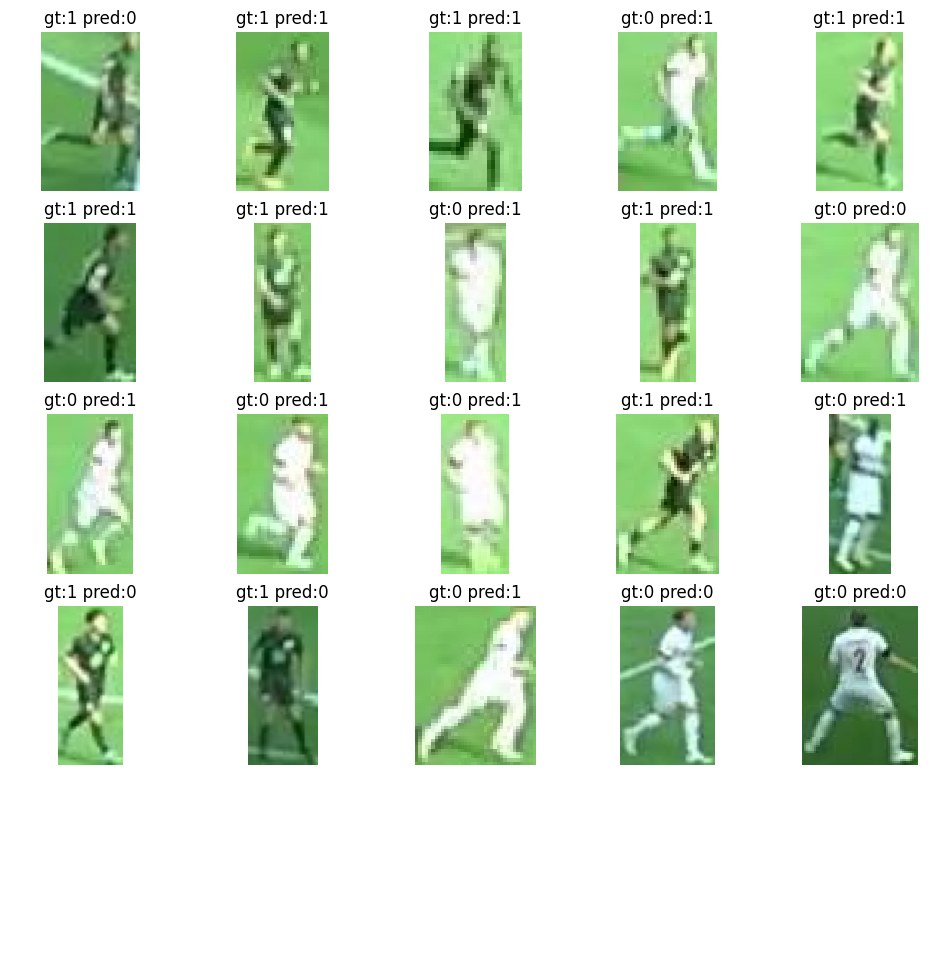

In [17]:
def display_for_id(id: int, exp: Experiment):
  image = cv2.imread(str(jpg_files[id]))
  players_crops = [sv.crop_image(image, xyxy) for xyxy in detections_list[id].xyxy]
  print("Score: ", exp.results_list[id])
  sv.plot_images_grid(players_crops, grid_size=(5,5),
                      titles = [f"gt:{i} pred:{j}" for i,j in zip(detections_list[id].class_id,exp.clusters_list[id])])

try:
  # display_for_id(np.argmax(exp.results_list), exp)
  display_for_id(np.argmin(exp.results_list), exp)
  # for id in range(len(exp.results_list)):
  #   display_for_id(id, exp)
except NameError:
  print("No experiment was run therfore the plot won't work")


# Evaluation


In [18]:
len(all_experiments_for_all_iterations[1])

NameError: name 'all_experiments_for_all_iterations' is not defined

### Prepare the data

In [19]:
all_experiments_for_all_iterations=[]
NUM_ITERATIONS_ARRAY = range(NUM_ITERATIONS)
for it in NUM_ITERATIONS_ARRAY:
  all_experiments_for_all_iterations.append(load_results_from_google_drive(it, is_iteration=True))

num_images = len(all_experiments_for_all_iterations[0][0].results_list)
rows = NUM_ITERATIONS * num_images
accuracy_array = np.zeros((rows, len(VERSIONS_TO_TEST)))
accuracy_array_3D = np.zeros((len(VERSIONS_TO_TEST), NUM_ITERATIONS, num_images))
exec_time_array = np.zeros((rows, len(VERSIONS_TO_TEST)))
total_exec_time_array = np.zeros((rows, len(VERSIONS_TO_TEST)))
model_name_list = []

for i_exp in range(len(all_experiments_for_all_iterations[0])): # for experiment, every batch has the same amount of methods in it
  for i_batch in range(len(all_experiments_for_all_iterations)): # for iteration
    try:
      current_exp = all_experiments_for_all_iterations[i_batch][i_exp]
      accuracy_array[i_batch*num_images:(i_batch+1)*num_images,i_exp] = current_exp.results_list
      accuracy_array_3D[i_exp,i_batch,:] = current_exp.results_list
      exec_time_array[i_batch*num_images:(i_batch+1)*num_images,i_exp] = current_exp.execution_time_list
      total_exec_time_array[i_batch*num_images:(i_batch+1)*num_images,i_exp] = current_exp.total_execution_time_list
    except:
      print(f"i_batch, {i_batch}")
      print(f"i_exp, {i_exp}")
      print("An exception occurred")

  model_name_list.append(current_exp.model_path)

mean_total_exec_speed_array = 1/np.mean(total_exec_time_array, axis=0)


# Prepare naming for the plots
method_names = model_name_list
method_names = [name.split('/')[-1] for name in method_names] # remove everything before the forward slash
method_names = [name.replace('base', 'b').replace('large', 'l').replace('resnet', 'ResNet').replace('siglip', 'SigLip').replace('clip', 'CLIP').replace('patch', 'p').replace('-vit', '') for name in method_names] # rename the parts of the names
colors = [ 'c' if 'SigLip2' in name else 'g' if 'SigLip' in name else 'r' if 'ResNet' in name else 'b' for name in method_names]
markers = ['s' if 'SigLip2' in name else 'o' if 'SigLip' in name else '*' if 'ResNet' in name else 'x' for name in method_names]


## Boxplots with accuracy and total execution time

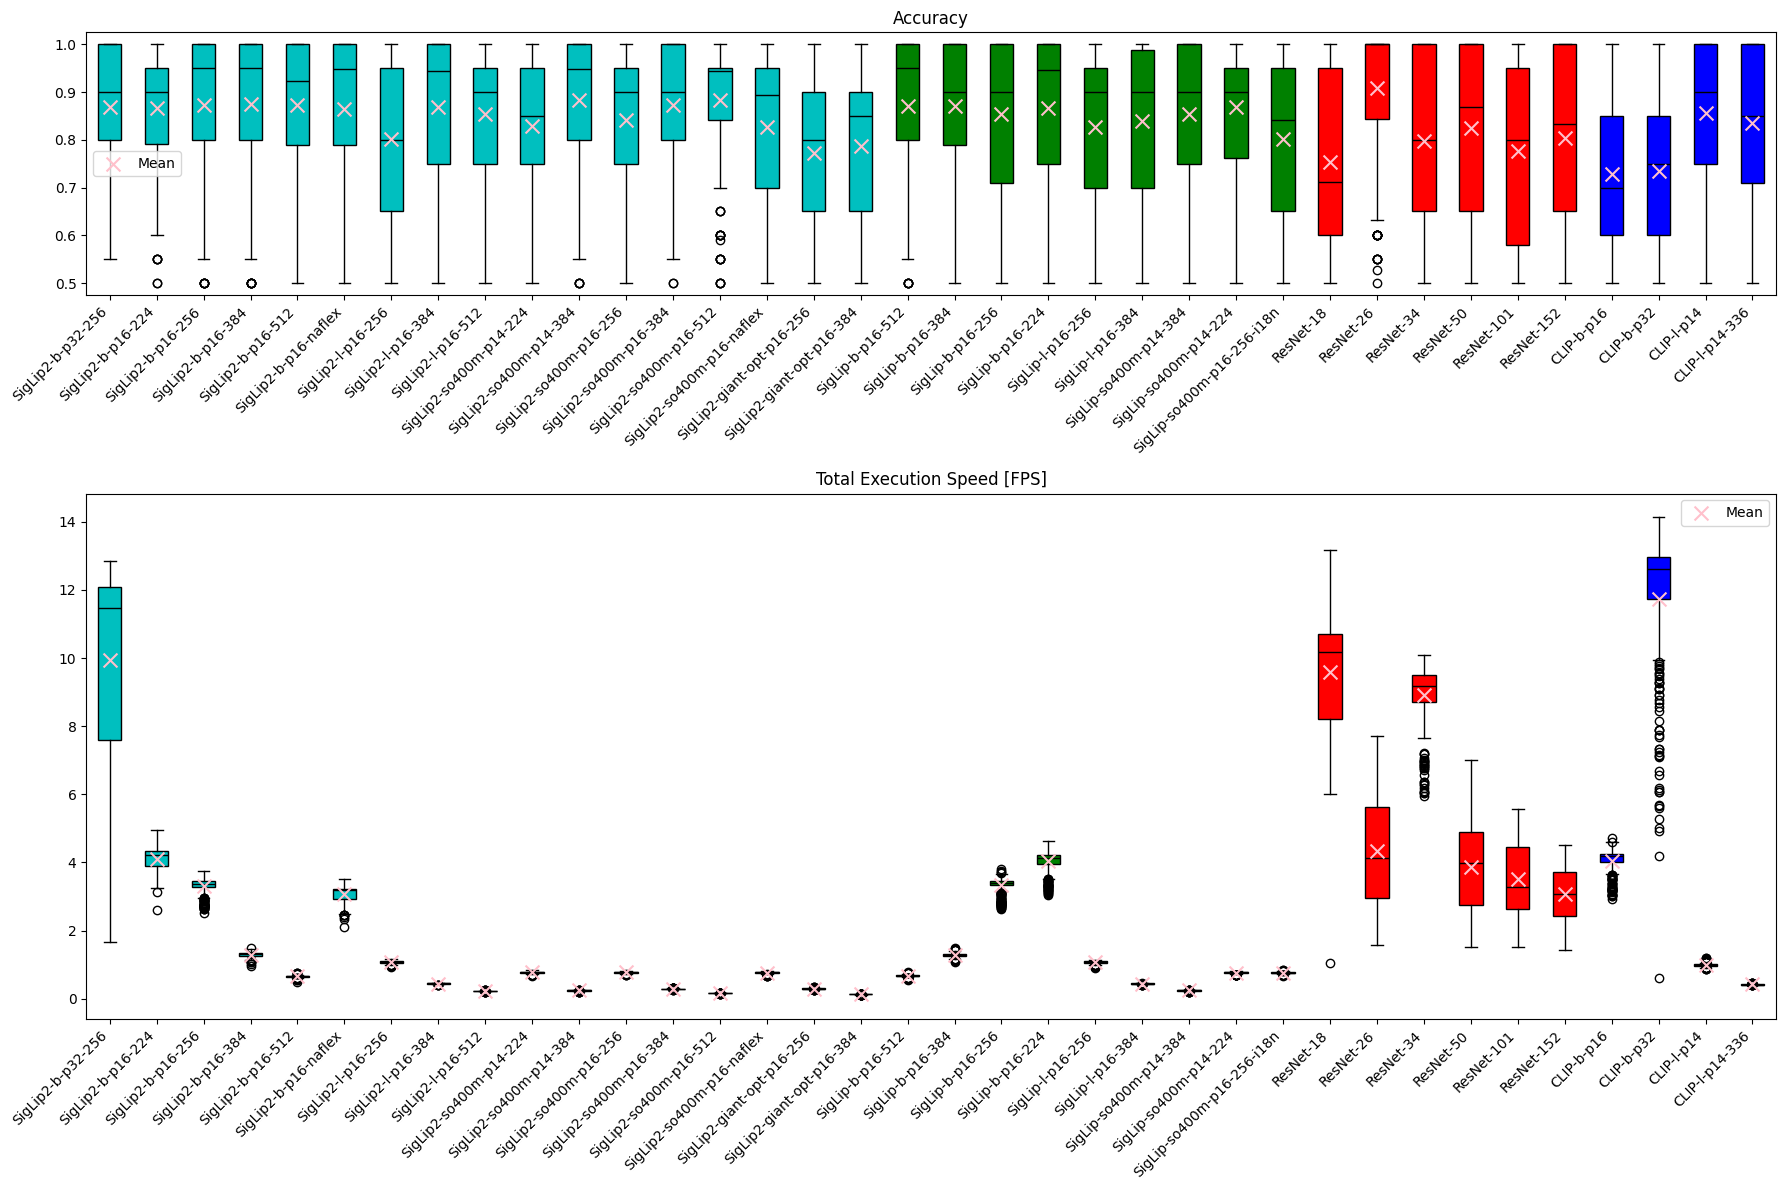

In [20]:
# Create a figure and axes for the boxplots
fig, axes = plt.subplots(2, 1, figsize=(18, 12), gridspec_kw={'height_ratios': [1, 2]})  # Adjust height ratios


# --- Accuracy ---
bp1 = axes[0].boxplot(accuracy_array, patch_artist=True, medianprops=dict(color="black")) # patch_artist=True to be able to color the boxes
axes[0].set_title('Accuracy')
axes[0].set_xticklabels(method_names, rotation=45, ha='right')
for box, color in zip(bp1['boxes'], colors):
    box.set_facecolor(color)


# --- Total Execution Time ---
bp3 = axes[1].boxplot(1/total_exec_time_array, patch_artist=True, medianprops=dict(color="black"))
axes[1].set_title('Total Execution Speed [FPS]')
axes[1].set_xticklabels(method_names, rotation=45, ha='right')
for box, color in zip(bp3['boxes'], colors):
    box.set_facecolor(color)
# axes[0].grid(True)
# axes[1].grid(True)


# Calculate and plot average values for Accuracy
means_acc = np.mean(accuracy_array, axis=0)
axes[0].scatter(np.arange(1, len(method_names) + 1), means_acc, marker='x', color='pink', s=100, label='Mean', zorder=10)
means_total_exec = np.mean(1/total_exec_time_array, axis=0)
axes[1].scatter(np.arange(1, len(method_names) + 1), means_total_exec, marker='x', color='pink', s=100, label='Mean', zorder=10)


for ax in axes:
  ax.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

### Summary: Mean Results Plot

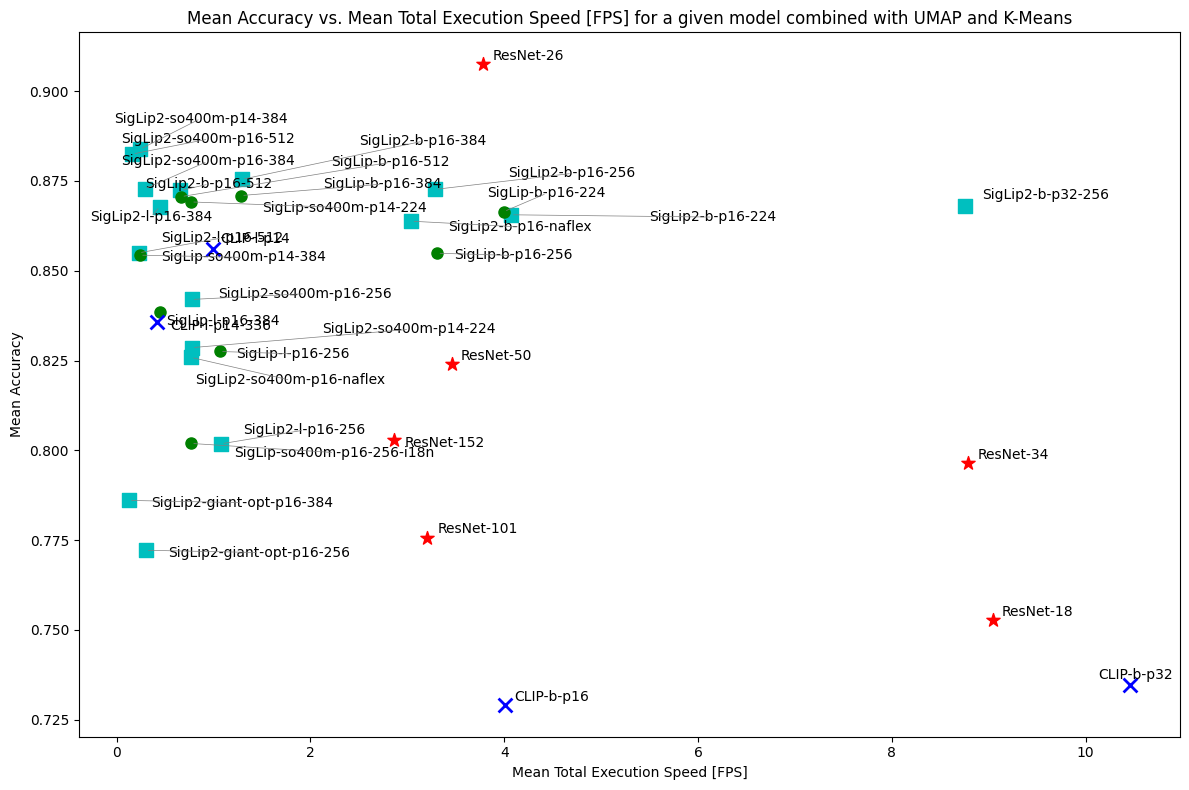

In [21]:
# Calculate mean accuracy for each model
mean_accuracy_array = np.mean(accuracy_array, axis=0)

# Create the scatter plot
fig, ax = plt.subplots(figsize=(12, 8))


for i in range(len(method_names)):
    markersize = 8 if markers[i] == 'o' else 10  # Smaller circles
    linewidth = 2 if markers[i] == 'x' else 1  # Thicker crosses
    ax.scatter(mean_total_exec_speed_array[i], mean_accuracy_array[i],
               color=colors[i], marker=markers[i], label=method_names[i],
               s=markersize**2, linewidth=linewidth)  # s=markersize**2 for area scaling

# Use adjust_text to prevent label overlap
texts = []
siglip_crowded = []
for i, txt in enumerate(method_names):
    # if 'SigLip' in txt and 'SigLip-b' not in txt:
    if 'SigLip' in txt:
      siglip_crowded.append(ax.text(mean_total_exec_speed_array[i], mean_accuracy_array[i], txt))
    else:
      texts.append(ax.text(mean_total_exec_speed_array[i], mean_accuracy_array[i], txt))

adjust_text(texts,
            expand_points=(2, 2),  # Increase space around points
            autoalign='y', # Align vertically
            only_move={'points':'y', 'texts':'y'}, # Only move in y direction
            )
adjust_text(siglip_crowded,
            expand_points=(2, 2),  # Increase space around points
            arrowprops=dict(arrowstyle="-", color='gray', lw=0.5), # Add gray arrows
            autoalign='y', # Align vertically
            only_move={'points':'y', 'texts':'y'}, # Only move in y direction
            )

# Set plot labels and title
ax.set_xlabel('Mean Total Execution Speed [FPS]')
ax.set_ylabel('Mean Accuracy')
ax.set_title('Mean Accuracy vs. Mean Total Execution Speed [FPS] for a given model combined with UMAP and K-Means')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Repeatability

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


Mean accuracy diff:  3.198315210571737
Mean time diff:  6.5192611978797395
Max accuracy diff:  8.398393082346152
Max time diff:  52.94766634398884
Min accuracy diff:  0.6965194217879156
Min time diff:  0.27248182852686054


set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


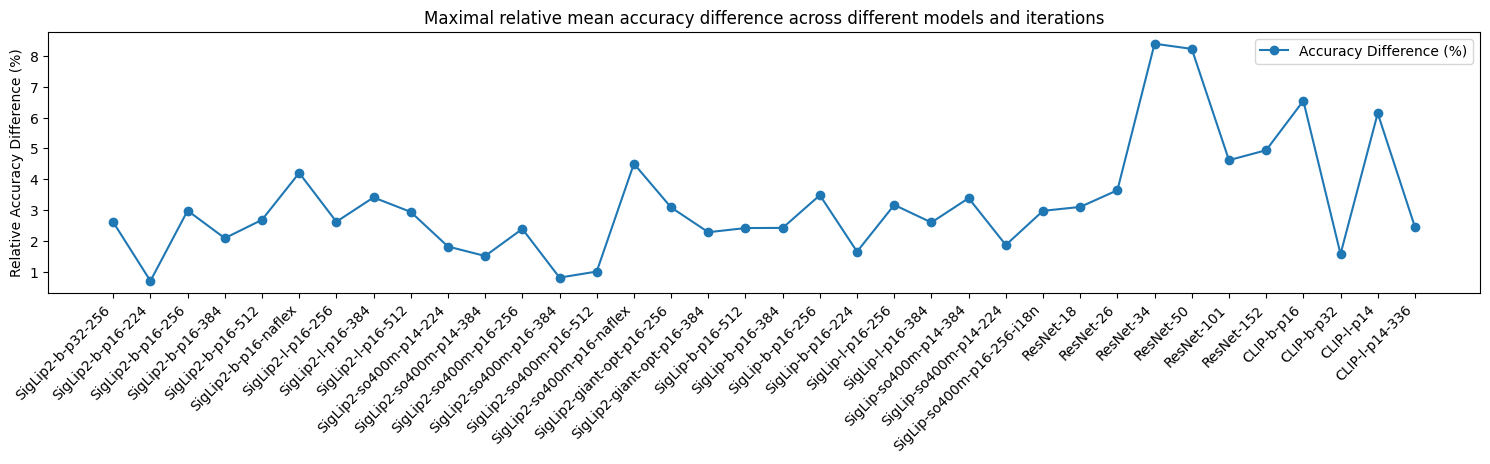

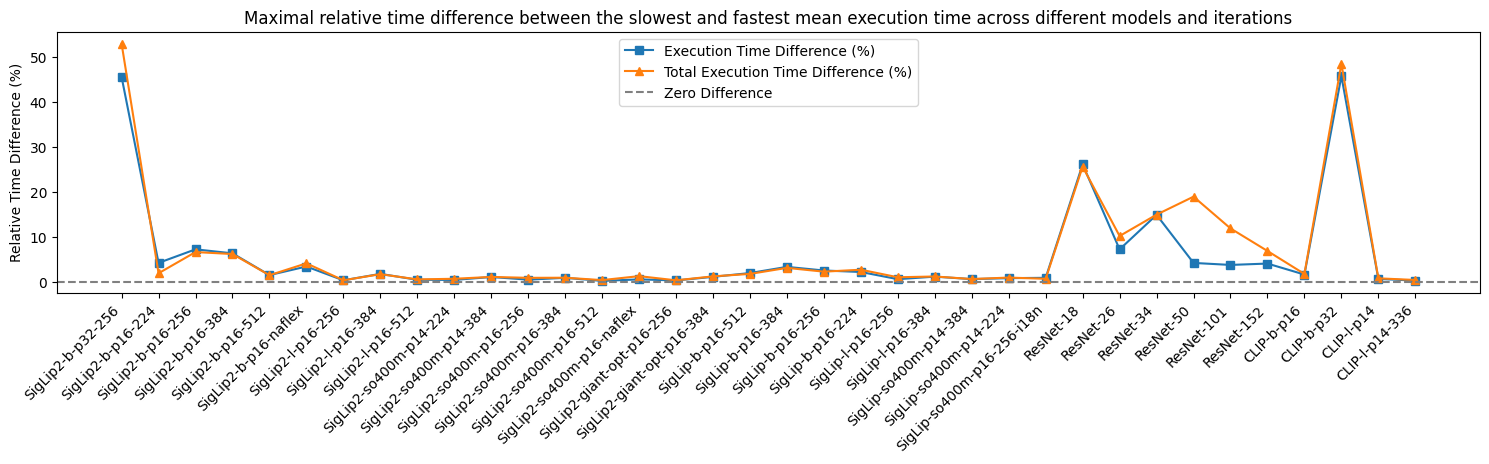

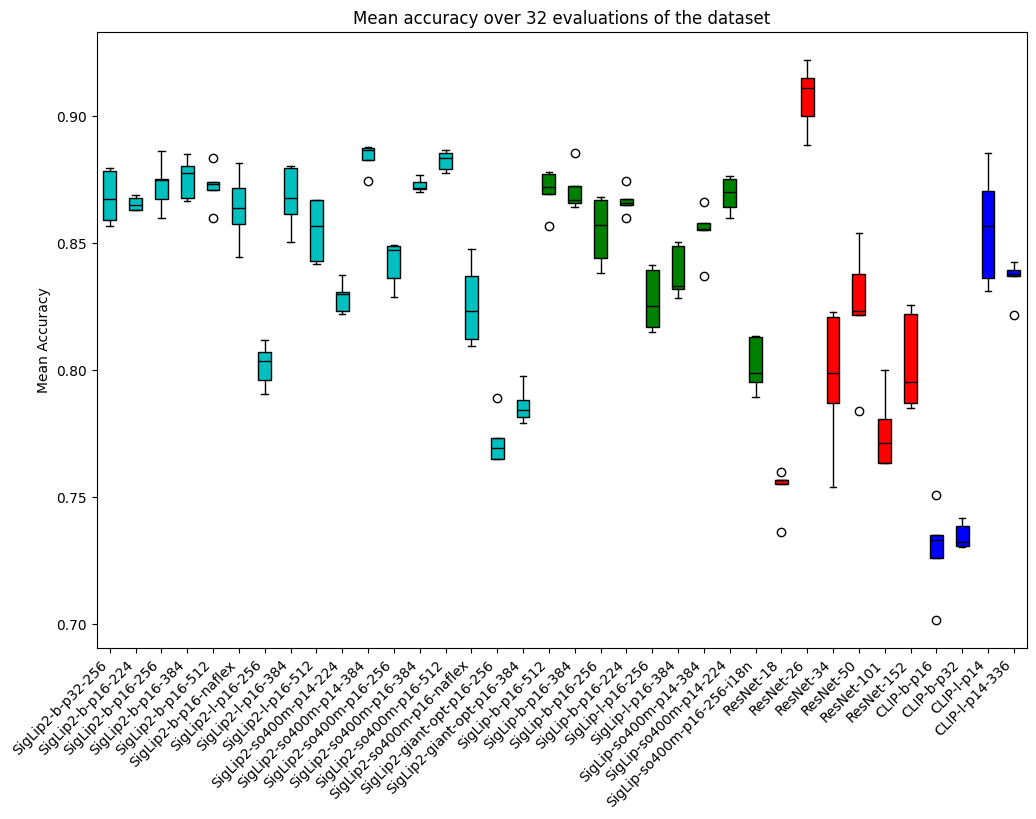

In [22]:
all_experiments_for_all_iterations=[]
NUM_ITERATIONS_ARRAY = range(NUM_ITERATIONS)
for it in NUM_ITERATIONS_ARRAY:
  all_experiments_for_all_iterations.append(load_results_from_google_drive(it, is_iteration=True))

# Settings
show_plot_for_each_exp = False
show_percentage_differences = True
show_percentage_differences_text = False

accuracy_diff_list = []
exec_time_diff_list = []
total_exec_time_diff_list = []
model_name_list = []

for i_exp in range(len(all_experiments_for_all_iterations[0])): # for experiment, every batch has the same amount of methods in it
  mean_results_list = []
  mean_exec_time_list = []
  mean_total_exec_time_list = []
  for i_batch in range(len(all_experiments_for_all_iterations)): # for iteration
    current_exp = all_experiments_for_all_iterations[i_batch][i_exp]
    mean_results_list.append(np.mean(current_exp.results_list))
    mean_exec_time_list.append(np.mean(current_exp.execution_time_list))
    mean_total_exec_time_list.append(np.mean(current_exp.total_execution_time_list))

  if show_plot_for_each_exp:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns
    ax1.plot(NUM_ITERATIONS_ARRAY, mean_results_list, label="Mean Accuracy")
    ax1.set_xlabel('Batch Size')
    ax1.set_ylabel('Mean Accuracy')
    ax1.legend()

    ax2.plot(NUM_ITERATIONS_ARRAY, mean_exec_time_list, label="Mean Exec time")
    ax2.plot(NUM_ITERATIONS_ARRAY, mean_total_exec_time_list, label="Mean Total Exec time")
    ax2.set_xlabel('Batch Size')
    ax2.set_ylabel('Mean Execution Time')
    ax2.legend()

    fig.suptitle("Influence of Batch Size on Performance for " + current_exp.model_path, fontsize=16)
    plt.show()

  if show_percentage_differences:
    mean_results_list = np.array(mean_results_list)
    mean_exec_time_list = np.array(mean_exec_time_list)
    mean_total_exec_time_list = np.array(mean_total_exec_time_list)

    accuracy_diff = ((np.max(mean_results_list) - np.min(mean_results_list)) / np.max(mean_results_list)) * 100
    exec_time_diff = ((np.max(mean_exec_time_list) - np.min(mean_exec_time_list)) / np.max(mean_exec_time_list)) * 100
    total_exec_time_diff = ((np.max(mean_total_exec_time_list) - np.min(mean_total_exec_time_list)) / np.max(mean_total_exec_time_list)) * 100

    accuracy_diff_list.append(accuracy_diff)
    exec_time_diff_list.append(exec_time_diff)
    total_exec_time_diff_list.append(total_exec_time_diff)
    model_name_list.append(current_exp.model_path)
    if show_percentage_differences_text:
      print(current_exp.model_path)
      print("Accuracy difference: ", accuracy_diff)
      print("Execution time difference: ", exec_time_diff)
      print("Total execution time difference: ", total_exec_time_diff)

if show_percentage_differences:
  fig, ax = plt.subplots(figsize=(15, 6))
  ax.plot(model_name_list, accuracy_diff_list, label="Accuracy Difference (%)", marker='o')
  # ax.set_xlabel("Model Name")
  ax.set_ylabel("Relative Accuracy Difference (%)")
  ax.set_title("Maximal relative mean accuracy difference across different models and iterations")
  ax.legend()
  plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
  plt.tight_layout()  # Adjust layout to prevent overlapping elements
  ax.set_xticklabels(method_names, rotation=45, ha='right')

  print("Mean accuracy diff: ", np.mean(accuracy_diff_list))
  print("Mean time diff: ", np.mean(total_exec_time_diff_list))
  print("Max accuracy diff: ", np.max(accuracy_diff_list))
  print("Max time diff: ", np.max(total_exec_time_diff_list))
  print("Min accuracy diff: ", np.min(accuracy_diff_list))
  print("Min time diff: ", np.min(total_exec_time_diff_list))


  fig, ax = plt.subplots(figsize=(15, 6))
  ax.plot(model_name_list, exec_time_diff_list, label="Execution Time Difference (%)", marker='s')
  ax.plot(model_name_list, total_exec_time_diff_list, label="Total Execution Time Difference (%)", marker='^')
  ax.axhline(y=0, color='gray', linestyle='--', label="Zero Difference") # Line at y=0
  # ax.set_xlabel("Model Name")
  ax.set_ylabel("Relative Time Difference (%)")
  ax.set_title("Maximal relative time difference between the slowest and fastest mean execution time across different models and iterations")
  ax.legend()
  plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
  plt.tight_layout()  # Adjust layout to prevent overlapping elements
  ax.set_xticklabels(method_names, rotation=45, ha='right')


  #boxplot of the mean_acc vs. method_names
  mean_acc = np.mean(accuracy_array_3D, axis=2)
  fig, ax = plt.subplots(figsize=(12, 8))
  bp = ax.boxplot(mean_acc.T, patch_artist=True, medianprops=dict(color="black"))
  ax.set_ylabel("Mean Accuracy")
  ax.set_title('Mean accuracy over 32 evaluations of the dataset')
  ax.set_xticklabels(method_names, rotation=45, ha='right')
  for box, color in zip(bp['boxes'], colors):
      box.set_facecolor(color)


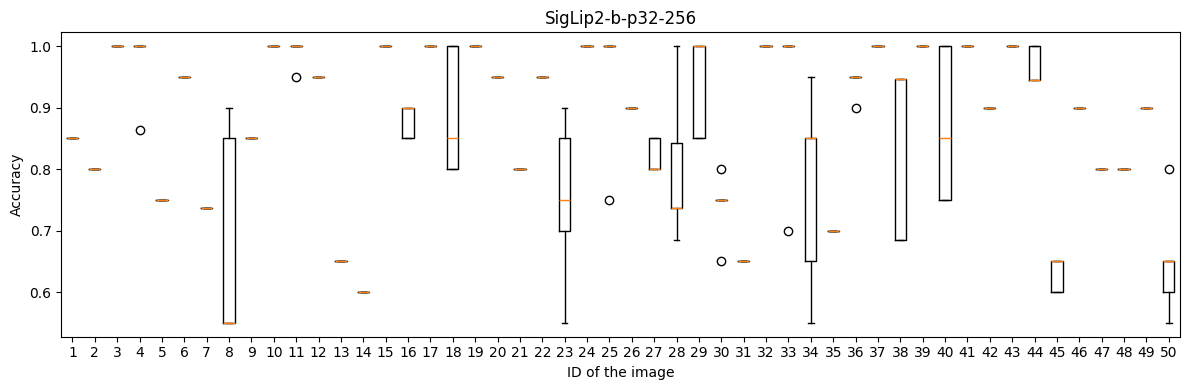

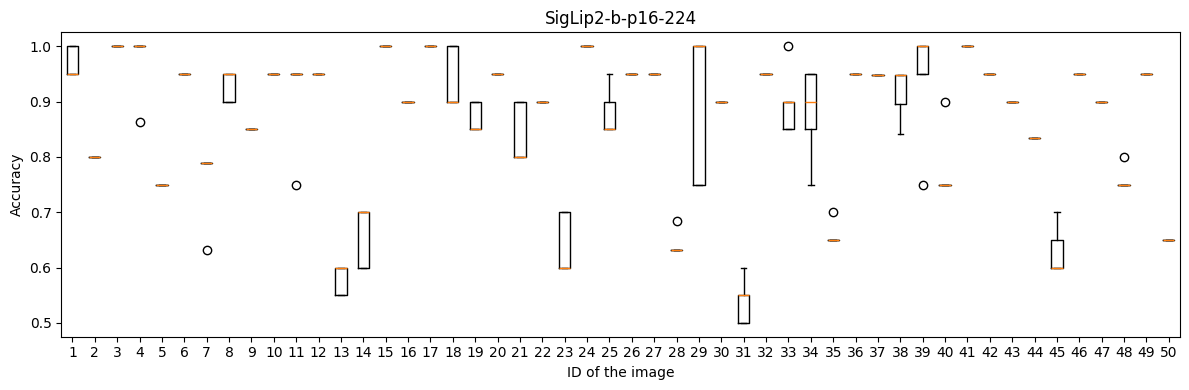

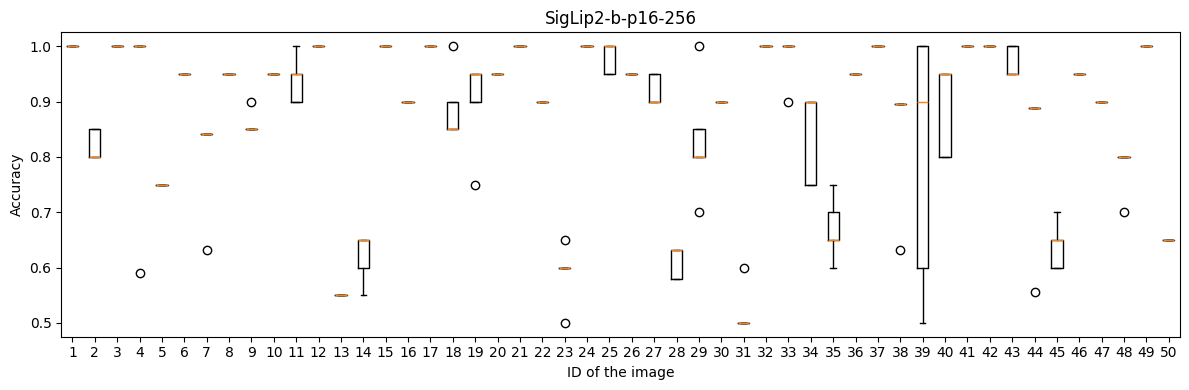

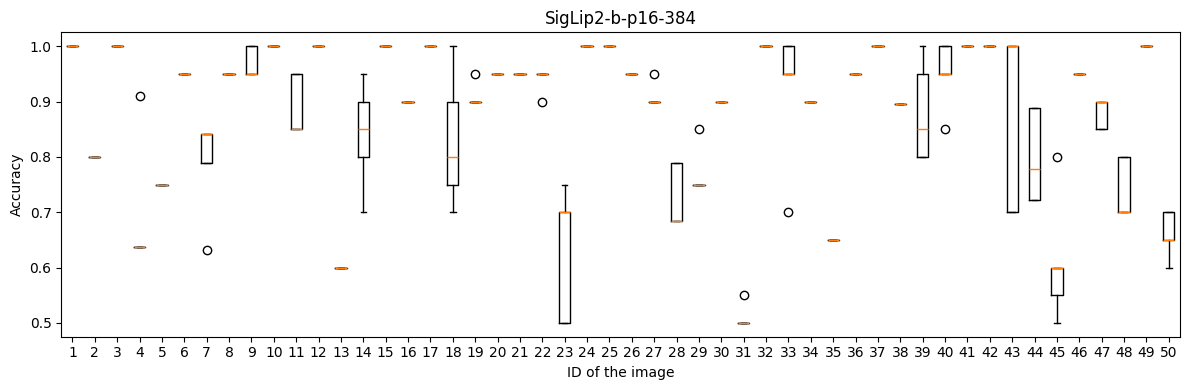

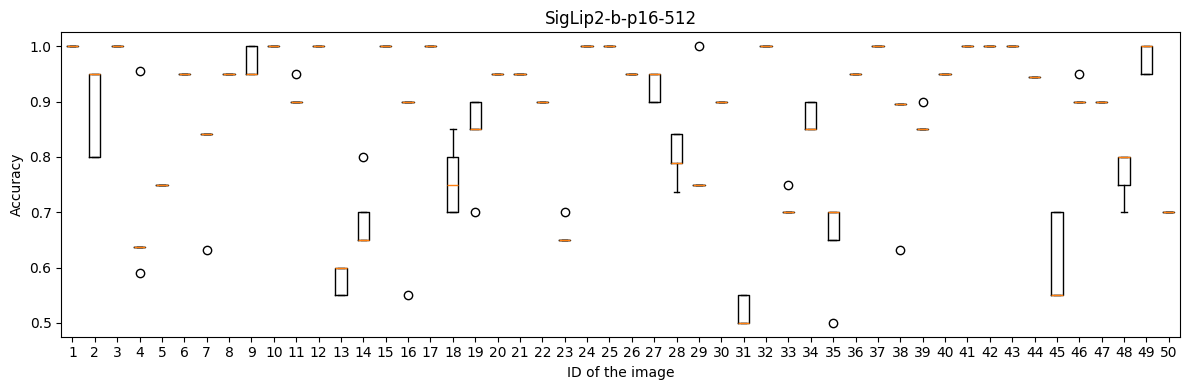

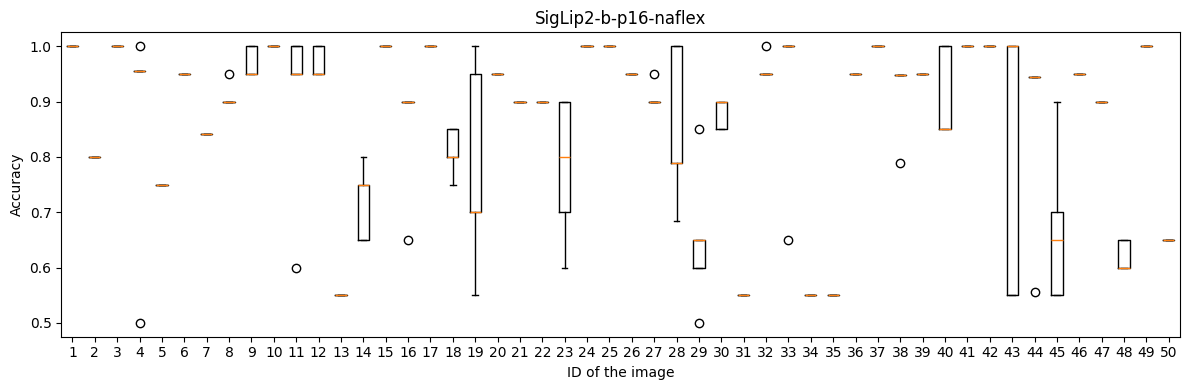

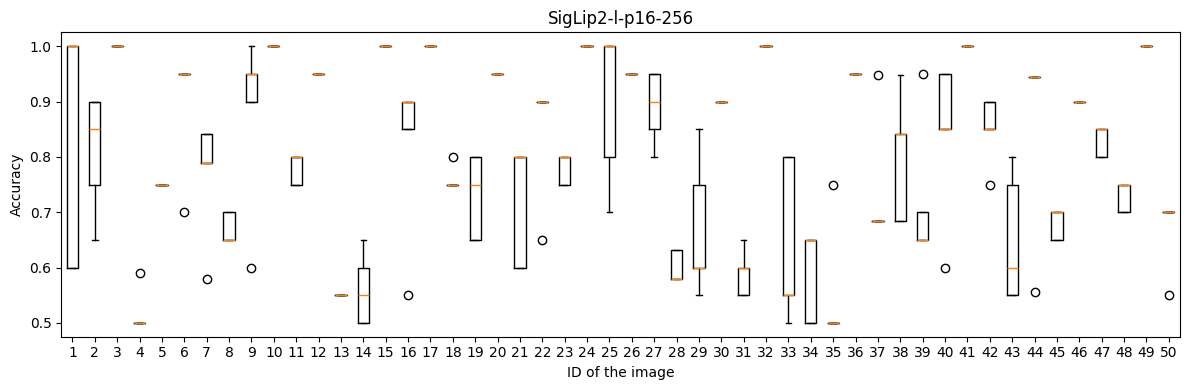

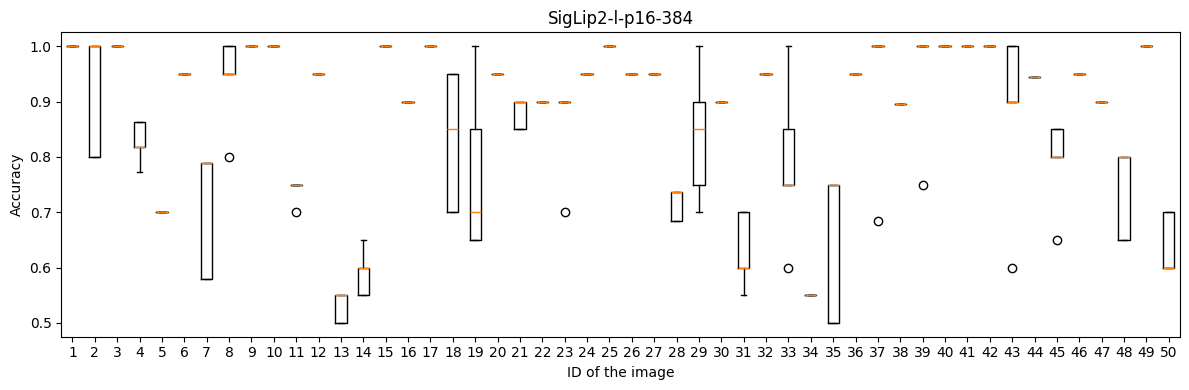

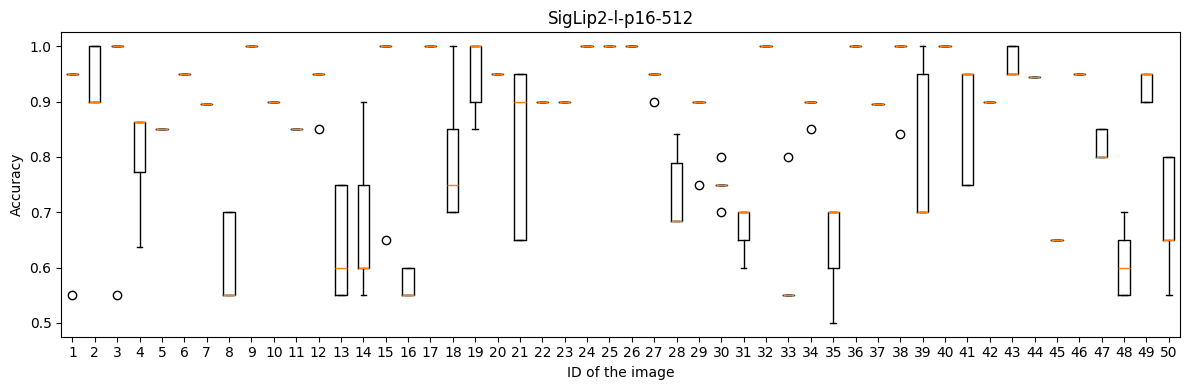

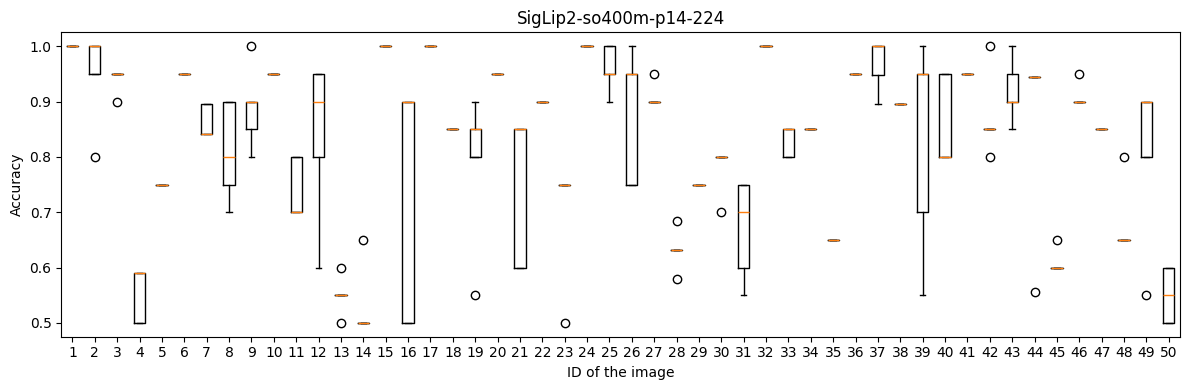

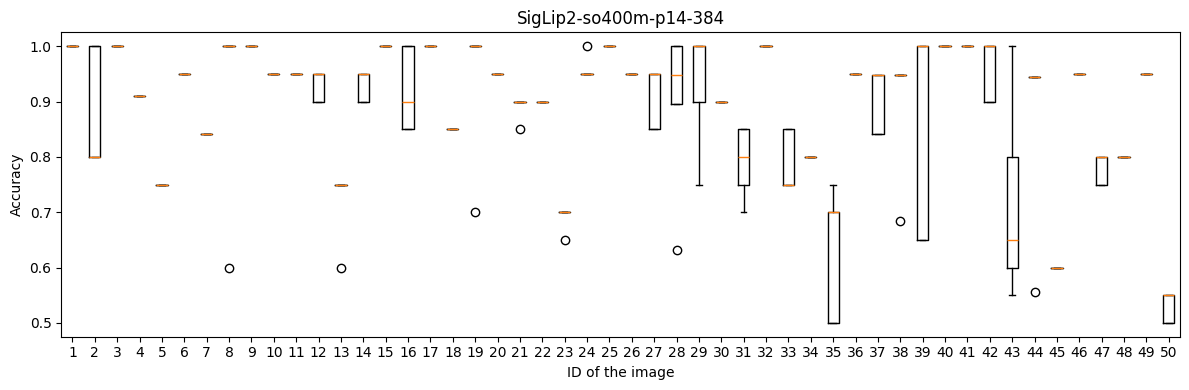

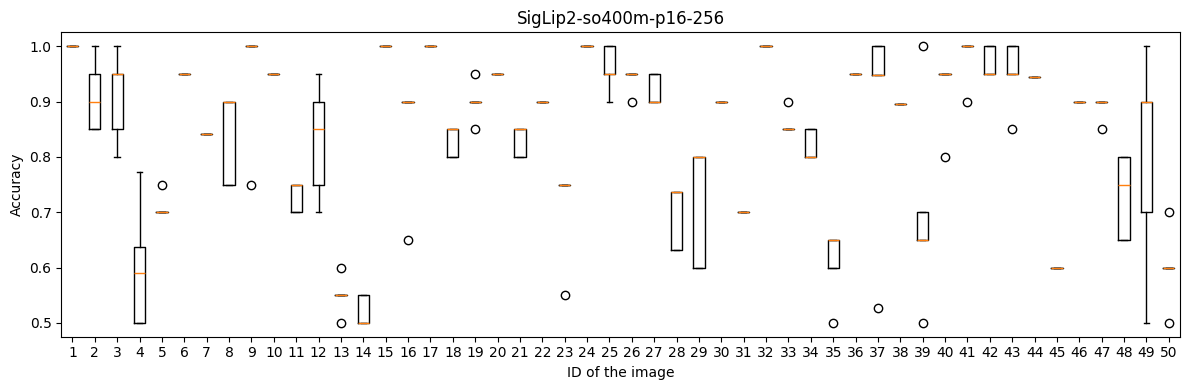

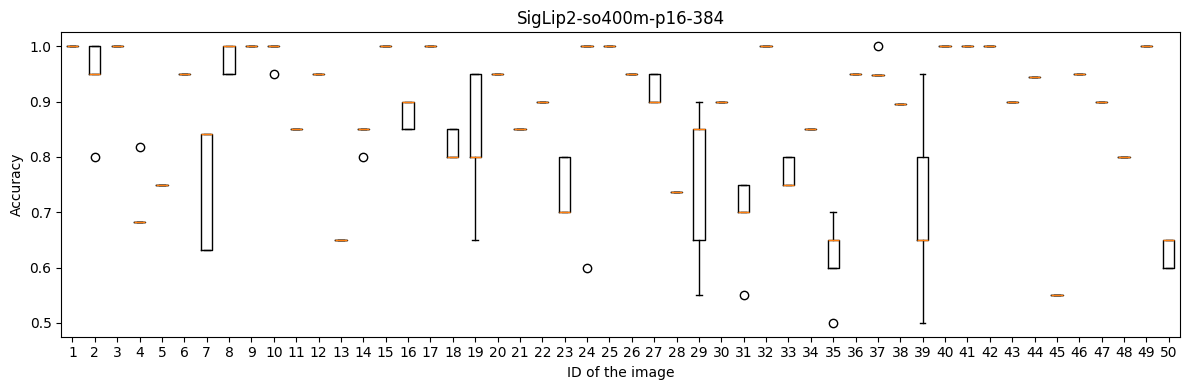

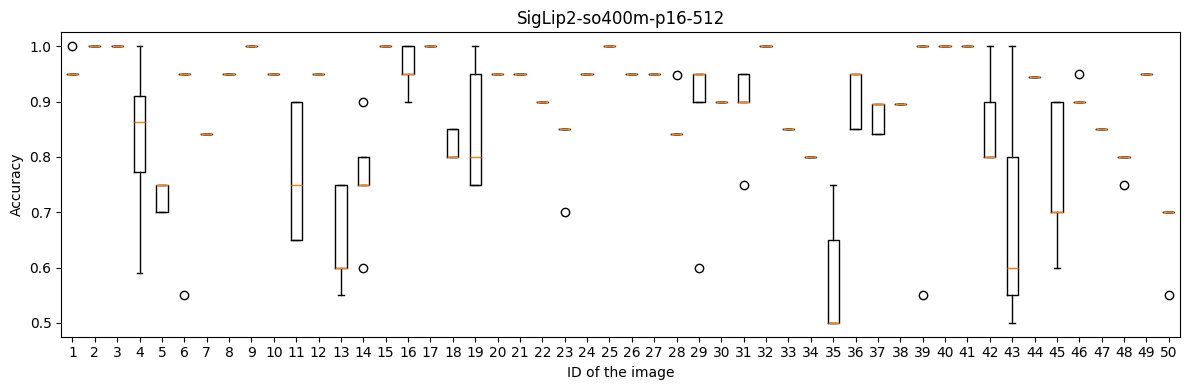

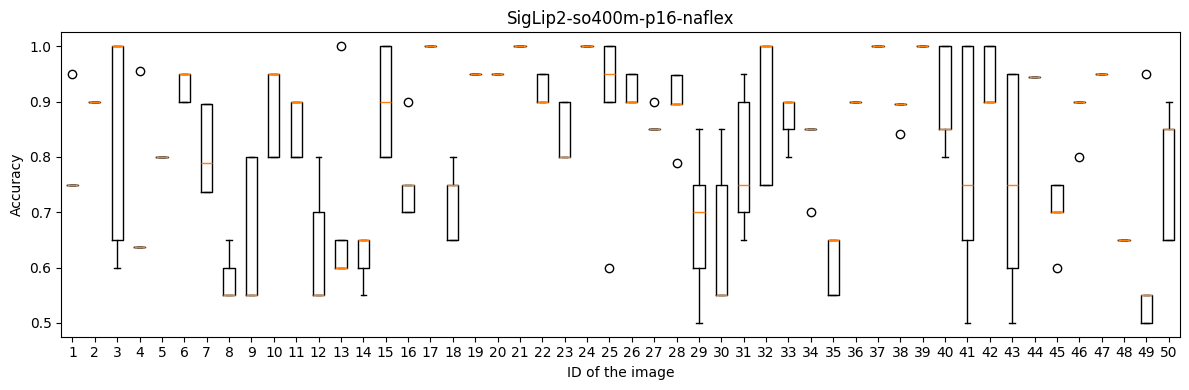

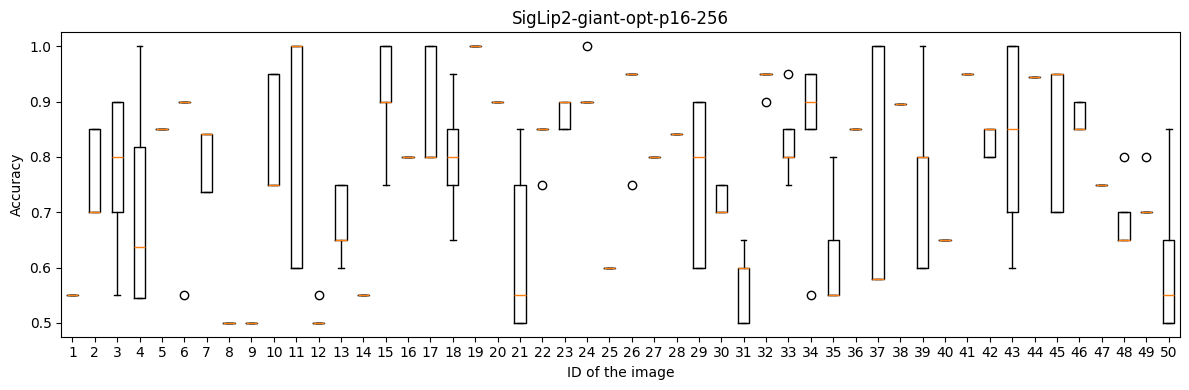

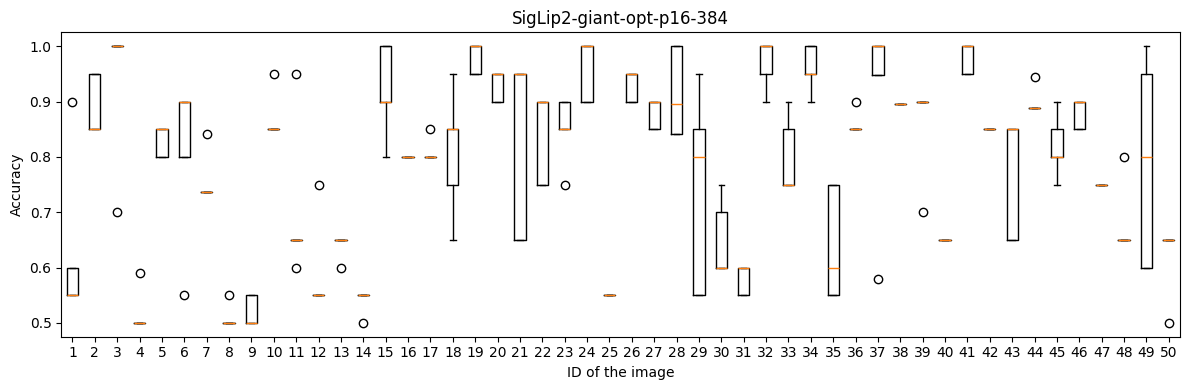

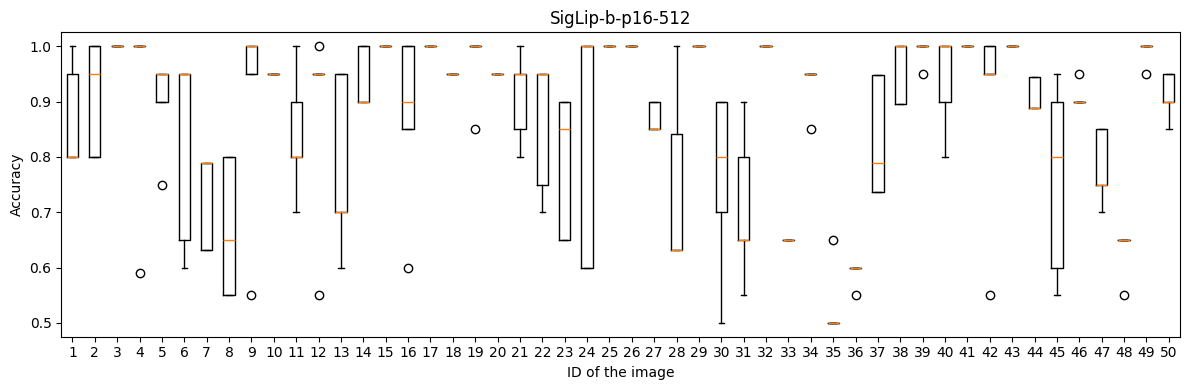

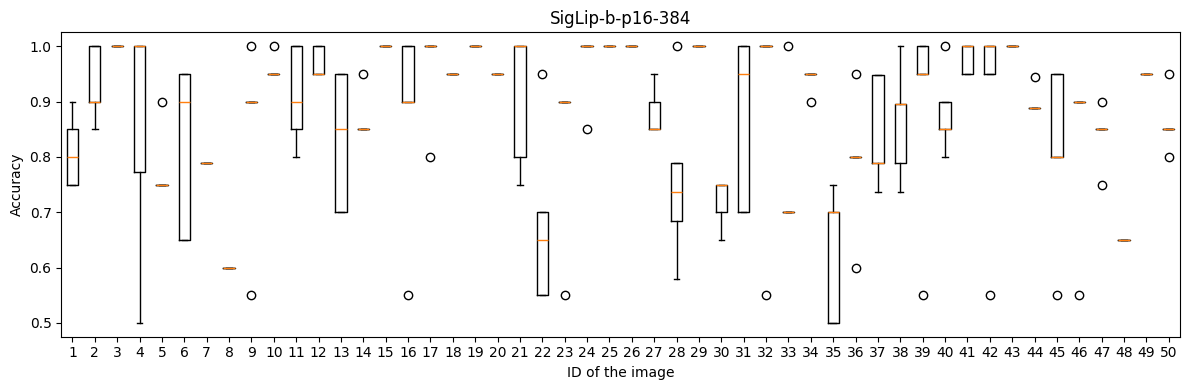

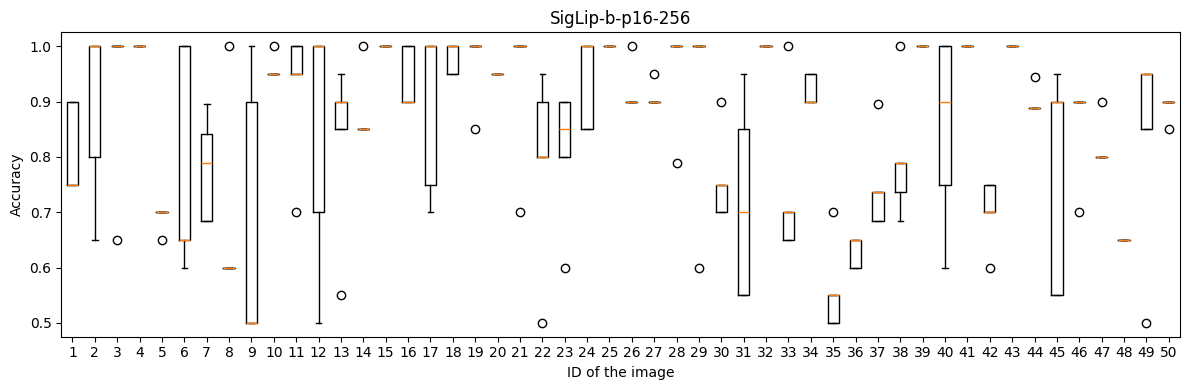

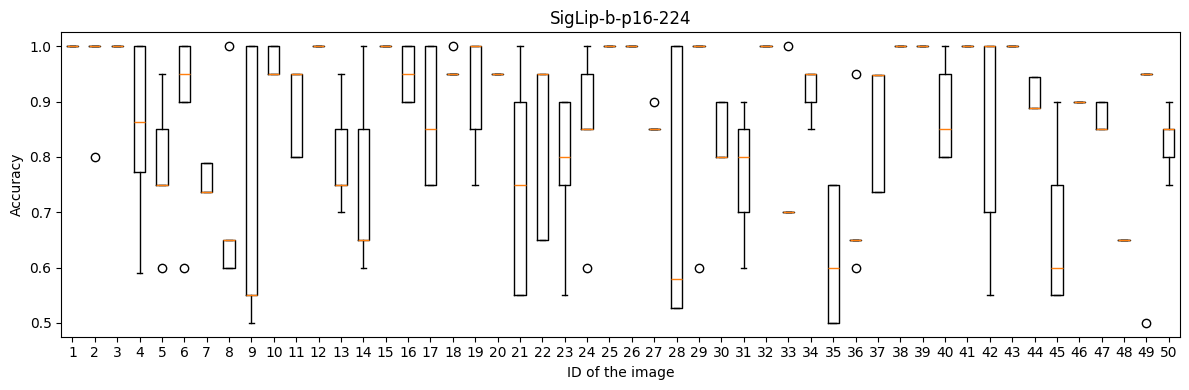

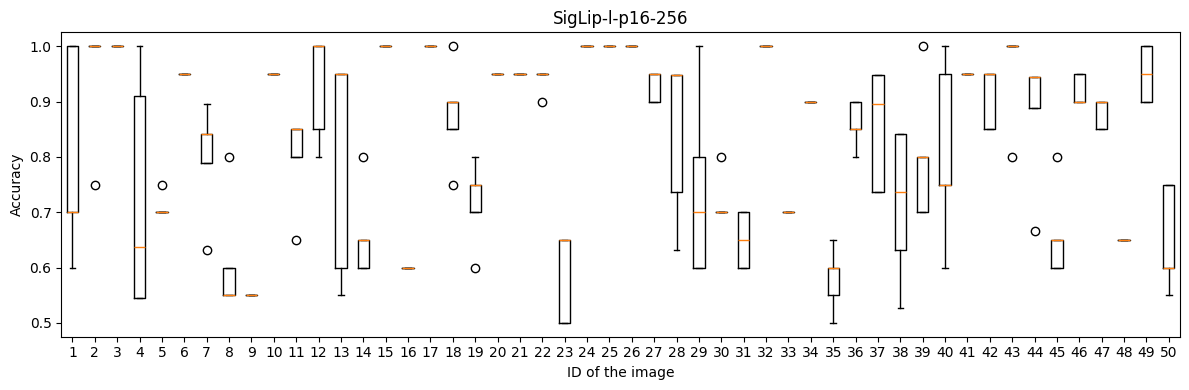

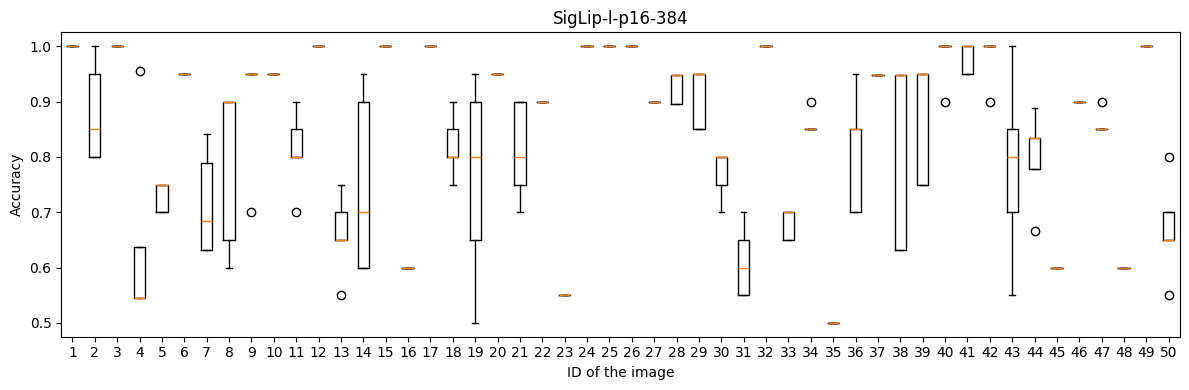

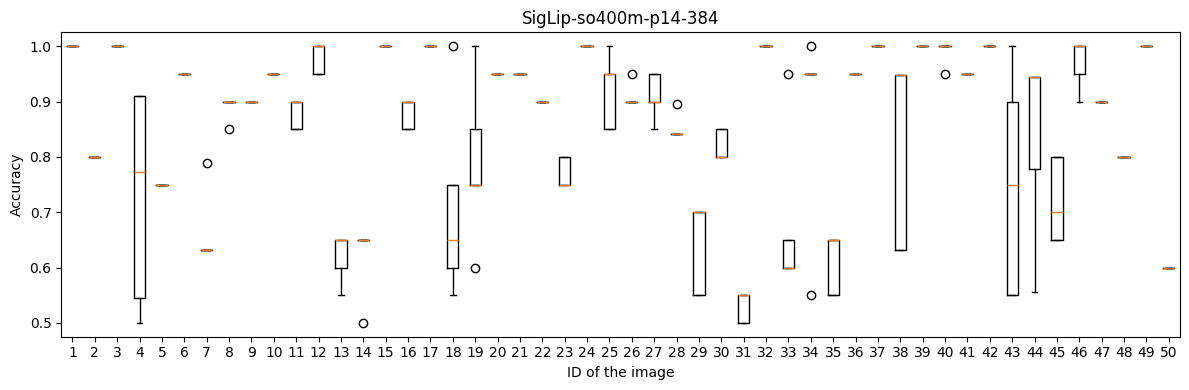

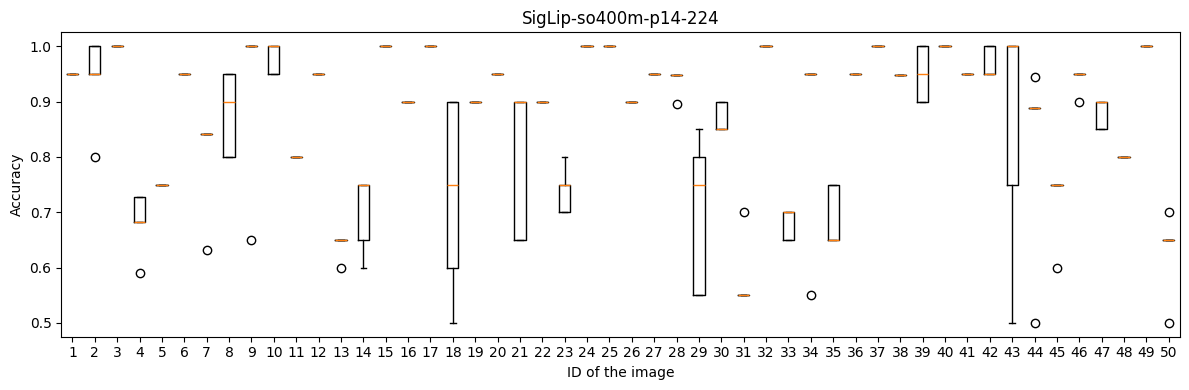

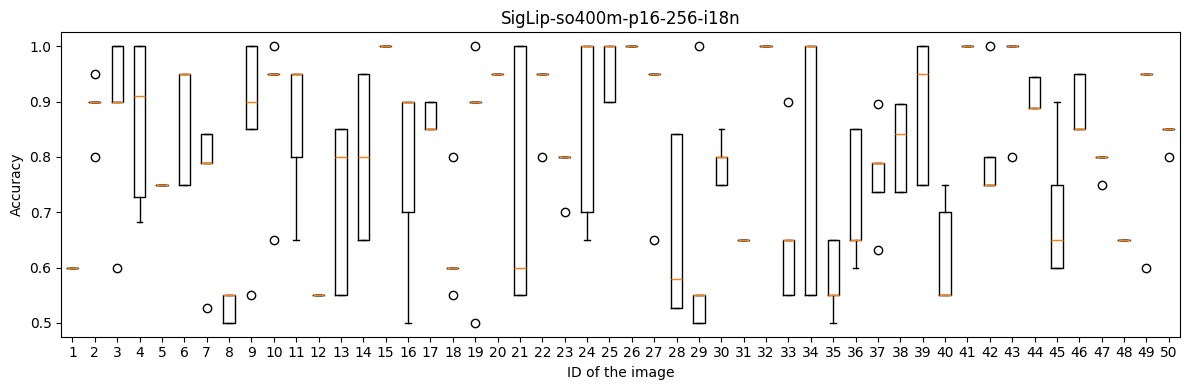

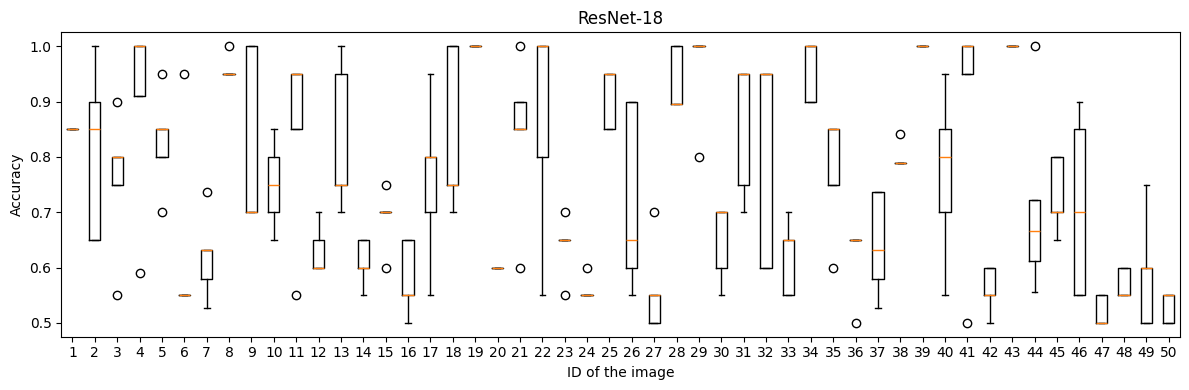

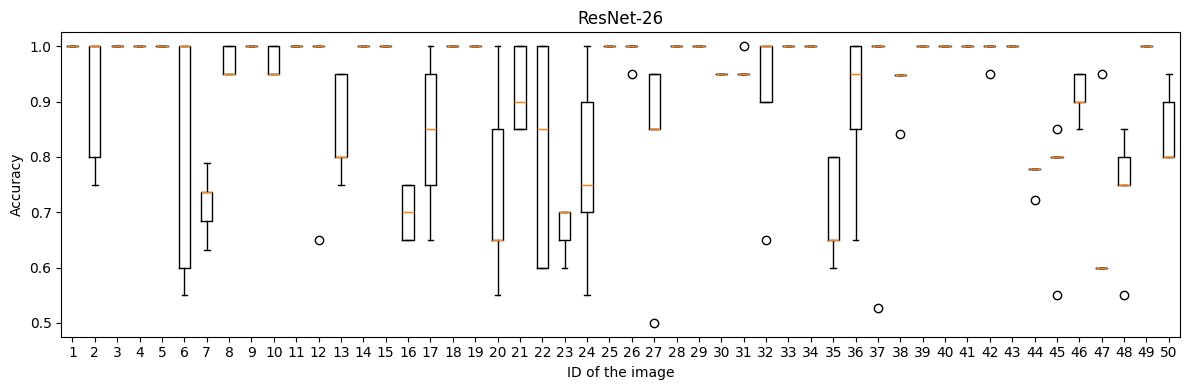

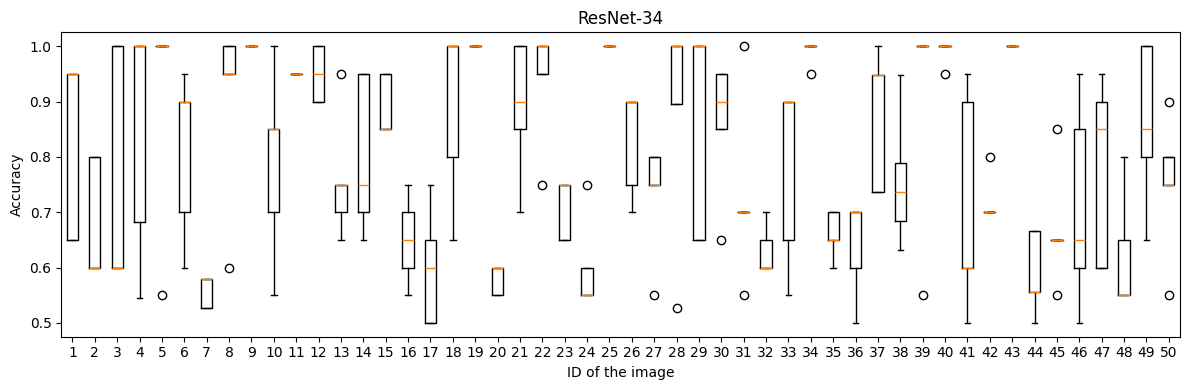

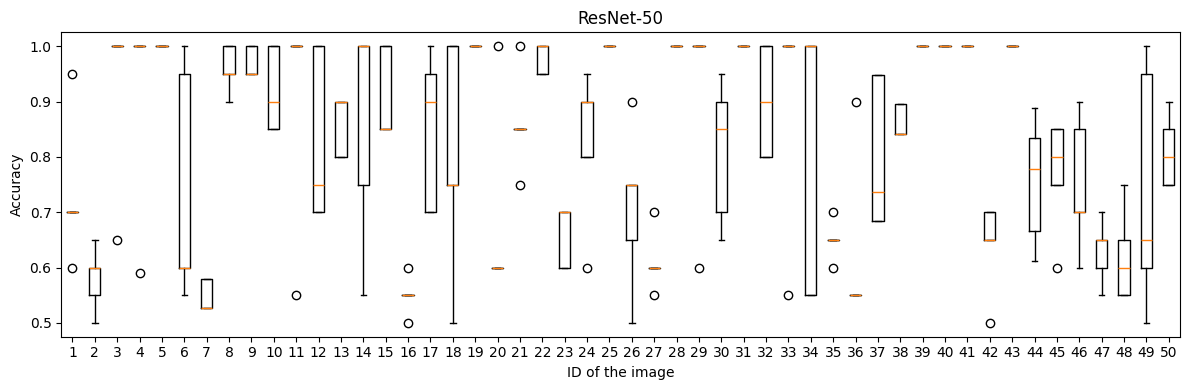

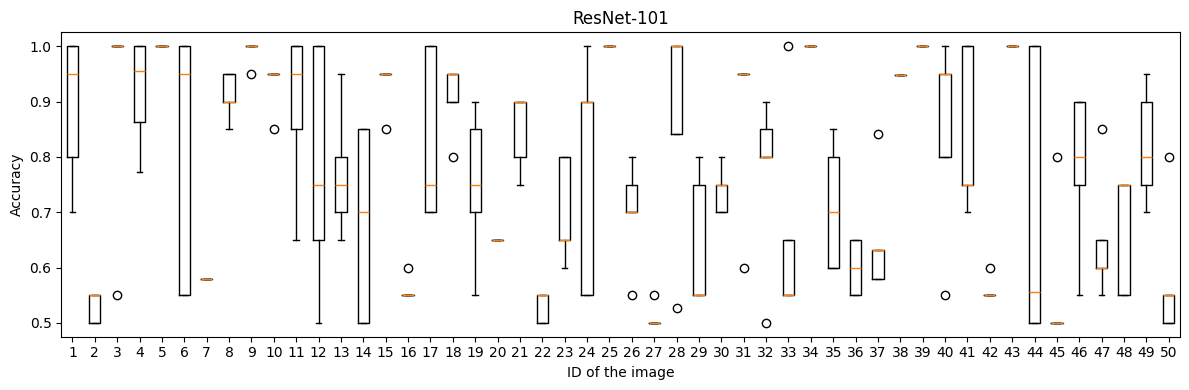

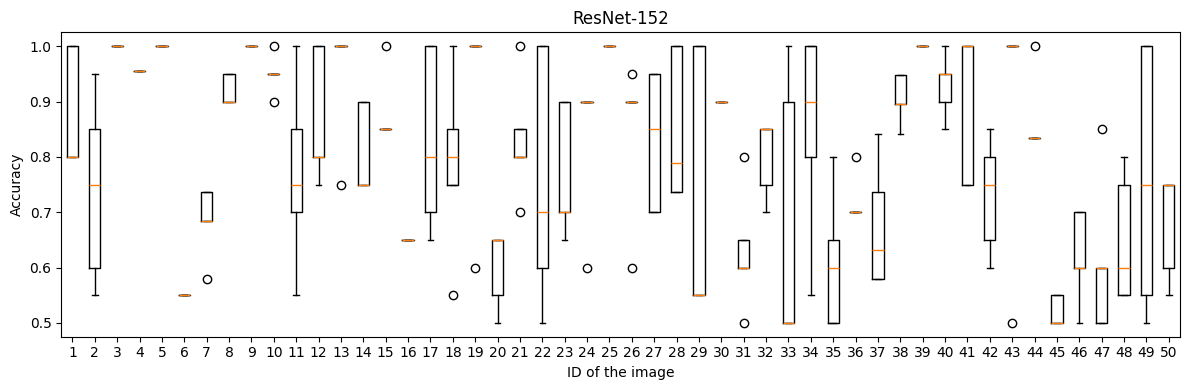

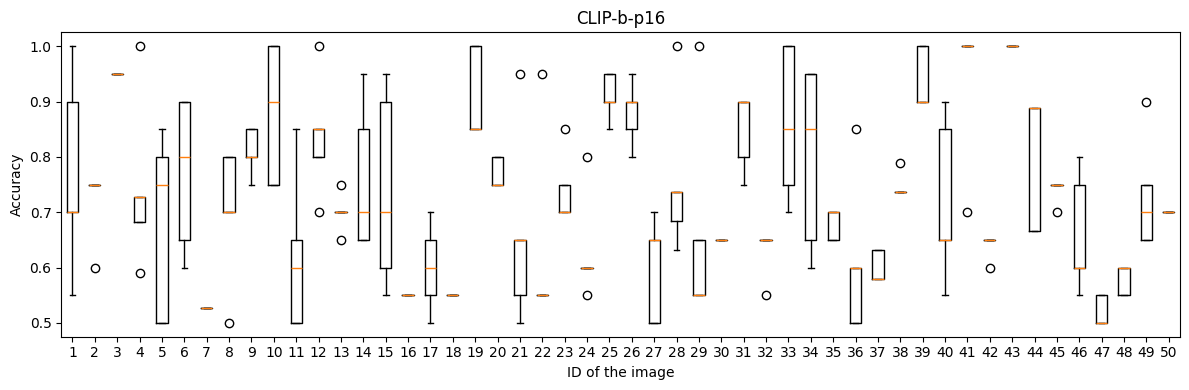

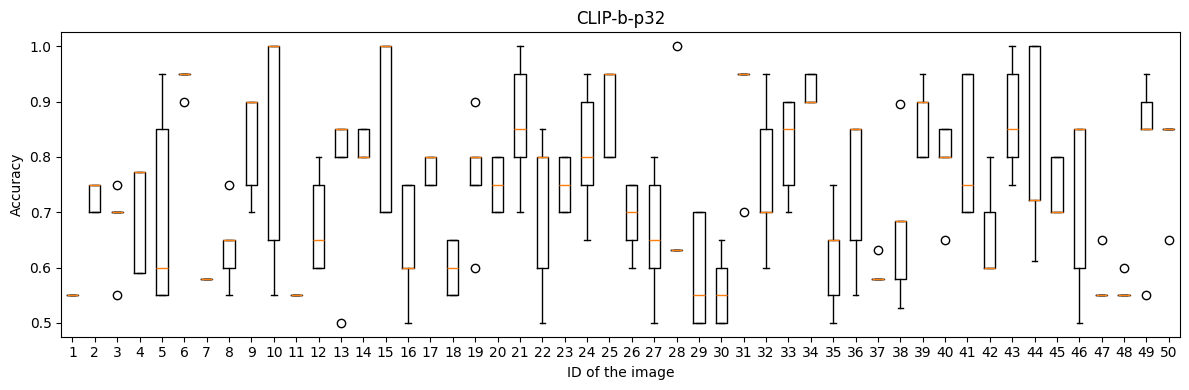

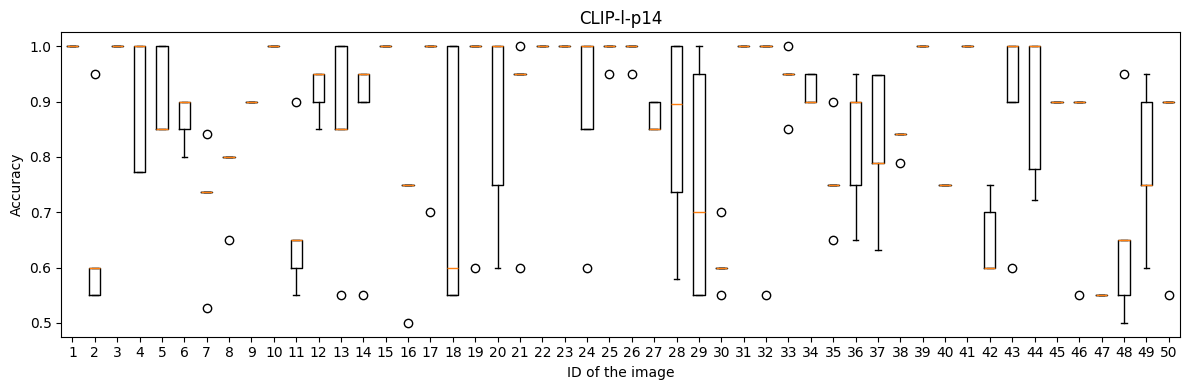

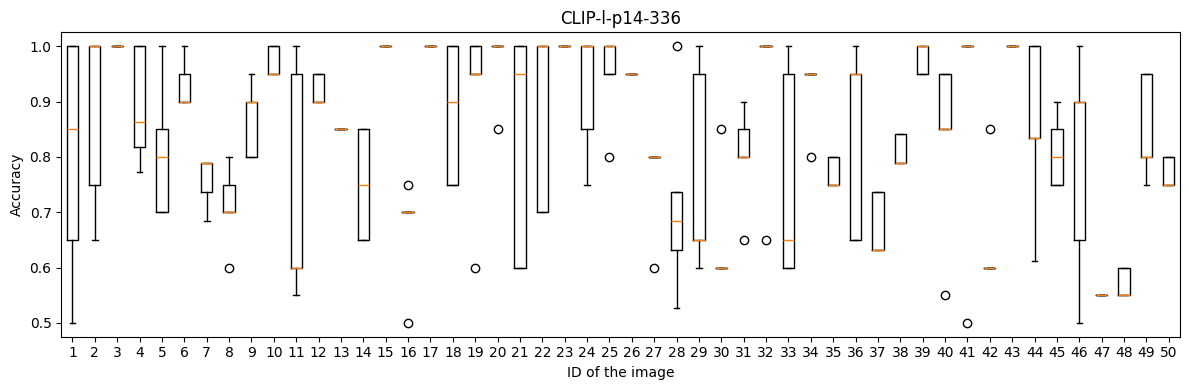

In [23]:
for i in range(len(method_names)):
  fig, ax = plt.subplots(figsize=(12, 4))  # Adjust figure size as needed
  ax.boxplot(accuracy_array_3D[i])
  ax.set_title(method_names[i])
  ax.set_xlabel('ID of the image')
  ax.set_ylabel('Accuracy')
  plt.tight_layout()  # Adjust layout to prevent overlapping elements
  plt.show()


# Ablation study on influence of batch size on the results

In [ ]:
# Partially repeated code...
# could most likely pack this into seperate function, keeping it like this to make sure the results are reproducible,
# don't want unexpected effect, that I didn't observe during my initial evaluation.
if DO_ABLATION_STUDY:
  DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

  import warnings
  warnings.filterwarnings("ignore", category=FutureWarning, message="'force_all_finite' was renamed to 'ensure_all_finite'")

  for batch_size in BATCH_SIZE_ARRAY:
    for k, exp in enumerate(experiments_list):
      print("Model:", exp.model_path)
      print("Batch size:", batch_size)
      exp.init_model_n_processor()
      for i, image_path in tqdm(enumerate(jpg_files), desc='per image', total=len(jpg_files)):
          image = cv2.imread(str(image_path))
          players_crops = [sv.crop_image(image, xyxy) for xyxy in detections_list[i].xyxy]
          pillow_crops = [sv.cv2_to_pillow(crop) for crop in players_crops]
          batches = chunked(pillow_crops, batch_size)

          data = []
          start_time = time.perf_counter()
          for batch in batches:
            data.append(exp.forward(batch))
          end_time = time.perf_counter()
          exp.execution_time_list.append(end_time - start_time)

          data = np.concatenate(data)
          projections = Umap_reducer.fit_transform(data)
          clusters = np.array(KMeans_model.fit_predict(projections))

          total_time = time.perf_counter()
          exp.total_execution_time_list.append(total_time - start_time)

          result, clusters = get_best_results_n_clusters(clusters.astype(bool), detections_list[i].class_id.astype(bool))
          exp.results_list.append(result.sum() / len(clusters))
          exp.clusters_list.append(clusters)
      exp.clean_up()
      experiments_list[k] = exp

      print("Mean: ", np.mean(exp.results_list))
      print("Mean execution time: ", np.mean(exp.execution_time_list))
      print("FPS: ", 1/np.mean(exp.execution_time_list))
      print(exp.results_list)
      print("\n")

    save_results_to_google_drive(experiments_list, batch_size)

In [ ]:
if DO_ABLATION_STUDY:
  all_experiments_for_all_batches=[]
  for batch_size in BATCH_SIZE_ARRAY:
    all_experiments_for_all_batches.append(load_results_from_google_drive(batch_size))

  # Settings
  show_plot_for_each_exp = True
  show_percentage_differences = True
  show_percentage_differences_text = True

  accuracy_diff_list = []
  exec_time_diff_list = []
  total_exec_time_diff_list = []
  model_name_list = []

  for i_exp in range(len(all_experiments_for_all_batches[0])): # for experiment, every batch has so many methods in it
    mean_results_list = []
    mean_exec_time_list = []
    mean_total_exec_time_list = []
    for i_batch in range(len(all_experiments_for_all_batches)): # for batch size
      current_exp = all_experiments_for_all_batches[i_batch][i_exp]
      mean_results_list.append(np.mean(current_exp.results_list))
      mean_exec_time_list.append(np.mean(current_exp.execution_time_list))
      mean_total_exec_time_list.append(np.mean(current_exp.total_execution_time_list))

    if show_plot_for_each_exp:
      fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns
      ax1.plot(np.array(BATCH_SIZE_ARRAY), np.array(mean_results_list), label="Mean Accuracy")
      ax1.set_xlabel('Batch Size')
      ax1.set_ylabel('Mean Accuracy')
      ax1.legend()

      ax2.plot(np.array(BATCH_SIZE_ARRAY), np.array(mean_exec_time_list), label="Mean Exec time")
      ax2.plot(np.array(BATCH_SIZE_ARRAY), np.array(mean_total_exec_time_list), label="Mean Total Exec time")
      ax2.set_xlabel('Batch Size')
      ax2.set_ylabel('Mean Execution Time')
      ax2.legend()

      fig.suptitle("Influence of Batch Size on Performance for " + current_exp.model_path, fontsize=16)
      plt.show()

    if show_percentage_differences:
      mean_results_list = np.array(mean_results_list)
      mean_exec_time_list = np.array(mean_exec_time_list)
      mean_total_exec_time_list = np.array(mean_total_exec_time_list)

      accuracy_diff = ((np.max(mean_results_list) - np.min(mean_results_list)) / np.max(mean_results_list)) * 100
      exec_time_diff = ((mean_exec_time_list[0] - mean_exec_time_list[-1]) / mean_exec_time_list[0]) * 100
      total_exec_time_diff = ((mean_total_exec_time_list[0] - mean_total_exec_time_list[-1]) / mean_total_exec_time_list[0]) * 100

      accuracy_diff_list.append(accuracy_diff)
      exec_time_diff_list.append(exec_time_diff)
      total_exec_time_diff_list.append(total_exec_time_diff)
      model_name_list.append(current_exp.model_path)
      if show_percentage_differences_text:
        print(current_exp.model_path)
        print("Accuracy difference: ", accuracy_diff)
        print("Execution time difference: ", exec_time_diff)
        print("Total execution time difference: ", total_exec_time_diff)

  if show_percentage_differences:
    fig, ax = plt.subplots(figsize=(15, 6))
    ax.plot(model_name_list, accuracy_diff_list, label="Accuracy Difference (%)", marker='o')
    ax.set_xlabel("Model Name")
    ax.set_ylabel("Relative Accuracy Difference (%)")
    ax.set_title("Maximal accuracy difference across different models and batch sizes")
    ax.legend()
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent overlapping elements


    fig, ax = plt.subplots(figsize=(15, 6))
    ax.plot(model_name_list, exec_time_diff_list, label="Execution Time Difference (%)", marker='s')
    ax.plot(model_name_list, total_exec_time_diff_list, label="Total Execution Time Difference (%)", marker='^')
    ax.axhline(y=0, color='gray', linestyle='--', label="Zero Difference") # Line at y=0
    ax.set_xlabel("Model Name")
    ax.set_ylabel("Relative Time Difference (%)")
    ax.set_title("Relative time difference between batch size of 1 and 32 across different models")
    ax.legend()
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent overlapping elements
